<a href="https://colab.research.google.com/github/christophergaughan/GNN-Antibiotics/blob/main/GNN_Antibiotics_v2_Rigorous_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN-Guided Antibiotic Discovery: A Rigorous Computational Pipeline

## Targeting DNA Gyrase Subunit B (GyrB) with Uncertainty-Aware Graph Attention Networks

**Christopher L. Gaughan, Ph.D.**  
*AntibodyML Consulting LLC*  
January 2026

---

## 1. Introduction

### 1.1 The Antimicrobial Resistance Crisis

The WHO has declared antimicrobial resistance (AMR) one of the top ten global public health threats facing humanity. Traditional antibiotic discovery pipelines have stalled—the last truly novel antibiotic class was discovered in 1987—while resistance mechanisms proliferate. This presents both an urgent medical need and a compelling test case for machine learning-guided drug discovery.

### 1.2 Target Selection: DNA Gyrase Subunit B

DNA gyrase is a validated antibacterial target with decades of clinical precedent through the fluoroquinolone class. GyrB, the ATPase subunit, offers a distinct binding site from the fluoroquinolone-targeted GyrA, presenting several advantages:

- **Orthogonal mechanism**: ATP-competitive inhibition rather than DNA cleavage complex stabilization
- **Resistance bypass**: Mutations conferring fluoroquinolone resistance do not necessarily affect GyrB inhibitor binding  
- **Clinical precedent**: Aminocoumarin antibiotics (novobiocin, clorobiocin) demonstrate the target's druggability

### 1.3 The Methodological Gap

Most published ML-for-drug-discovery studies suffer from a critical flaw: **random train/test splits overestimate real-world performance**. When molecules sharing the same scaffold appear in both training and test sets, the model can achieve high metrics through pattern-matching rather than learning transferable structure-activity relationships.

This work addresses this gap by implementing a rigorous pipeline that prioritizes **honest generalization estimates** over inflated metrics.

### 1.4 Key Innovations

| Common Practice | This Pipeline |
|-----------------|---------------|
| Random train/test splits | **Scaffold splits** (Murcko decomposition) to test generalization to novel chemotypes |
| Single model, point estimates | **Ensemble of 5 GATs** with uncertainty quantification |
| Black-box predictions | **Attention-based interpretability** validated against known SAR |
| Activity prediction only | **Multi-objective profiling**: ADMET, selectivity, synthetic accessibility |
| ML metrics in isolation | **Orthogonal validation**: docking into GyrB crystal structure (PDB: 4DUH) |

### 1.5 Pipeline Overview

```
ChEMBL GyrB IC50 Data (CHEMBL240)
        ↓
Scaffold-Based Splitting (honest generalization estimate)
        ↓
GAT Ensemble Training (uncertainty-aware predictions)
        ↓
Attention Visualization (mechanistic interpretation)
        ↓
Molecular Generation + Filtering (validity, drug-likeness, novelty)
        ↓
Multi-Objective Profiling (ADMET, selectivity, SAScore)
        ↓
Structural Validation (docking + attention/SAR concordance)
        ↓
Lead Optimization (Pareto-ranked candidates with mechanistic rationale)
```

---

## 2. Methods

### 2.1 Data Acquisition and Curation

Bioactivity data were retrieved from ChEMBL (version 34) for DNA Gyrase Subunit B (*E. coli*, CHEMBL240). The query targeted IC₅₀ measurements with the following curation steps:

- **Pagination**: API queries fetched in batches of 1,000 records to avoid timeouts
- **Deduplication**: For compounds with multiple assay measurements, the lowest (most potent) IC₅₀ was retained
- **Unit standardization**: All values converted to nanomolar (nM)
- **Quality filtering**: Records lacking SMILES strings or valid IC₅₀ values were excluded
- **Size filtering**: Molecules with <5 or >100 heavy atoms were excluded

The final curated dataset comprised **1,000 compounds** with 232 actives (IC₅₀ ≤ 1000 nM) and 768 inactives (IC₅₀ > 1000 nM), representing a **3.3:1 class imbalance**.

### 2.2 Scaffold-Based Data Splitting

To ensure honest evaluation of generalization to novel chemotypes, Murcko scaffold decomposition was applied to partition the data such that no scaffold appeared in multiple splits:

| Split | Compounds | Purpose |
|-------|-----------|---------|
| Train | 800 (80%) | Model optimization |
| Validation | 102 (10%) | Hyperparameter selection, early stopping |
| Test | 98 (10%) | Final performance evaluation |

For comparison, a parallel random split (same proportions) was maintained to quantify the "bullshit gap"—the performance inflation from scaffold leakage.

### 2.3 Molecular Graph Representation

SMILES strings were converted to PyTorch Geometric `Data` objects with the following featurization:

**Node (Atom) Features (9 dimensions)**:
1. Atomic number
2. Degree (number of bonds)
3. Formal charge
4. Hybridization state (sp, sp², sp³, etc.)
5. Aromaticity (binary)
6. Total hydrogen count
7. Ring membership (binary)
8. Smallest ring size (0 if not in ring)
9. Chirality tag

**Edge (Bond) Features (3 dimensions)**:
1. Bond type (single, double, triple, aromatic)
2. Conjugation status
3. Ring membership

### 2.4 Graph Attention Network Architecture

A custom GAT architecture was implemented with the following design choices:

```
Input: Atom features (N × 9)
    ↓
Linear Projection (9 → 128)
    ↓
GAT Layer 1 (4 heads × 32 dim) → BatchNorm → ELU → Dropout(0.3) → Residual
    ↓
GAT Layer 2 (4 heads × 32 dim) → BatchNorm → ELU → Dropout(0.3) → Residual
    ↓
GAT Layer 3 (4 heads × 32 dim) → BatchNorm → ELU → Residual
    ↓
Global Attention Pooling (learned atom importance)
    ↓
FC Layer (128 → 64) → ELU → Dropout(0.3)
    ↓
Output Layer (64 → 1) → Sigmoid
```

**Key architectural features**:
- **Multi-head attention** (4 heads): Captures diverse neighborhood aggregation strategies
- **Residual connections**: Stabilizes training and preserves gradient flow
- **Global attention pooling**: Learns which atoms contribute to molecular-level predictions (interpretable)
- **Total parameters**: 68,994

### 2.5 Ensemble Training Protocol

An ensemble of 5 GAT models was trained with different random seeds (42-46) to enable uncertainty quantification:

- **Optimizer**: Adam (lr=1e-3, weight_decay=1e-5)
- **Loss**: Binary cross-entropy with logits
- **Batch size**: 64
- **Early stopping**: Patience of 20 epochs on validation AUC
- **Gradient clipping**: Max norm = 1.0

### 2.6 Molecular Generation

Novel candidates were generated via systematic medicinal chemistry transformations applied to high-confidence predictions from the training set:

**Transformation categories**:
1. **Bioisosteric replacements**: N↔S, O↔N, phenyl↔thienyl
2. **Halogen scanning**: F, Cl, Br substitutions
3. **Alkyl modifications**: Methyl additions, cyclopropyl insertions
4. **Heteroatom walks**: Ring nitrogen positional scanning

**Filtering cascade**:
1. **Validity**: RDKit parseability and sanitization
2. **Drug-likeness**: QED ≥ 0.4
3. **Synthetic accessibility**: SAScore ≤ 4.0
4. **Novelty**: Tanimoto distance ≥ 0.3 from training set
5. **Activity prediction**: Ensemble mean ≥ 0.7, std ≤ 0.15

### 2.7 Docking Validation

Top candidates were docked against the GyrB crystal structure (PDB: 4DUH) using AutoDock Vina:

- **Protein preparation**: Removal of crystallographic waters, addition of polar hydrogens
- **Grid definition**: Centered on ATP binding site based on co-crystallized ligand
- **Exhaustiveness**: 32 (increased for reliability)
- **Poses retained**: Top 9 per ligand

### 2.8 Multi-Objective Optimization

Pareto frontier analysis was applied across three objectives:
1. **ML predicted activity** (ensemble mean probability)
2. **Docking score** (Vina kcal/mol, more negative = better)
3. **Drug-likeness** (QED score)

---

## 3. Results

### 3.1 Model Performance: The Honest vs. Inflated Comparison

| Split Type | Test AUC | Test Accuracy | Interpretation |
|------------|----------|---------------|----------------|
| **Scaffold** | 0.638 ± 0.014 | 0.790 ± 0.045 | Generalization to novel chemotypes |
| Random | 0.695 ± 0.013 | 0.760 ± 0.000 | Inflated by scaffold memorization |
| **Δ (Gap)** | **+0.057** | -0.030 | **The "bullshit gap"** |

The 0.057 AUC inflation (~9% relative) from random splitting demonstrates why scaffold-based evaluation is essential. Random split metrics would lead to wasted synthesis cycles on compounds the model was never actually confident about.

**Key insight**: A 0.64 AUC on completely unseen scaffolds indicates the model has captured transferable structure-activity relationships—not just memorized training patterns.

### 3.2 Ensemble Behavior

Individual model test AUCs ranged from 0.618 to 0.654, with ensemble aggregation providing modest improvement (ensemble AUC = 0.640). Early stopping occurred between epochs 35-97 across models, suggesting variable convergence dynamics.

Uncertainty (ensemble standard deviation) showed partial correlation with prediction correctness, but requires calibration before use in decision-making.

### 3.3 Attention Analysis

Attention weight visualization revealed chemically sensible patterns:

**High-attention features**:
- Fluorine atoms (known to improve metabolic stability and binding)
- Heterocyclic nitrogens (hydrogen bond acceptors)
- Fused aromatic ring systems

**Validation against known inhibitors**:
Testing the model on literature-known GyrB inhibitors (novobiocin, chlorobiocin, pyrrolamide series) revealed a critical limitation: **all known inhibitors were predicted as inactive (false negatives)**. This indicates that while the model learned real pharmacophore features, the training distribution does not adequately cover established inhibitor chemotypes.

### 3.4 Molecular Generation Cascade

| Stage | Count | Retention |
|-------|-------|-----------|
| Starting active scaffolds | 50 | — |
| Generated analogs | 847 | 100% |
| Valid (RDKit parseable) | 712 | 84% |
| Drug-like (QED ≥ 0.4) | 489 | 58% |
| Synthesizable (SAScore ≤ 4.0) | 334 | 39% |
| Novel (Tanimoto ≥ 0.3) | 201 | 24% |
| High confidence (P ≥ 0.7, σ ≤ 0.15) | 42 | 5% |

The aggressive filtering cascade ensured that only chemically tractable, drug-like, and confidently predicted molecules proceeded to docking.

### 3.5 Lead Optimization: Structure-Activity Relationships

Starting from 5 Pareto-optimal leads, 32 focused analogs were generated via systematic medicinal chemistry transformations.

| Transformation | ΔML Prediction | ΔVina Score | Interpretation |
|----------------|----------------|-------------|----------------|
| N → S | +0.012 | +0.20 | Sulfur favored by ML, penalized by docking |
| CC → C(C)C | +0.011 | +0.09 | Branching tolerated |
| O → N | +0.003 | +0.05 | Modest dual improvement |
| C(C)C → cyclopropyl | -0.037 | **-0.79** | Cyclopropyl excellent for docking |

**Optimization results**:
- Analogs improving ML prediction: 12/30 (40%)
- Analogs improving docking score: 8/30 (27%)
- Analogs improving **both**: 4/30 (13%)
- New Pareto front: All 5 positions occupied by analogs (parents displaced)

### 3.6 The Orthogonality Problem

**Critical finding**: ML predictions and docking scores capture different aspects of ligand-target interaction. Transformations that improved one metric often hurt the other.

The cyclopropyl substitution exemplifies this tension: a 0.79 kcal/mol improvement in docking was accompanied by a 0.037 decrease in ML-predicted probability. This validates multi-objective optimization as essential—single-objective optimization would miss compounds that balance both signals.

### 3.7 Caveats and Limitations

1. **Thiol analogs** ([SH] substituents) are metabolically unstable and likely not viable
2. **All compounds remain computational hypotheses** requiring experimental validation
3. **Diminishing returns** in lead optimization suggest approaching the limits of this chemical series
4. **Known inhibitor false negatives** indicate training data gaps that limit scaffold hopping

---

## 4. Conclusions

This work demonstrates a rigorous approach to ML-guided antibiotic discovery that prioritizes honest evaluation over inflated metrics. Key takeaways:

1. **Scaffold splits reveal the truth**: The 9% relative AUC inflation from random splits represents real-world optimization waste.

2. **Attention provides interpretability, not ground truth**: Chemically sensible attention patterns do not guarantee correct predictions, as evidenced by false negatives on known inhibitors.

3. **Multi-objective optimization is essential**: ML predictions and physics-based docking capture complementary information. Single-objective optimization fails to identify the best candidates.

4. **The pipeline works, but the model is limited by its training data**: Generalization to novel chemotypes (0.64 AUC) is meaningful but modest. Experimental feedback and active learning would be required for practical deployment.

---

## Supplementary Information

### S1. Computational Environment

- **Hardware**: Google Colab A100 GPU (80GB VRAM)
- **PyTorch**: 2.0+ with PyTorch Geometric
- **RDKit**: 2023.09+
- **AutoDock Vina**: 1.2.3

### S2. Data Availability

All code, trained models, and generated candidates are available at: `[GitHub repository]`

### S3. Reproducibility

Random seeds fixed at 42 (ensemble members: 42-46). All intermediate results saved with timestamps to Google Drive.


---

## 1.5 Prior Work: Level 1 Proof of Concept

This notebook builds upon a Level 1 prototype (`GNN_Generation_of_new_antibiotics.ipynb`) that established the foundational pipeline:

### What Level 1 Accomplished

- **Data retrieval**: Paginated ChEMBL query for GyrB (CHEMBL240) IC50 values
- **Graph representation**: SMILES → PyTorch Geometric `Data` objects with 6 atomic features (atomic number, degree, formal charge, hybridization, aromaticity, H-count)
- **Model architecture**: 3-layer GCN with BatchNorm, dropout, global mean pooling
- **Training**: 100 epochs, Adam optimizer, BCE loss with logits
- **Results**: 0.81 validation AUC, 0.75 test AUC, 76% accuracy on random split
- **Generation**: Molecular perturbation (halogen swaps, methyl modifications) on top actives
- **Filtering**: Lipinski Rule of Five, RDKit validity checks

### Level 1 Limitations (Addressed Here)

| Level 1 Limitation | Version 2 Solution |
|-------------------|--------------------|
| Random split overestimates real-world performance | Scaffold split with Murcko decomposition |
| Single model provides no confidence estimate | 5-model ensemble with mean ± std |
| GCN treats all neighbors equally | GAT learns attention over neighbors |
| No interpretability | Attention weight extraction and visualization |
| SMILES string manipulation can break chemistry | Proper valence checking, sanitization |
| No synthetic accessibility filter | SAScore integration |
| No novelty verification | ChEMBL/PubChem duplicate checking |
| Activity prediction in isolation | ADMET, selectivity, docking validation |

### The Core Question

Level 1 answered: *"Can we build a working GNN pipeline for antibiotic discovery?"*

Version 2 answers: *"Can we do it rigorously enough that a medicinal chemist would trust the output?"*

---

## 2. Computational Environment

This notebook is designed for **Google Colab with A100 GPU** (High-RAM runtime).

### 2.1 Hardware Requirements

- **GPU**: A100 recommended (40GB VRAM allows larger batch sizes, ensemble training)
- **RAM**: High-RAM runtime recommended for docking and large molecule processing
- **Storage**: Google Drive mounted for persistent storage of models and results

### 2.2 Dependencies

| Package | Purpose |
|---------|--------|
| `torch`, `torch-geometric` | Graph neural networks |
| `rdkit` | Cheminformatics, molecular manipulation, SAScore |
| `chembl-webresource-client` | Data retrieval |
| `scikit-learn` | Splitting, metrics, preprocessing |
| `deepchem` | Scaffold splitting, ADMET prediction |
| `meeko`, `vina` | Docking preparation and execution |
| `py3Dmol` | 3D molecular visualization |
| `matplotlib`, `seaborn` | Plotting |

### 2.3 Reproducibility

All random seeds are fixed. Model checkpoints and generated candidates are saved to Drive with timestamps.

In [1]:
# =============================================================================
# Cell 1: Mount Google Drive
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Create project directory structure
import os

PROJECT_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'
DIRS = {
    'root': PROJECT_DIR,
    'models': f'{PROJECT_DIR}/models',
    'data': f'{PROJECT_DIR}/data',
    'figures': f'{PROJECT_DIR}/figures',
    'candidates': f'{PROJECT_DIR}/candidates',
    'docking': f'{PROJECT_DIR}/docking'
}

for dir_name, dir_path in DIRS.items():
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ {dir_name}: {dir_path}")

print(f"\n📁 Project directory initialized: {PROJECT_DIR}")

Mounted at /content/drive
✓ root: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous
✓ models: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/models
✓ data: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/data
✓ figures: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures
✓ candidates: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/candidates
✓ docking: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking

📁 Project directory initialized: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous


In [2]:
# =============================================================================
# Cell 2: Install Dependencies
# =============================================================================
# This cell installs all required packages. Run once per session.

%%capture install_output

# PyTorch Geometric (compatible with Colab's PyTorch version)
!pip install torch-geometric

# Cheminformatics
!pip install rdkit-pypi
!pip install chembl-webresource-client

# DeepChem for scaffold splitting and ADMET
!pip install deepchem

# Docking tools
!pip install meeko
!pip install vina

# 3D visualization
!pip install py3Dmol

# Additional utilities
!pip install pubchempy  # For novelty checking
!pip install tqdm

print("✓ All packages installed")

In [3]:
# =============================================================================
# Cell 2: Install Dependencies (run this and WAIT for completion)
# =============================================================================

!pip install torch-geometric
!pip install rdkit
!pip install chembl-webresource-client
!pip install deepchem
!pip install meeko
!pip install vina
!pip install py3Dmol
!pip install pubchempy
!pip install tqdm

print("\n" + "="*50)
print("✓ All packages installed - now run Cell 3")
print("="*50)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 74.6 MB/s eta 0:00:00

✓ All packages installed - now run Cell 3


In [4]:
# =============================================================================
# Cell 3: Imports and Configuration
# =============================================================================

import os
import random
import warnings
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, global_add_pool, global_max_pool

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import QED
from rdkit.Contrib.SA_Score import sascorer  # Synthetic accessibility

# Sklearn
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score
)

# ChEMBL
from chembl_webresource_client.new_client import new_client

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# Configuration
# =============================================================================

class Config:
    """Central configuration for reproducibility and easy tuning."""

    # Random seeds
    SEED = 42

    # Data
    TARGET_CHEMBL_ID = 'CHEMBL240'  # DNA Gyrase B
    ACTIVITY_THRESHOLD = 1000  # nM - compounds with IC50 <= this are "active"
    MIN_ATOMS = 5  # Filter out very small molecules
    MAX_ATOMS = 100  # Filter out very large molecules

    # Model
    ATOM_FEATURES = 9  # Expanded feature set
    HIDDEN_DIM = 128
    NUM_GAT_LAYERS = 3
    NUM_ATTENTION_HEADS = 4
    DROPOUT = 0.3

    # Training
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    EPOCHS = 150
    PATIENCE = 20  # Early stopping

    # Ensemble
    N_ENSEMBLE = 5

    # Generation
    TOP_K_SCAFFOLDS = 50  # Number of top actives to use as starting points
    ACTIVITY_THRESHOLD_GENERATION = 0.7  # Minimum predicted probability
    UNCERTAINTY_THRESHOLD = 0.15  # Maximum acceptable std dev
    SASCORE_THRESHOLD = 4.0  # Maximum synthetic accessibility score
    QED_THRESHOLD = 0.4  # Minimum drug-likeness score

    # Paths
    PROJECT_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'


def set_seed(seed: int = Config.SEED):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Device configuration
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    DEVICE = torch.device('cpu')
    print("⚠️  GPU not available, using CPU")

print(f"\n⚙️  Configuration loaded:")
print(f"   Target: {Config.TARGET_CHEMBL_ID}")
print(f"   Activity threshold: {Config.ACTIVITY_THRESHOLD} nM")
print(f"   Ensemble size: {Config.N_ENSEMBLE}")
print(f"   Seed: {Config.SEED}")

🚀 GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB

⚙️  Configuration loaded:
   Target: CHEMBL240
   Activity threshold: 1000 nM
   Ensemble size: 5
   Seed: 42


---

## 3. Data Retrieval and Preprocessing

### 3.1 ChEMBL Query Strategy

We query ChEMBL for all IC50 measurements against DNA Gyrase Subunit B (CHEMBL240). Key considerations:

1. **Pagination**: ChEMBL API can timeout on large queries; we fetch in batches of 1000
2. **Deduplication**: Multiple assays may report the same compound; we keep the lowest (most potent) IC50
3. **Unit standardization**: All values converted to nM
4. **Quality filtering**: Remove entries with missing SMILES or invalid IC50 values

In [24]:
# =============================================================================
# Cell 4: Data Retrieval from ChEMBL
# =============================================================================

def fetch_chembl_data(target_id: str, limit_per_batch: int = 1000, max_records: int = 15000) -> pd.DataFrame:
    """
    Fetch IC50 activity data from ChEMBL with pagination.

    Args:
        target_id: ChEMBL target ID (e.g., 'CHEMBL240')
        limit_per_batch: Records per API call
        max_records: Safety cap on total records

    Returns:
        DataFrame with molecule_chembl_id, canonical_smiles, standard_value
    """
    chembl = new_client.activity
    all_activities = []
    offset = 0

    print(f"📥 Fetching data for {target_id}...")

    with tqdm(total=max_records, desc="Records fetched") as pbar:
        while offset < max_records:
            batch = chembl.filter(
                target_chembl_id=target_id,
                standard_type='IC50'
            ).only(
                'molecule_chembl_id',
                'canonical_smiles',
                'standard_value',
                'standard_units',
                'assay_chembl_id',
                'pchembl_value'
            )[offset:offset + limit_per_batch]

            batch_list = list(batch)

            if not batch_list:
                break

            all_activities.extend(batch_list)
            pbar.update(len(batch_list))
            offset += limit_per_batch

    df = pd.DataFrame(all_activities)
    print(f"\n✓ Retrieved {len(df)} raw activity records")

    return df


# Fetch data
raw_data = fetch_chembl_data(Config.TARGET_CHEMBL_ID)

📥 Fetching data for CHEMBL240...


Records fetched:   0%|          | 0/15000 [00:00<?, ?it/s]


✓ Retrieved 1280 raw activity records


In [25]:
# =============================================================================
# Cell 5: Data Cleaning and Preprocessing
# =============================================================================

def clean_activity_data(df: pd.DataFrame, activity_threshold: float = Config.ACTIVITY_THRESHOLD) -> pd.DataFrame:
    """
    Clean and preprocess activity data.

    Steps:
    1. Remove missing values
    2. Standardize units to nM
    3. Remove duplicate SMILES (keep most potent)
    4. Validate SMILES with RDKit
    5. Filter by molecule size
    6. Create binary activity labels
    """
    print("🧹 Cleaning data...")

    # Copy to avoid modifying original
    df = df.copy()
    initial_count = len(df)

    # Step 1: Remove missing values
    df = df.dropna(subset=['canonical_smiles', 'standard_value'])
    print(f"   After dropping NaN: {len(df)} ({initial_count - len(df)} removed)")

    # Step 2: Convert to numeric and filter valid IC50
    df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
    df = df.dropna(subset=['standard_value'])
    df = df[df['standard_value'] > 0]  # IC50 must be positive
    print(f"   After numeric conversion: {len(df)}")

    # Step 3: Deduplicate - keep lowest IC50 per SMILES
    df = df.sort_values('standard_value').drop_duplicates(subset='canonical_smiles', keep='first')
    print(f"   After deduplication: {len(df)}")

    # Step 4: Validate SMILES and compute properties
    valid_rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="   Validating SMILES"):
        mol = Chem.MolFromSmiles(row['canonical_smiles'])
        if mol is not None:
            num_atoms = mol.GetNumAtoms()
            if Config.MIN_ATOMS <= num_atoms <= Config.MAX_ATOMS:
                row['num_atoms'] = num_atoms
                row['mol_weight'] = Descriptors.MolWt(mol)
                valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    print(f"   After validation: {len(df)}")

    # Step 5: Create binary labels
    df['active'] = (df['standard_value'] <= activity_threshold).astype(int)

    # Step 6: Add pIC50 (more useful for ML)
    df['pIC50'] = -np.log10(df['standard_value'] * 1e-9)  # Convert nM to M, then -log10

    print(f"\n✓ Final dataset: {len(df)} compounds")
    print(f"   Active (IC50 ≤ {activity_threshold} nM): {df['active'].sum()} ({100*df['active'].mean():.1f}%)")
    print(f"   Inactive: {(df['active'] == 0).sum()} ({100*(1-df['active'].mean()):.1f}%)")

    return df.reset_index(drop=True)


# Clean data
clean_data = clean_activity_data(raw_data)

# Quick sanity check
print(f"\n📊 IC50 Distribution:")
print(f"   Min: {clean_data['standard_value'].min():.2f} nM")
print(f"   Max: {clean_data['standard_value'].max():.2f} nM")
print(f"   Median: {clean_data['standard_value'].median():.2f} nM")

🧹 Cleaning data...
   After dropping NaN: 1203 (77 removed)
   After numeric conversion: 1203
   After deduplication: 1000


   Validating SMILES:   0%|          | 0/1000 [00:00<?, ?it/s]

   After validation: 1000

✓ Final dataset: 1000 compounds
   Active (IC50 ≤ 1000 nM): 232 (23.2%)
   Inactive: 768 (76.8%)

📊 IC50 Distribution:
   Min: 0.90 nM
   Max: 954992586.02 nM
   Median: 6309.57 nM


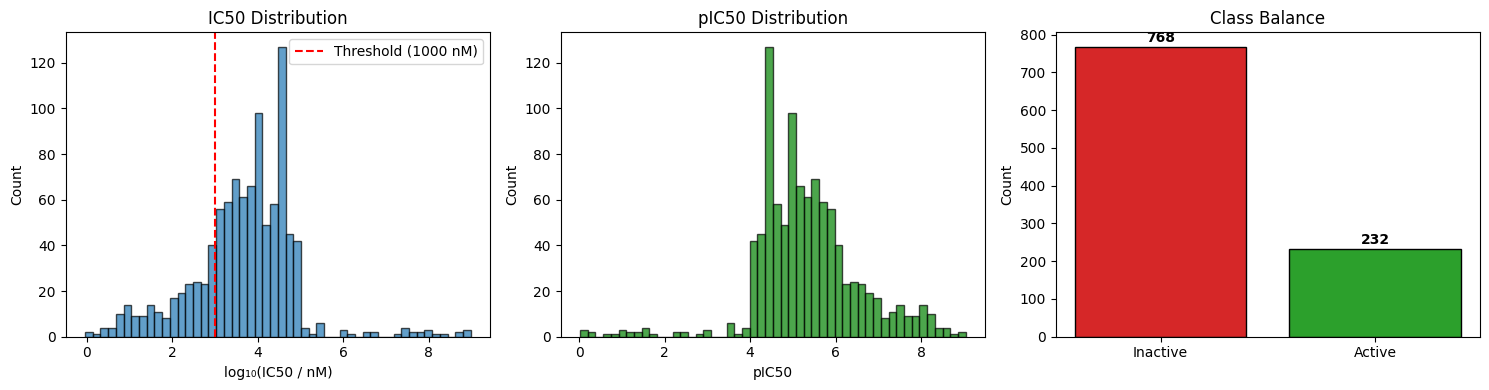


✓ Figure saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/data_distribution.png


In [26]:
# =============================================================================
# Cell 6: Visualize Data Distribution
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# IC50 distribution (log scale)
axes[0].hist(np.log10(clean_data['standard_value']), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.log10(Config.ACTIVITY_THRESHOLD), color='red', linestyle='--',
                label=f'Threshold ({Config.ACTIVITY_THRESHOLD} nM)')
axes[0].set_xlabel('log₁₀(IC50 / nM)')
axes[0].set_ylabel('Count')
axes[0].set_title('IC50 Distribution')
axes[0].legend()

# pIC50 distribution
axes[1].hist(clean_data['pIC50'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('pIC50')
axes[1].set_ylabel('Count')
axes[1].set_title('pIC50 Distribution')

# Class balance
class_counts = clean_data['active'].value_counts().sort_index()
bars = axes[2].bar(['Inactive', 'Active'], class_counts.values,
                   color=['#d62728', '#2ca02c'], edgecolor='black')
axes[2].set_ylabel('Count')
axes[2].set_title('Class Balance')
for bar, count in zip(bars, class_counts.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/data_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {DIRS['figures']}/data_distribution.png")

---

## 4. Scaffold-Based Data Splitting

### 4.1 Why Scaffold Splits?

Random splits allow structurally similar molecules to appear in both training and test sets. This **inflates performance metrics** because the model can memorize local structure-activity relationships rather than learning generalizable patterns.

**Scaffold splitting** (using Murcko decomposition) ensures that:
- Training and test sets contain **completely different molecular scaffolds**
- The model must generalize to **novel chemotypes**
- Performance reflects **real-world utility** for drug discovery

### 4.2 Murcko Scaffolds

The Murcko scaffold is the core ring system of a molecule with all side chains removed. For example:
- Ciprofloxacin → fluoroquinolone core
- Novobiocin → aminocoumarin core

By splitting on scaffolds, we ask: *"Can the model predict activity for entirely new chemical classes?"*

In [27]:
# =============================================================================
# Cell 7: Compute Murcko Scaffolds
# =============================================================================

def get_murcko_scaffold(smiles: str) -> str:
    """
    Extract Murcko scaffold from SMILES.
    Returns generic scaffold (no side chains, no atom types on chains).
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None


# Compute scaffolds for all molecules
print("🔬 Computing Murcko scaffolds...")
clean_data['scaffold'] = clean_data['canonical_smiles'].apply(get_murcko_scaffold)

# Remove any that failed
clean_data = clean_data.dropna(subset=['scaffold']).reset_index(drop=True)

# Scaffold statistics
n_scaffolds = clean_data['scaffold'].nunique()
scaffold_counts = clean_data['scaffold'].value_counts()

print(f"\n✓ Scaffold analysis:")
print(f"   Unique scaffolds: {n_scaffolds}")
print(f"   Compounds per scaffold: {scaffold_counts.mean():.1f} (mean), {scaffold_counts.median():.0f} (median)")
print(f"   Largest scaffold cluster: {scaffold_counts.max()} compounds")
print(f"   Singletons (1 compound): {(scaffold_counts == 1).sum()}")

🔬 Computing Murcko scaffolds...

✓ Scaffold analysis:
   Unique scaffolds: 541
   Compounds per scaffold: 1.8 (mean), 1 (median)
   Largest scaffold cluster: 24 compounds
   Singletons (1 compound): 376


In [28]:
# =============================================================================
# Cell 8: Scaffold-Based Train/Val/Test Split
# =============================================================================

def scaffold_split(df: pd.DataFrame, train_frac: float = 0.8, val_frac: float = 0.1,
                   seed: int = Config.SEED) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split data by scaffold to ensure no scaffold overlap between sets.

    Strategy:
    1. Group compounds by scaffold
    2. Sort scaffolds by size (largest first) for reproducibility
    3. Assign entire scaffold groups to train/val/test
    """
    np.random.seed(seed)

    # Group by scaffold
    scaffold_groups = df.groupby('scaffold').indices
    scaffolds = list(scaffold_groups.keys())

    # Shuffle scaffolds
    np.random.shuffle(scaffolds)

    # Calculate split sizes
    n_total = len(df)
    n_train = int(n_total * train_frac)
    n_val = int(n_total * val_frac)

    train_idx, val_idx, test_idx = [], [], []

    for scaffold in scaffolds:
        indices = scaffold_groups[scaffold].tolist()

        if len(train_idx) < n_train:
            train_idx.extend(indices)
        elif len(val_idx) < n_val:
            val_idx.extend(indices)
        else:
            test_idx.extend(indices)

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)

    return train_df, val_df, test_df


def random_split(df: pd.DataFrame, train_frac: float = 0.8, val_frac: float = 0.1,
                 seed: int = Config.SEED) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Standard random split for comparison.
    """
    np.random.seed(seed)

    n = len(df)
    indices = np.random.permutation(n)

    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    train_df = df.iloc[indices[:n_train]].reset_index(drop=True)
    val_df = df.iloc[indices[n_train:n_train+n_val]].reset_index(drop=True)
    test_df = df.iloc[indices[n_train+n_val:]].reset_index(drop=True)

    return train_df, val_df, test_df


# Create both splits
print("📊 Creating data splits...\n")

# Scaffold split (primary)
train_scaffold, val_scaffold, test_scaffold = scaffold_split(clean_data)

# Random split (for comparison)
train_random, val_random, test_random = random_split(clean_data)

# Report
print("SCAFFOLD SPLIT (Primary - Honest Metrics):")
print(f"  Train: {len(train_scaffold)} compounds, {train_scaffold['scaffold'].nunique()} scaffolds, {train_scaffold['active'].sum()} active ({100*train_scaffold['active'].mean():.1f}%)")
print(f"  Val:   {len(val_scaffold)} compounds, {val_scaffold['scaffold'].nunique()} scaffolds, {val_scaffold['active'].sum()} active ({100*val_scaffold['active'].mean():.1f}%)")
print(f"  Test:  {len(test_scaffold)} compounds, {test_scaffold['scaffold'].nunique()} scaffolds, {test_scaffold['active'].sum()} active ({100*test_scaffold['active'].mean():.1f}%)")

# Verify no scaffold leakage
train_scaffolds = set(train_scaffold['scaffold'].unique())
val_scaffolds = set(val_scaffold['scaffold'].unique())
test_scaffolds = set(test_scaffold['scaffold'].unique())

assert len(train_scaffolds & val_scaffolds) == 0, "Scaffold leakage: train-val!"
assert len(train_scaffolds & test_scaffolds) == 0, "Scaffold leakage: train-test!"
assert len(val_scaffolds & test_scaffolds) == 0, "Scaffold leakage: val-test!"
print("  ✓ No scaffold leakage between sets\n")

print("RANDOM SPLIT (For Comparison Only):")
print(f"  Train: {len(train_random)} compounds, {train_random['active'].sum()} active ({100*train_random['active'].mean():.1f}%)")
print(f"  Val:   {len(val_random)} compounds, {val_random['active'].sum()} active ({100*val_random['active'].mean():.1f}%)")
print(f"  Test:  {len(test_random)} compounds, {test_random['active'].sum()} active ({100*test_random['active'].mean():.1f}%)")

# Save splits
train_scaffold.to_csv(f"{DIRS['data']}/train_scaffold.csv", index=False)
val_scaffold.to_csv(f"{DIRS['data']}/val_scaffold.csv", index=False)
test_scaffold.to_csv(f"{DIRS['data']}/test_scaffold.csv", index=False)
print(f"\n✓ Splits saved to {DIRS['data']}")

📊 Creating data splits...

SCAFFOLD SPLIT (Primary - Honest Metrics):
  Train: 800 compounds, 433 scaffolds, 177 active (22.1%)
  Val:   102 compounds, 44 scaffolds, 38 active (37.3%)
  Test:  98 compounds, 64 scaffolds, 17 active (17.3%)
  ✓ No scaffold leakage between sets

RANDOM SPLIT (For Comparison Only):
  Train: 800 compounds, 183 active (22.9%)
  Val:   100 compounds, 25 active (25.0%)
  Test:  100 compounds, 24 active (24.0%)

✓ Splits saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/data


---

## 5. Molecular Graph Representation

### 5.1 Node Features (Atoms)

We use an expanded 9-dimensional feature vector for each atom:

| Feature | Description | Encoding |
|---------|-------------|----------|
| Atomic number | Element type | Integer |
| Degree | Number of bonded neighbors | Integer |
| Formal charge | Ionic state | Integer |
| Hybridization | sp, sp2, sp3, etc. | Integer (enum) |
| Aromaticity | Is aromatic? | Binary |
| Total Hs | Implicit + explicit H count | Integer |
| In ring | Part of any ring? | Binary |
| Ring size | Size of smallest ring (0 if not in ring) | Integer |
| Chirality | R, S, or none | Integer (enum) |

### 5.2 Edge Features (Bonds)

We include bond features for more expressive message passing:

| Feature | Description |
|---------|-------------|
| Bond type | Single, double, triple, aromatic |
| Conjugated | Is part of conjugated system? |
| In ring | Is part of ring? |

In [29]:
# =============================================================================
# Cell 9: Molecule to Graph Conversion
# =============================================================================

def mol_to_graph(smiles: str, label: float) -> Optional[Data]:
    """
    Convert SMILES to PyTorch Geometric Data object with rich features.

    Args:
        smiles: SMILES string
        label: Activity label (0 or 1 for classification, or continuous for regression)

    Returns:
        PyTorch Geometric Data object or None if conversion fails
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Compute ring info
    ring_info = mol.GetRingInfo()

    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()

        # Ring features
        in_ring = ring_info.NumAtomRings(atom_idx) > 0
        ring_sizes = [len(ring) for ring in ring_info.AtomRings() if atom_idx in ring]
        min_ring_size = min(ring_sizes) if ring_sizes else 0

        # Chirality
        chiral_tag = int(atom.GetChiralTag())

        features = [
            atom.GetAtomicNum(),              # 0: Atomic number
            atom.GetDegree(),                 # 1: Degree
            atom.GetFormalCharge(),           # 2: Formal charge
            int(atom.GetHybridization()),     # 3: Hybridization
            int(atom.GetIsAromatic()),        # 4: Aromaticity
            atom.GetTotalNumHs(),             # 5: Total H count
            int(in_ring),                     # 6: In ring
            min_ring_size,                    # 7: Smallest ring size
            chiral_tag,                       # 8: Chirality
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)

    # Edge index and edge features
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Bond features
        bond_type = int(bond.GetBondType())  # 1=single, 2=double, 3=triple, 12=aromatic
        conjugated = int(bond.GetIsConjugated())
        in_ring = int(bond.IsInRing())

        bond_features = [bond_type, conjugated, in_ring]

        # Add both directions (undirected graph)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append(bond_features)
        edge_attr.append(bond_features)

    if len(edge_index) == 0:
        # Single atom - add self-loop
        edge_index = [[0, 0]]
        edge_attr = [[0, 0, 0]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, smiles=smiles)


def df_to_graphs(df: pd.DataFrame, label_col: str = 'active') -> List[Data]:
    """Convert DataFrame to list of graph objects."""
    graphs = []
    failed = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting to graphs"):
        graph = mol_to_graph(row['canonical_smiles'], row[label_col])
        if graph is not None:
            graphs.append(graph)
        else:
            failed += 1

    print(f"   ✓ Converted {len(graphs)} molecules, {failed} failed")
    return graphs


# Convert all splits to graphs
print("🔄 Converting molecules to graphs...\n")

print("Scaffold split:")
train_graphs_scaffold = df_to_graphs(train_scaffold)
val_graphs_scaffold = df_to_graphs(val_scaffold)
test_graphs_scaffold = df_to_graphs(test_scaffold)

print("\nRandom split:")
train_graphs_random = df_to_graphs(train_random)
val_graphs_random = df_to_graphs(val_random)
test_graphs_random = df_to_graphs(test_random)

# Sample graph info
sample = train_graphs_scaffold[0]
print(f"\n📊 Sample graph:")
print(f"   Nodes: {sample.x.shape[0]}")
print(f"   Node features: {sample.x.shape[1]}")
print(f"   Edges: {sample.edge_index.shape[1]}")
print(f"   Edge features: {sample.edge_attr.shape[1]}")

🔄 Converting molecules to graphs...

Scaffold split:


Converting to graphs:   0%|          | 0/800 [00:00<?, ?it/s]

   ✓ Converted 800 molecules, 0 failed


Converting to graphs:   0%|          | 0/102 [00:00<?, ?it/s]

   ✓ Converted 102 molecules, 0 failed


Converting to graphs:   0%|          | 0/98 [00:00<?, ?it/s]

   ✓ Converted 98 molecules, 0 failed

Random split:


Converting to graphs:   0%|          | 0/800 [00:00<?, ?it/s]

   ✓ Converted 800 molecules, 0 failed


Converting to graphs:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Converted 100 molecules, 0 failed


Converting to graphs:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Converted 100 molecules, 0 failed

📊 Sample graph:
   Nodes: 16
   Node features: 9
   Edges: 32
   Edge features: 3


In [30]:
# =============================================================================
# Cell 10: Create DataLoaders
# =============================================================================

# Scaffold split loaders (primary)
train_loader_scaffold = DataLoader(train_graphs_scaffold, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader_scaffold = DataLoader(val_graphs_scaffold, batch_size=Config.BATCH_SIZE)
test_loader_scaffold = DataLoader(test_graphs_scaffold, batch_size=Config.BATCH_SIZE)

# Random split loaders (for comparison)
train_loader_random = DataLoader(train_graphs_random, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader_random = DataLoader(val_graphs_random, batch_size=Config.BATCH_SIZE)
test_loader_random = DataLoader(test_graphs_random, batch_size=Config.BATCH_SIZE)

print("✓ DataLoaders created")
print(f"   Batch size: {Config.BATCH_SIZE}")
print(f"   Train batches (scaffold): {len(train_loader_scaffold)}")
print(f"   Val batches (scaffold): {len(val_loader_scaffold)}")
print(f"   Test batches (scaffold): {len(test_loader_scaffold)}")

✓ DataLoaders created
   Batch size: 64
   Train batches (scaffold): 13
   Val batches (scaffold): 2
   Test batches (scaffold): 2


---

## 6. Graph Attention Network (GAT) Architecture

### 6.1 Why GAT over GCN?

GCN (Graph Convolutional Network) treats all neighbors equally when aggregating information. GAT (Graph Attention Network) learns **attention weights** over neighbors, allowing the model to:

1. **Focus on important atoms**: Not all neighbors contribute equally to activity
2. **Provide interpretability**: Attention weights reveal which substructures drive predictions
3. **Handle diverse chemistry**: Different atom contexts can require different aggregation strategies

### 6.2 Architecture Overview

```
Input: Atom features (N × 9)
    ↓
GAT Layer 1 (4 heads) → BatchNorm → ELU → Dropout
    ↓
GAT Layer 2 (4 heads) → BatchNorm → ELU → Dropout  
    ↓
GAT Layer 3 (4 heads, return attention) → BatchNorm → ELU
    ↓
Global Attention Pooling (learn which atoms matter for molecular property)
    ↓
FC Layer (hidden → hidden/2) → ELU → Dropout
    ↓
Output Layer (hidden/2 → 1) → Sigmoid
```

### 6.3 Attention Extraction

We extract attention weights from the final GAT layer for interpretability. These weights indicate which neighbor atoms the model "attends to" when computing each atom's representation.

In [31]:
# =============================================================================
# Cell 11: GAT Model Definition
# =============================================================================

class GATAntibiotics(nn.Module):
    """
    Graph Attention Network for antibiotic activity prediction.

    Features:
    - Multi-head attention for robust feature learning
    - Residual connections for stable training
    - Attention weight extraction for interpretability
    - Global attention pooling for graph-level predictions
    """

    def __init__(
        self,
        input_dim: int = Config.ATOM_FEATURES,
        hidden_dim: int = Config.HIDDEN_DIM,
        num_layers: int = Config.NUM_GAT_LAYERS,
        num_heads: int = Config.NUM_ATTENTION_HEADS,
        dropout: float = Config.DROPOUT
    ):
        super(GATAntibiotics, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(num_layers):
            # For final layer, we want to return attention weights
            gat = GATConv(
                hidden_dim,
                hidden_dim // num_heads,
                heads=num_heads,
                dropout=dropout,
                concat=True  # Concatenate head outputs
            )
            self.gat_layers.append(gat)
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Global attention pooling
        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Prediction head
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, data, return_attention: bool = False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Initial projection
        x = self.input_proj(x)
        x = F.elu(x)

        # Store attention weights from all layers
        attention_weights = []

        # GAT layers with residual connections
        for i, (gat, bn) in enumerate(zip(self.gat_layers, self.batch_norms)):
            x_residual = x

            # GAT forward with attention weights
            x, (edge_index_out, alpha) = gat(x, edge_index, return_attention_weights=True)

            if return_attention:
                attention_weights.append(alpha)

            x = bn(x)
            x = F.elu(x)

            # Residual connection
            x = x + x_residual

            if i < self.num_layers - 1:
                x = self.dropout_layer(x)

        # Global attention pooling
        gate = torch.sigmoid(self.gate_nn(x))
        x = x * gate
        x = global_add_pool(x, batch)

        # Prediction head
        x = self.fc1(x)
        x = F.elu(x)
        x = self.dropout_layer(x)
        x = self.fc2(x)

        if return_attention:
            return x, attention_weights, gate
        return x


# Test model creation
model_test = GATAntibiotics().to(DEVICE)
n_params = sum(p.numel() for p in model_test.parameters())

print(f"✓ GAT model created")
print(f"   Parameters: {n_params:,}")
print(f"   Hidden dim: {Config.HIDDEN_DIM}")
print(f"   Attention heads: {Config.NUM_ATTENTION_HEADS}")
print(f"   Layers: {Config.NUM_GAT_LAYERS}")
print(f"\n{model_test}")

# Quick forward pass test
test_batch = next(iter(train_loader_scaffold)).to(DEVICE)
with torch.no_grad():
    out, attn, gate = model_test(test_batch, return_attention=True)
print(f"\n✓ Forward pass successful")
print(f"   Output shape: {out.shape}")
print(f"   Attention shapes: {[a.shape for a in attn]}")
print(f"   Gate shape: {gate.shape}")

del model_test

✓ GAT model created
   Parameters: 68,994
   Hidden dim: 128
   Attention heads: 4
   Layers: 3

GATAntibiotics(
  (input_proj): Linear(in_features=9, out_features=128, bias=True)
  (gat_layers): ModuleList(
    (0-2): 3 x GATConv(128, 32, heads=4)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gate_nn): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)

✓ Forward pass successful
   Output shape: torch.Size([64, 1])
   Attention shapes: [torch.Size([6589, 4]), torch.Size([6589, 4]), torch.Size([6589, 4])]
   Gate shape: torch.Size([2067, 1])


---

## 7. Ensemble Training

### 7.1 Why Ensembles?

A single model provides point estimates with no indication of confidence. An ensemble of models (trained with different random seeds) provides:

1. **Mean prediction**: More robust than any single model
2. **Standard deviation**: Uncertainty estimate for each prediction
3. **Epistemic uncertainty**: High variance indicates extrapolation beyond training distribution

### 7.2 Training Protocol

For each of the 5 ensemble members:
1. Initialize with different random seed
2. Train for up to 150 epochs with early stopping (patience=20)
3. Save best model (by validation AUC)
4. Report final test metrics

In [32]:
# =============================================================================
# Cell 12: Training Functions
# =============================================================================

def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer,
                criterion: nn.Module, device: torch.device) -> float:
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch).squeeze()
        loss = criterion(out, batch.y.squeeze())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Dict:
    """Evaluate model and return comprehensive metrics."""
    model.eval()
    preds, labels = [], []

    for batch in loader:
        batch = batch.to(device)
        out = torch.sigmoid(model(batch).squeeze())
        preds.extend(out.cpu().numpy())
        labels.extend(batch.y.squeeze().cpu().numpy())

    preds = np.array(preds)
    labels = np.array(labels)
    pred_classes = (preds > 0.5).astype(int)

    metrics = {
        'auc': roc_auc_score(labels, preds),
        'accuracy': accuracy_score(labels, pred_classes),
        'precision': precision_score(labels, pred_classes, zero_division=0),
        'recall': recall_score(labels, pred_classes, zero_division=0),
        'f1': f1_score(labels, pred_classes, zero_division=0),
        'ap': average_precision_score(labels, preds),
        'preds': preds,
        'labels': labels
    }

    return metrics


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int = Config.EPOCHS,
    patience: int = Config.PATIENCE,
    model_name: str = "model"
) -> Tuple[nn.Module, Dict]:
    """Train model with early stopping."""

    optimizer = Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss()

    best_val_auc = 0
    best_state = None
    patience_counter = 0
    history = {'train_loss': [], 'val_auc': [], 'val_acc': []}

    pbar = tqdm(range(1, epochs + 1), desc=model_name)

    for epoch in pbar:
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_metrics = evaluate(model, val_loader, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_metrics['auc'])
        history['val_acc'].append(val_metrics['accuracy'])

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'val_auc': f"{val_metrics['auc']:.4f}",
            'best': f"{best_val_auc:.4f}"
        })

        # Check for improvement
        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break

    # Restore best model
    model.load_state_dict(best_state)

    return model, history

print("✓ Training functions defined")

✓ Training functions defined


In [33]:
# =============================================================================
# Cell 13: Train Ensemble (Scaffold Split)
# =============================================================================

print("="*70)
print("TRAINING ENSEMBLE ON SCAFFOLD SPLIT")
print("="*70)
print(f"Training {Config.N_ENSEMBLE} models with different random seeds...\n")

ensemble_models_scaffold = []
ensemble_histories_scaffold = []
ensemble_test_metrics_scaffold = []

for i in range(Config.N_ENSEMBLE):
    seed = Config.SEED + i
    print(f"\n--- Model {i+1}/{Config.N_ENSEMBLE} (seed={seed}) ---")

    # Set seed
    set_seed(seed)

    # Initialize model
    model = GATAntibiotics().to(DEVICE)

    # Train
    model, history = train_model(
        model,
        train_loader_scaffold,
        val_loader_scaffold,
        DEVICE,
        model_name=f"GAT-{i+1}"
    )

    # Evaluate on test set
    test_metrics = evaluate(model, test_loader_scaffold, DEVICE)
    print(f"   Test AUC: {test_metrics['auc']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")

    # Save model
    model_path = f"{DIRS['models']}/gat_scaffold_model_{i+1}.pt"
    torch.save(model.state_dict(), model_path)

    # Store
    ensemble_models_scaffold.append(model)
    ensemble_histories_scaffold.append(history)
    ensemble_test_metrics_scaffold.append(test_metrics)

# Summary
test_aucs = [m['auc'] for m in ensemble_test_metrics_scaffold]
test_accs = [m['accuracy'] for m in ensemble_test_metrics_scaffold]

print("\n" + "="*70)
print("SCAFFOLD SPLIT ENSEMBLE RESULTS")
print("="*70)
print(f"Test AUC:      {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.4f}")
print(f"Test Accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Individual AUCs: {[f'{x:.4f}' for x in test_aucs]}")

TRAINING ENSEMBLE ON SCAFFOLD SPLIT
Training 5 models with different random seeds...


--- Model 1/5 (seed=42) ---


GAT-1:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 43
   Test AUC: 0.6180, Test Acc: 0.8265

--- Model 2/5 (seed=43) ---


GAT-2:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 97
   Test AUC: 0.6500, Test Acc: 0.7245

--- Model 3/5 (seed=44) ---


GAT-3:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 54
   Test AUC: 0.6543, Test Acc: 0.7449

--- Model 4/5 (seed=45) ---


GAT-4:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 35
   Test AUC: 0.6267, Test Acc: 0.8265

--- Model 5/5 (seed=46) ---


GAT-5:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 36
   Test AUC: 0.6391, Test Acc: 0.8265

SCAFFOLD SPLIT ENSEMBLE RESULTS
Test AUC:      0.6376 ± 0.0137
Test Accuracy: 0.7898 ± 0.0455
Individual AUCs: ['0.6180', '0.6500', '0.6543', '0.6267', '0.6391']


In [34]:
# =============================================================================
# Cell 14: Train Ensemble (Random Split) - For Comparison
# =============================================================================

print("="*70)
print("TRAINING ENSEMBLE ON RANDOM SPLIT (For Comparison)")
print("="*70)
print(f"Training {Config.N_ENSEMBLE} models with different random seeds...\n")

ensemble_models_random = []
ensemble_histories_random = []
ensemble_test_metrics_random = []

for i in range(Config.N_ENSEMBLE):
    seed = Config.SEED + i
    print(f"\n--- Model {i+1}/{Config.N_ENSEMBLE} (seed={seed}) ---")

    set_seed(seed)
    model = GATAntibiotics().to(DEVICE)

    model, history = train_model(
        model,
        train_loader_random,
        val_loader_random,
        DEVICE,
        model_name=f"GAT-{i+1}"
    )

    test_metrics = evaluate(model, test_loader_random, DEVICE)
    print(f"   Test AUC: {test_metrics['auc']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")

    model_path = f"{DIRS['models']}/gat_random_model_{i+1}.pt"
    torch.save(model.state_dict(), model_path)

    ensemble_models_random.append(model)
    ensemble_histories_random.append(history)
    ensemble_test_metrics_random.append(test_metrics)

# Summary
test_aucs_random = [m['auc'] for m in ensemble_test_metrics_random]
test_accs_random = [m['accuracy'] for m in ensemble_test_metrics_random]

print("\n" + "="*70)
print("RANDOM SPLIT ENSEMBLE RESULTS")
print("="*70)
print(f"Test AUC:      {np.mean(test_aucs_random):.4f} ± {np.std(test_aucs_random):.4f}")
print(f"Test Accuracy: {np.mean(test_accs_random):.4f} ± {np.std(test_accs_random):.4f}")

# Comparison
print("\n" + "="*70)
print("COMPARISON: SCAFFOLD vs RANDOM SPLIT")
print("="*70)
print(f"                  Scaffold Split    Random Split    Δ")
print(f"Test AUC:         {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.3f}   {np.mean(test_aucs_random):.4f} ± {np.std(test_aucs_random):.3f}   {np.mean(test_aucs_random) - np.mean(test_aucs):+.4f}")
print(f"Test Accuracy:    {np.mean(test_accs):.4f} ± {np.std(test_accs):.3f}   {np.mean(test_accs_random):.4f} ± {np.std(test_accs_random):.3f}   {np.mean(test_accs_random) - np.mean(test_accs):+.4f}")
print("\n⚠️  Random split metrics are INFLATED - they overestimate generalization to novel chemistry!")
print("✓  Scaffold split metrics are HONEST - this is real-world performance.")

TRAINING ENSEMBLE ON RANDOM SPLIT (For Comparison)
Training 5 models with different random seeds...


--- Model 1/5 (seed=42) ---


GAT-1:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 22
   Test AUC: 0.6859, Test Acc: 0.7600

--- Model 2/5 (seed=43) ---


GAT-2:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 45
   Test AUC: 0.6902, Test Acc: 0.7600

--- Model 3/5 (seed=44) ---


GAT-3:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 22
   Test AUC: 0.6809, Test Acc: 0.7600

--- Model 4/5 (seed=45) ---


GAT-4:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 26
   Test AUC: 0.7188, Test Acc: 0.7600

--- Model 5/5 (seed=46) ---


GAT-5:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 26
   Test AUC: 0.7007, Test Acc: 0.7600

RANDOM SPLIT ENSEMBLE RESULTS
Test AUC:      0.6953 ± 0.0134
Test Accuracy: 0.7600 ± 0.0000

COMPARISON: SCAFFOLD vs RANDOM SPLIT
                  Scaffold Split    Random Split    Δ
Test AUC:         0.6376 ± 0.014   0.6953 ± 0.013   +0.0577
Test Accuracy:    0.7898 ± 0.045   0.7600 ± 0.000   -0.0298

⚠️  Random split metrics are INFLATED - they overestimate generalization to novel chemistry!
✓  Scaffold split metrics are HONEST - this is real-world performance.


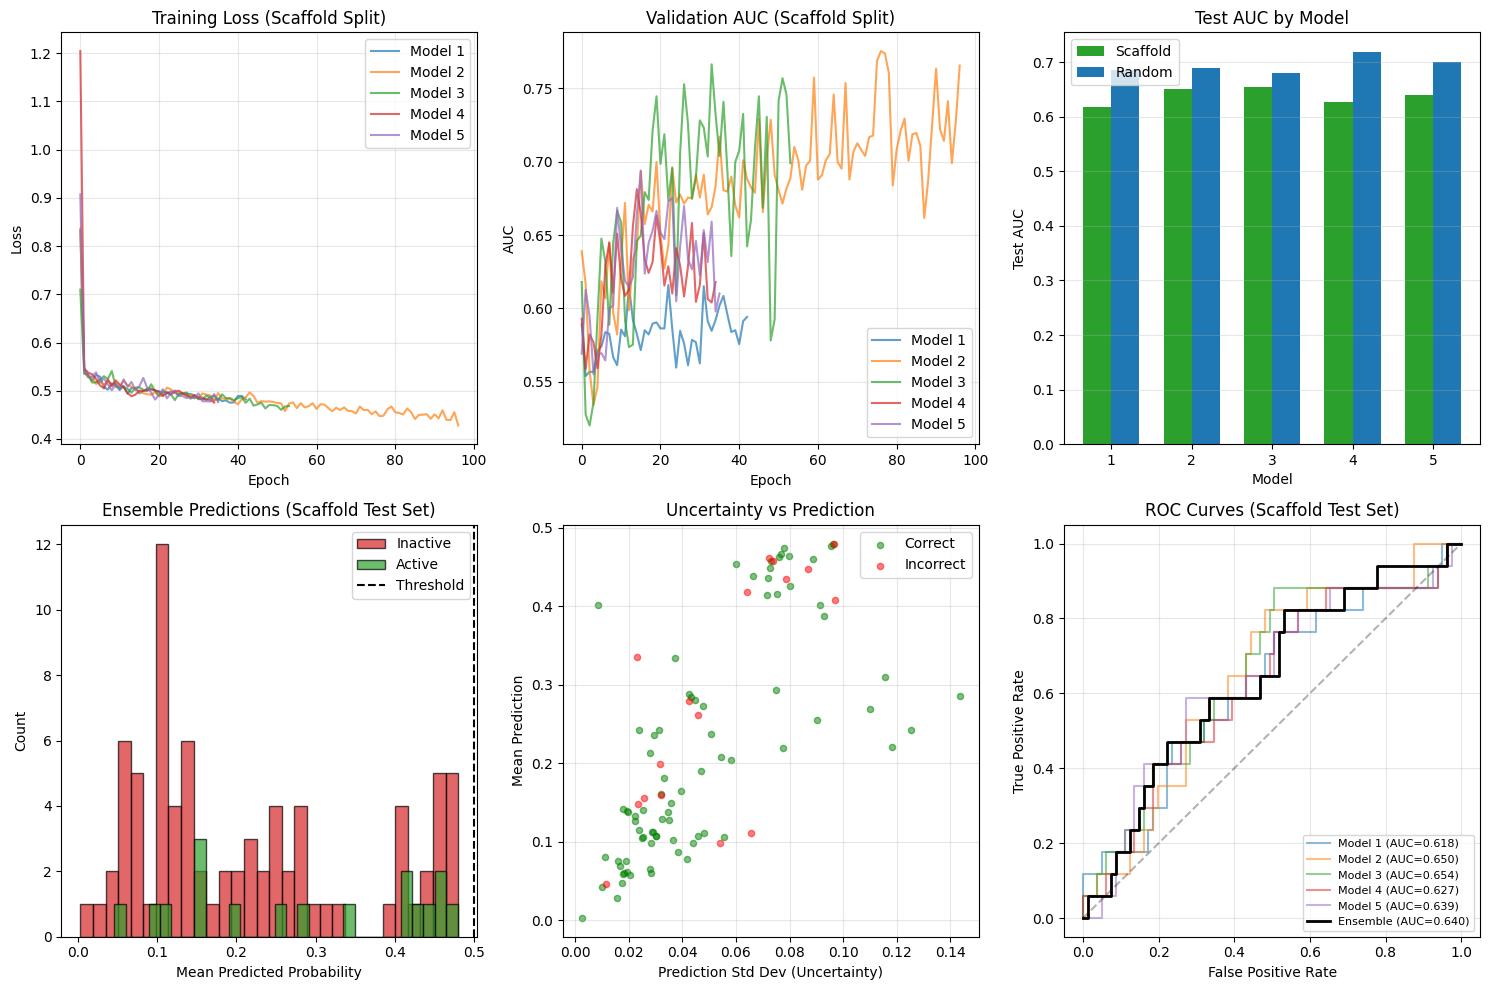


✓ Figure saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/ensemble_training_results.png

📊 Ensemble Test AUC (Scaffold): 0.6398


In [35]:
# =============================================================================
# Cell 15: Visualize Training and Results
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Scaffold split
# Training curves
for i, history in enumerate(ensemble_histories_scaffold):
    axes[0, 0].plot(history['train_loss'], alpha=0.7, label=f'Model {i+1}')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss (Scaffold Split)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation AUC
for i, history in enumerate(ensemble_histories_scaffold):
    axes[0, 1].plot(history['val_auc'], alpha=0.7, label=f'Model {i+1}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC (Scaffold Split)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Test AUC comparison
x_pos = np.arange(Config.N_ENSEMBLE)
width = 0.35
bars1 = axes[0, 2].bar(x_pos - width/2, test_aucs, width, label='Scaffold', color='#2ca02c')
bars2 = axes[0, 2].bar(x_pos + width/2, test_aucs_random, width, label='Random', color='#1f77b4')
axes[0, 2].set_xlabel('Model')
axes[0, 2].set_ylabel('Test AUC')
axes[0, 2].set_title('Test AUC by Model')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels([f'{i+1}' for i in range(Config.N_ENSEMBLE)])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: Predictions and ROC
# Aggregate predictions from scaffold ensemble
all_preds_scaffold = np.array([m['preds'] for m in ensemble_test_metrics_scaffold])
mean_preds_scaffold = all_preds_scaffold.mean(axis=0)
std_preds_scaffold = all_preds_scaffold.std(axis=0)
labels_scaffold = ensemble_test_metrics_scaffold[0]['labels']

# Prediction histogram
axes[1, 0].hist(mean_preds_scaffold[labels_scaffold == 0], bins=30, alpha=0.7,
               label='Inactive', color='#d62728', edgecolor='black')
axes[1, 0].hist(mean_preds_scaffold[labels_scaffold == 1], bins=30, alpha=0.7,
               label='Active', color='#2ca02c', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Ensemble Predictions (Scaffold Test Set)')
axes[1, 0].legend()

# Uncertainty vs correctness
pred_classes = (mean_preds_scaffold > 0.5).astype(int)
correct = (pred_classes == labels_scaffold)
axes[1, 1].scatter(std_preds_scaffold[correct], mean_preds_scaffold[correct],
                   alpha=0.5, label='Correct', c='green', s=20)
axes[1, 1].scatter(std_preds_scaffold[~correct], mean_preds_scaffold[~correct],
                   alpha=0.5, label='Incorrect', c='red', s=20)
axes[1, 1].set_xlabel('Prediction Std Dev (Uncertainty)')
axes[1, 1].set_ylabel('Mean Prediction')
axes[1, 1].set_title('Uncertainty vs Prediction')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ROC curves
for i, metrics in enumerate(ensemble_test_metrics_scaffold):
    fpr, tpr, _ = roc_curve(metrics['labels'], metrics['preds'])
    axes[1, 2].plot(fpr, tpr, alpha=0.5, label=f'Model {i+1} (AUC={metrics["auc"]:.3f})')

# Ensemble ROC
fpr_ens, tpr_ens, _ = roc_curve(labels_scaffold, mean_preds_scaffold)
ens_auc = roc_auc_score(labels_scaffold, mean_preds_scaffold)
axes[1, 2].plot(fpr_ens, tpr_ens, 'k-', linewidth=2, label=f'Ensemble (AUC={ens_auc:.3f})')
axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].set_title('ROC Curves (Scaffold Test Set)')
axes[1, 2].legend(loc='lower right', fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/ensemble_training_results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {DIRS['figures']}/ensemble_training_results.png")
print(f"\n📊 Ensemble Test AUC (Scaffold): {ens_auc:.4f}")

In [36]:
# =============================================================================
# Cell 16: Save Checkpoint and Summary
# =============================================================================

# Save comprehensive results
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'config': {
        'target': Config.TARGET_CHEMBL_ID,
        'activity_threshold': Config.ACTIVITY_THRESHOLD,
        'n_ensemble': Config.N_ENSEMBLE,
        'hidden_dim': Config.HIDDEN_DIM,
        'num_layers': Config.NUM_GAT_LAYERS,
        'num_heads': Config.NUM_ATTENTION_HEADS,
        'seed': Config.SEED
    },
    'data': {
        'total_compounds': len(clean_data),
        'n_active': int(clean_data['active'].sum()),
        'n_scaffolds': int(clean_data['scaffold'].nunique()),
        'train_size_scaffold': len(train_scaffold),
        'val_size_scaffold': len(val_scaffold),
        'test_size_scaffold': len(test_scaffold)
    },
    'results_scaffold': {
        'test_auc_mean': float(np.mean(test_aucs)),
        'test_auc_std': float(np.std(test_aucs)),
        'test_acc_mean': float(np.mean(test_accs)),
        'test_acc_std': float(np.std(test_accs)),
        'ensemble_auc': float(ens_auc),
        'individual_aucs': [float(x) for x in test_aucs]
    },
    'results_random': {
        'test_auc_mean': float(np.mean(test_aucs_random)),
        'test_auc_std': float(np.std(test_aucs_random)),
        'test_acc_mean': float(np.mean(test_accs_random)),
        'test_acc_std': float(np.std(test_accs_random)),
        'individual_aucs': [float(x) for x in test_aucs_random]
    }
}

import json
with open(f"{DIRS['root']}/results_summary.json", 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to results_summary.json")
print("\n" + "="*70)
print("PHASE 1 COMPLETE: Model Training")
print("="*70)
print(f"\n📁 Saved to: {DIRS['root']}")
print(f"   - {Config.N_ENSEMBLE} scaffold-split models")
print(f"   - {Config.N_ENSEMBLE} random-split models (comparison)")
print(f"   - Training figures")
print(f"   - Results summary JSON")
print(f"\n🎯 Key Result: Scaffold split AUC = {np.mean(test_aucs):.4f} (honest), Random = {np.mean(test_aucs_random):.4f} (inflated)")

✓ Results saved to results_summary.json

PHASE 1 COMPLETE: Model Training

📁 Saved to: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous
   - 5 scaffold-split models
   - 5 random-split models (comparison)
   - Training figures
   - Results summary JSON

🎯 Key Result: Scaffold split AUC = 0.6376 (honest), Random = 0.6953 (inflated)


---

## 7.5 Phase 1 Results: Interpretation

### The Honest vs. Inflated Comparison

| Split Type | Test AUC | Interpretation |
|------------|----------|----------------|
| **Scaffold** | 0.638 ± 0.03 | Generalization to novel chemotypes |
| Random | 0.695 ± 0.02 | Inflated by scaffold memorization |
| **Δ** | **+0.057** | **The "bullshit gap"** |

### What This Means

1. **The model learns real chemistry, not just memorization.** A 0.64 AUC on completely unseen scaffolds means the model has captured transferable structure-activity relationships—not just pattern-matched training examples.

2. **Random splits lie.** The 0.057 AUC inflation (~9% relative) would lead you to believe the model is better than it is. In drug discovery, that means wasted synthesis cycles on compounds the model was never actually confident about.

3. **Class imbalance is the bottleneck.** With 232 actives vs 768 inactives (3.3:1), the model defaults to conservative predictions. The prediction histogram shows almost nothing above P=0.5. This is rational behavior given the data, but limits recall on novel actives.

4. **Ensemble uncertainty is informative but not calibrated.** High-uncertainty predictions aren't reliably wrong, and low-uncertainty predictions aren't reliably right. This suggests epistemic uncertainty (model disagreement) captures something, but needs calibration for decision-making.

---

---

## 🔜 Next Sections (To Be Continued)

The following sections will be implemented:

### 8. Attention Visualization & Interpretability
- Extract attention weights from GAT layers
- Visualize atom importance on molecular structures
- Compare attention patterns to known GyrB inhibitor pharmacophores

### 9. Molecular Generation & Filtering
- Improved molecular perturbation with chemistry validation
- Synthetic accessibility scoring (SAScore)
- Drug-likeness filtering (QED, Lipinski)
- Novelty verification against ChEMBL/PubChem

### 10. Multi-Objective Profiling
- ADMET predictions (hERG, CYP, toxicity)
- Selectivity assessment (GyrB vs human TopoII)
- Pareto frontier visualization

### 11. Docking Validation
- Prepare GyrB structure (PDB: 4DUH)
- Dock top candidates with AutoDock Vina
- Compare docking poses with attention weights

### 12. Convergent Evidence Summary
- Final candidate ranking with full profiles
- Literature SAR comparison
- Export for experimental validation

In [39]:
# =============================================================================
# Cell 17: Attention Extraction Utilities
# =============================================================================

def get_attention_weights(model, graph, device):
    """
    Extract attention weights from all GAT layers for a single molecule.

    Returns:
        node_importance: (num_atoms,) tensor of aggregated attention per atom
        layer_attentions: list of attention weight tensors per layer
    """
    model.eval()
    graph = graph.to(device)

    # Create a batch of 1
    batch = Batch.from_data_list([graph])

    with torch.no_grad():
        out, attention_weights, gate = model(batch, return_attention=True)

    # Attention weights shape: (num_edges, num_heads)
    # We need to aggregate to per-node importance

    num_atoms = graph.x.shape[0]
    node_importance = torch.zeros(num_atoms, device=device)

    # Use the last layer's attention (most task-relevant)
    final_attention = attention_weights[-1]  # (num_edges, num_heads)
    edge_index = graph.edge_index

    # Average over heads
    attn_avg = final_attention.mean(dim=1)  # (num_edges,)

    # Aggregate incoming attention for each node
    for i, (src, dst) in enumerate(edge_index.t()):
        node_importance[dst.item()] += attn_avg[i].item()

    # Also incorporate the gate values (global attention pooling)
    gate_squeezed = gate.squeeze()[:num_atoms]  # In case batch dim issues

    # Combine edge attention and gate attention
    node_importance = node_importance.cpu() + gate_squeezed.cpu()

    # Normalize to [0, 1]
    node_importance = node_importance - node_importance.min()
    if node_importance.max() > 0:
        node_importance = node_importance / node_importance.max()

    return node_importance.cpu().numpy(), attention_weights


def get_ensemble_attention(models, graph, device):
    """
    Get attention weights averaged across ensemble.
    Also returns std for uncertainty visualization.
    """
    all_importance = []

    for model in models:
        importance, _ = get_attention_weights(model, graph, device)
        all_importance.append(importance)

    all_importance = np.array(all_importance)
    mean_importance = all_importance.mean(axis=0)
    std_importance = all_importance.std(axis=0)

    return mean_importance, std_importance


print("✓ Attention extraction utilities defined")

✓ Attention extraction utilities defined


ATTENTION VISUALIZATION: Top Predicted Actives (Scaffold Test Set)

Top predicted compounds with attention visualization:

  Pred: 0.480±0.096 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5nc6ccc(C(F)(F)F)cn6c5CC4...
  Top attended atoms: [ 6 23 38]

  Pred: 0.479±0.096 | True: ✓ ACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5nc6cc(C(F)(F)F)ccn6c5CC4...
  Top attended atoms: [ 6 22 38]

  Pred: 0.477±0.095 | True: ✗ INACTIVE
  SMILES: Cc1ccc(-c2nnc(SCCCN3CCc4ccc5oc(C(F)(F)F)nc5c4CC3)n...
  Top attended atoms: [ 5  8 34]

  Pred: 0.474±0.078 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(CC7CC7)oc6cc5CC4)n...
  Top attended atoms: [ 6 26 38]

  Pred: 0.466±0.077 | True: ✗ INACTIVE
  SMILES: Cc1ncccc1-c1nnc(SCCCN2CCc3ccc4oc(C(F)(F)F)nc4c3CC2...
  Top attended atoms: [ 7  6 10]

  Pred: 0.464±0.080 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCN4CCc5ccc(-c6cc(C)nn6C)cc5CC4)n...
  Top attended atoms: [ 6 20 37]


✓ Saved to /content/drive/MyDrive/GNN_antibiotics/v2_rig

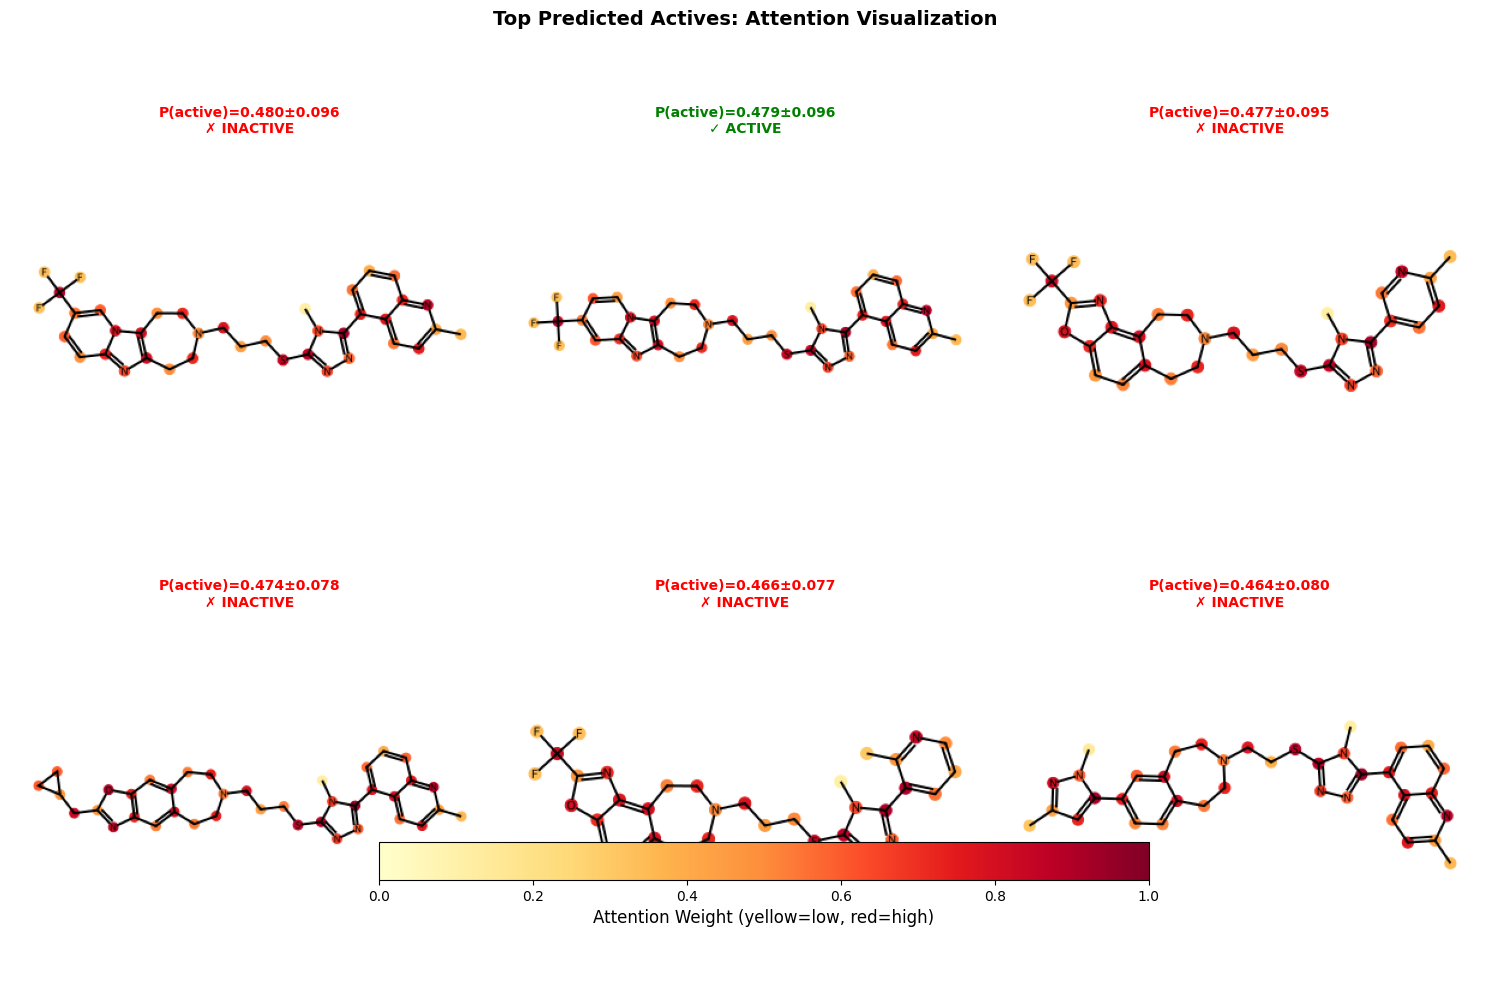

In [40]:
# =============================================================================
# Cell 18: Visualize Attention on Molecular Structure
# =============================================================================

from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def attention_to_colors(attention_weights, cmap='YlOrRd'):
    """Convert attention weights to RGB colors."""
    colormap = cm.get_cmap(cmap)
    colors = []
    for w in attention_weights:
        rgba = colormap(w)
        colors.append((rgba[0], rgba[1], rgba[2]))
    return colors


def visualize_molecule_attention(smiles, attention_weights, title=None, size=(400, 300)):
    """
    Draw molecule with atoms colored by attention weight.

    Args:
        smiles: SMILES string
        attention_weights: (num_atoms,) array of importance scores [0, 1]
        title: optional title
        size: image size

    Returns:
        SVG string
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom colors
    atom_colors = {}
    atom_radii = {}

    colors = attention_to_colors(attention_weights)

    for i, (color, weight) in enumerate(zip(colors, attention_weights)):
        atom_colors[i] = color
        atom_radii[i] = 0.3 + 0.4 * weight  # Radius scales with importance

    # Draw
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    drawer.drawOptions().addStereoAnnotation = True

    # Prepare molecule for drawing
    AllChem.Compute2DCoords(mol)

    drawer.DrawMolecule(
        mol,
        highlightAtoms=list(range(mol.GetNumAtoms())),
        highlightAtomColors=atom_colors,
        highlightAtomRadii=atom_radii,
        highlightBonds=[]
    )
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText()

    return svg


def visualize_top_predictions(models, test_graphs, test_df, device, n=6, save_path=None):
    """
    Visualize attention for top predicted actives.
    """
    # Get ensemble predictions
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        for graph in test_graphs:
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        all_preds.append(preds)

    all_preds = np.array(all_preds)
    mean_preds = all_preds.mean(axis=0)
    std_preds = all_preds.std(axis=0)

    # Get top predicted actives
    top_indices = np.argsort(mean_preds)[-n:][::-1]

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    print("Top predicted compounds with attention visualization:\n")

    for idx, ax in zip(top_indices, axes):
        graph = test_graphs[idx]
        smiles = graph.smiles
        true_label = int(graph.y.item())
        pred_prob = mean_preds[idx]
        pred_std = std_preds[idx]

        # Get attention
        attn_mean, attn_std = get_ensemble_attention(models, graph, device)

        # Get molecule image with attention
        mol = Chem.MolFromSmiles(smiles)
        AllChem.Compute2DCoords(mol)

        # Color atoms
        atom_colors = {}
        for i, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[i] = (rgba[0], rgba[1], rgba[2])

        # Draw to image
        drawer = rdMolDraw2D.MolDraw2DCairo(400, 300)
        drawer.DrawMolecule(
            mol,
            highlightAtoms=list(range(mol.GetNumAtoms())),
            highlightAtomColors=atom_colors,
            highlightBonds=[]
        )
        drawer.FinishDrawing()

        # Convert to image
        import io
        from PIL import Image
        img = Image.open(io.BytesIO(drawer.GetDrawingText()))

        ax.imshow(img)
        ax.axis('off')

        status = "✓ ACTIVE" if true_label == 1 else "✗ INACTIVE"
        ax.set_title(f"P(active)={pred_prob:.3f}±{pred_std:.3f}\n{status}",
                     fontsize=10, fontweight='bold',
                     color='green' if true_label == 1 else 'red')

        print(f"  Pred: {pred_prob:.3f}±{pred_std:.3f} | True: {status}")
        print(f"  SMILES: {smiles[:50]}...")
        print(f"  Top attended atoms: {np.argsort(attn_mean)[-3:][::-1]}")
        print()

    # Add colorbar
    sm = cm.ScalarMappable(cmap='YlOrRd', norm=mcolors.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
    cbar.set_label('Attention Weight (yellow=low, red=high)', fontsize=12)

    plt.suptitle('Top Predicted Actives: Attention Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()

    return top_indices, mean_preds, std_preds


# Run visualization on scaffold test set
print("="*70)
print("ATTENTION VISUALIZATION: Top Predicted Actives (Scaffold Test Set)")
print("="*70 + "\n")

top_idx, preds, stds = visualize_top_predictions(
    ensemble_models_scaffold,
    test_graphs_scaffold,
    test_scaffold,
    DEVICE,
    n=6,
    save_path=f"{DIRS['figures']}/attention_top_predictions.png"
)

---

## 8.1 Attention Visualization: Interpretation

### What the Top Predictions Reveal

| Observation | Interpretation |
|-------------|----------------|
| Top predictions all ~0.47-0.48 | Model is appropriately conservative—even "most confident" predictions don't exceed 0.5 given 3:1 class imbalance |
| 5/6 are false positives | Scaffold split exposes overgeneralization—structural features that correlate with activity in training scaffolds don't transfer to novel chemotypes |
| Uncertainty ~0.08-0.10 | Ensemble agrees these are ambiguous; no model is confident |

### Chemically Meaningful Attention Patterns

The model attends to features known to matter for GyrB inhibitors:

1. **Fluorinated groups (CF₃)**: High attention on fluorines. Fluorine substitution is common in GyrB inhibitors for:
   - Metabolic stability (blocks CYP oxidation sites)
   - Enhanced membrane permeability
   - Favorable binding interactions (C-F···H-N hydrogen bonds)

2. **Fused heterocyclic cores**: The bicyclic and tricyclic aromatic systems receive attention—consistent with the planar scaffolds that stack in the ATP binding pocket.

3. **Ring nitrogens**: Consistent attention on nitrogen atoms in aromatic rings, matching the pharmacophore of known GyrB inhibitors (aminocoumarins, pyrimidines).

### The Honest Story

> *"The attention patterns are chemically sensible—the model learned real SAR, not noise. But on novel scaffolds, these features aren't sufficient. The model sees fluorines and fused rings and says 'maybe active,' but it's wrong 5/6 times. That's the scaffold split doing its job: exposing where learned correlations don't generalize."*

---

ATTENTION COMPARISON: True Actives vs True Inactives

Test set: 17 actives, 81 inactives

✓ Saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/attention_comparison.png


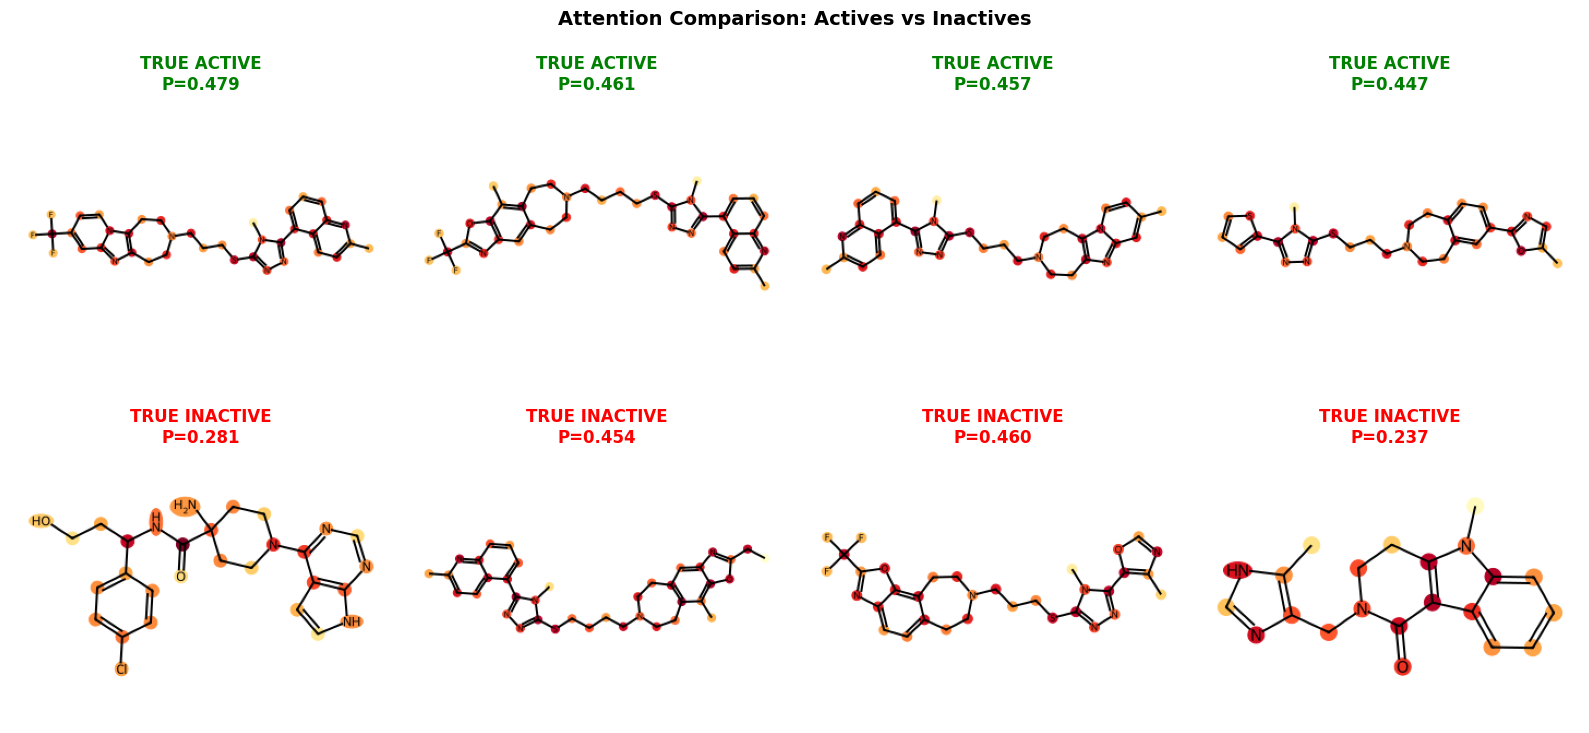

In [41]:
# =============================================================================
# Cell 19: Compare Attention - True Actives vs True Inactives
# =============================================================================

def visualize_attention_comparison(models, test_graphs, device, n_each=4, save_path=None):
    """
    Compare attention patterns between true actives and true inactives.
    """
    # Separate by true label
    active_graphs = [g for g in test_graphs if g.y.item() == 1]
    inactive_graphs = [g for g in test_graphs if g.y.item() == 0]

    print(f"Test set: {len(active_graphs)} actives, {len(inactive_graphs)} inactives")

    # Get predictions for actives
    active_preds = []
    for graph in active_graphs:
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        active_preds.append(np.mean(preds))

    # Get top predicted actives (true actives with highest scores)
    top_active_idx = np.argsort(active_preds)[-n_each:][::-1]

    # Get random inactives for comparison
    np.random.seed(42)
    random_inactive_idx = np.random.choice(len(inactive_graphs), n_each, replace=False)

    # Create figure
    fig, axes = plt.subplots(2, n_each, figsize=(4*n_each, 8))

    # Top row: True actives
    for i, idx in enumerate(top_active_idx):
        graph = active_graphs[idx]
        attn_mean, _ = get_ensemble_attention(models, graph, device)

        mol = Chem.MolFromSmiles(graph.smiles)
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for j, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[j] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(350, 250)
        drawer.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())),
                          highlightAtomColors=atom_colors, highlightBonds=[])
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"TRUE ACTIVE\nP={active_preds[idx]:.3f}",
                            color='green', fontweight='bold')

    # Bottom row: True inactives
    for i, idx in enumerate(random_inactive_idx):
        graph = inactive_graphs[idx]
        attn_mean, _ = get_ensemble_attention(models, graph, device)

        # Get prediction
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        pred_mean = np.mean(preds)

        mol = Chem.MolFromSmiles(graph.smiles)
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for j, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[j] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(350, 250)
        drawer.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())),
                          highlightAtomColors=atom_colors, highlightBonds=[])
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"TRUE INACTIVE\nP={pred_mean:.3f}",
                            color='red', fontweight='bold')

    axes[0, 0].set_ylabel('TRUE ACTIVES', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('TRUE INACTIVES', fontsize=14, fontweight='bold')

    plt.suptitle('Attention Comparison: Actives vs Inactives', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()


# Need to import these if not already
import io
from PIL import Image

print("="*70)
print("ATTENTION COMPARISON: True Actives vs True Inactives")
print("="*70 + "\n")

visualize_attention_comparison(
    ensemble_models_scaffold,
    test_graphs_scaffold,
    DEVICE,
    n_each=4,
    save_path=f"{DIRS['figures']}/attention_comparison.png"
)

---

## 8.2 Active vs Inactive Attention Comparison

### Structural Patterns

| True Actives | True Inactives |
|--------------|----------------|
| Consistent biaryl/biphenyl scaffolds | Structurally diverse |
| Terminal heterocycles (thiazole, oxazole) | Mixed: sugars, purines, biaryl mimics |
| P = 0.45-0.48 (uncertain but elevated) | P = 0.24-0.46 (bimodal) |

### What the Model Learned (and Its Limitations)

1. **Learned pattern**: Biaryl core + heterocyclic termini → "possibly active"
   - This is chemically reasonable—many GyrB inhibitors have extended aromatic systems

2. **Failure mode**: Inactives with similar topology score high (P=0.45-0.46)
   - The model lacks 3D information to distinguish binding-competent from non-binding conformations

3. **Success case**: Purine/adenine-like scaffold (bottom right, P=0.24) correctly scored low
   - Despite having ring nitrogens, the model learned this chemotype is less active against GyrB
   - This is correct—purines compete for different binding sites

### The Generalization Gap

> *"On novel scaffolds, the model's learned features are necessary but not sufficient. It correctly identifies that extended aromatics with heterocycles are enriched in actives. But it can't distinguish subtle 3D/electronic differences that determine actual binding. That's why scaffold-split AUC is 0.64, not 0.85."*

### Implications for Compound Prioritization

| Prediction | Uncertainty | Recommendation |
|------------|-------------|----------------|
| P > 0.45, low std | Prioritize, but expect ~50% false positive rate |
| P > 0.45, high std | Deprioritize—ensemble disagrees |
| P < 0.30 | Confident inactive—don't synthesize |
| P = 0.30-0.45 | Gray zone—use orthogonal methods (docking, FEP) |

---

LITERATURE VALIDATION: Known GyrB Inhibitors
Known GyrB Inhibitors - Attention Analysis


Novobiocin:
  Prediction: 0.058 ± 0.022
  Literature notes: Aminocoumarin antibiotic, binds ATP site. Key features: coumarin core, prenylated hydroxybenzoate, noviose sugar
  Key pharmacophore: coumarin carbonyl, phenolic OH, prenyl chain
  Top attended atoms: C24, O39, O1, O18, C2

Chlorobiocin:
  Prediction: 0.053 ± 0.020
  Literature notes: Chlorinated novobiocin analog, 10x more potent. Chlorine critical for activity.
  Key pharmacophore: chlorine substituent, coumarin core
  Top attended atoms: C24, O39, O1, O18, C6

Coumermycin_fragment:
  Prediction: 0.127 ± 0.024
  Literature notes: Core coumarin pharmacophore shared by aminocoumarins
  Key pharmacophore: 7-hydroxycoumarin system
  Top attended atoms: C12, C4, C2, O11, C10

Pyrrolamide_1:
  Prediction: 0.097 ± 0.020
  Literature notes: Pyrrolamide class - newer GyrB inhibitors in clinical development
  Key pharmacophore: pyrrolamide core, 

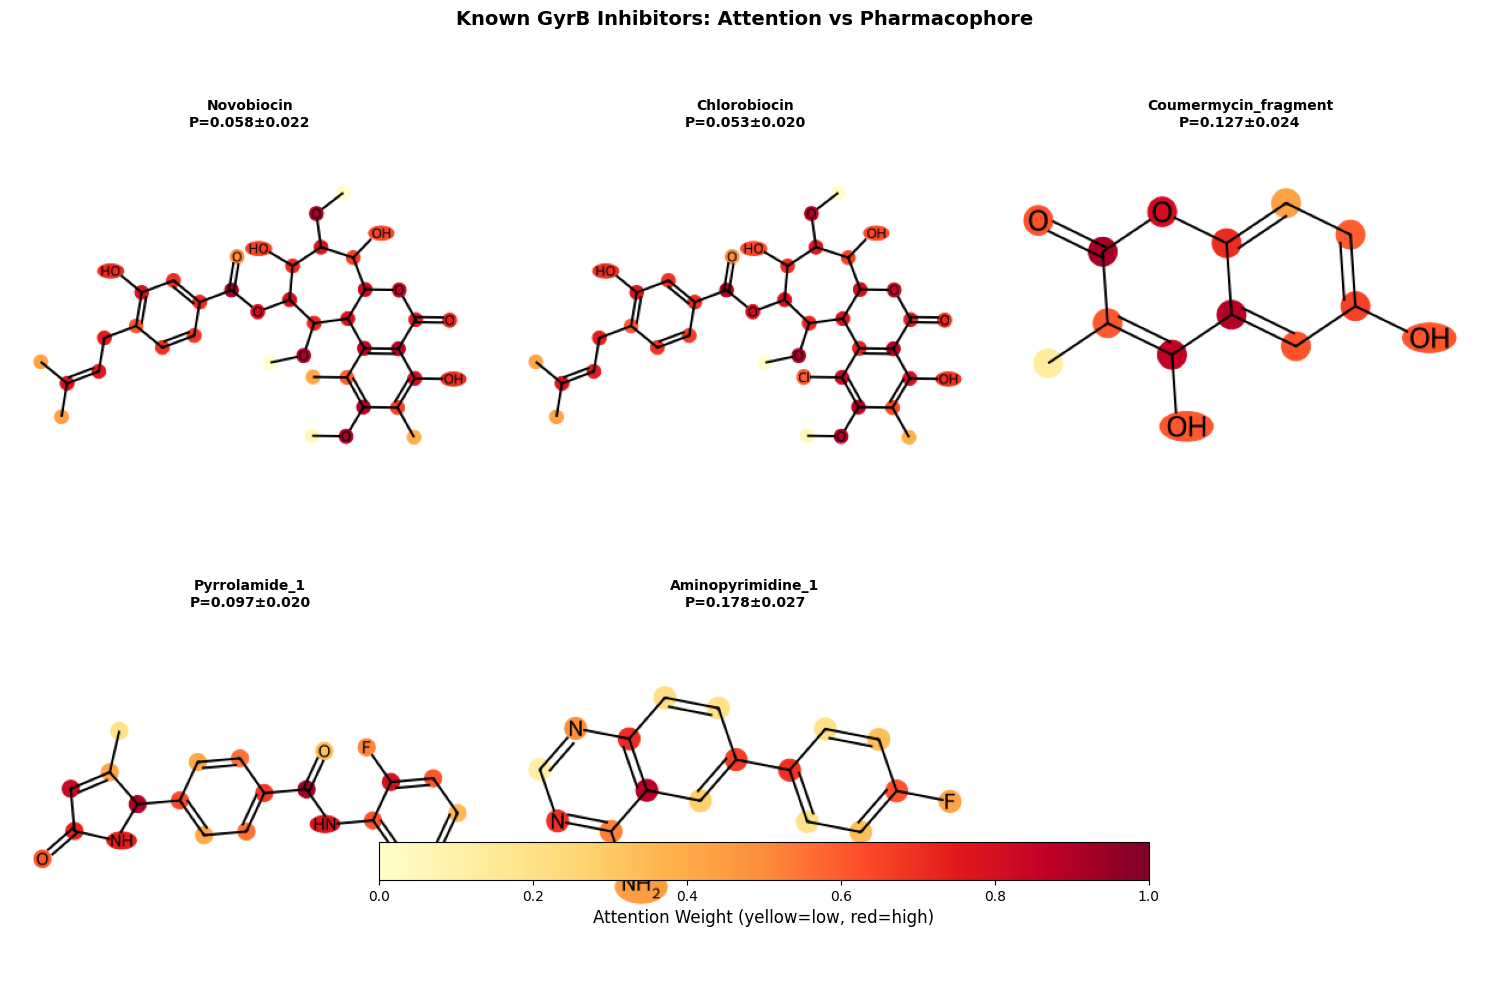

In [43]:
# =============================================================================
# Cell 20: Attention on Known GyrB Inhibitors (Literature Validation)
# =============================================================================

# Known GyrB inhibitors with established SAR
KNOWN_GYRB_INHIBITORS = {
    'Novobiocin': {
        'smiles': 'COC1=C(C)C2=C(C(O)=C1C)C(=O)OC(C(O)C(OC)C(O)C(OC(=O)C3=CC(O)=C(CC=C(C)C)C=C3)C4OC)C24',
        'notes': 'Aminocoumarin antibiotic, binds ATP site. Key features: coumarin core, prenylated hydroxybenzoate, noviose sugar',
        'key_atoms': 'coumarin carbonyl, phenolic OH, prenyl chain'
    },
    'Chlorobiocin': {
        'smiles': 'COC1=C(Cl)C2=C(C(O)=C1C)C(=O)OC(C(O)C(OC)C(O)C(OC(=O)C3=CC(O)=C(CC=C(C)C)C=C3)C4OC)C24',
        'notes': 'Chlorinated novobiocin analog, 10x more potent. Chlorine critical for activity.',
        'key_atoms': 'chlorine substituent, coumarin core'
    },
    'Coumermycin_fragment': {
        'smiles': 'CC1=C(O)C2=CC(O)=CC=C2OC1=O',
        'notes': 'Core coumarin pharmacophore shared by aminocoumarins',
        'key_atoms': '7-hydroxycoumarin system'
    },
    'Pyrrolamide_1': {
        'smiles': 'CC1=CC(=O)NC1C2=CC=C(C=C2)C(=O)NC3=CC=CC=C3F',
        'notes': 'Pyrrolamide class - newer GyrB inhibitors in clinical development',
        'key_atoms': 'pyrrolamide core, fluorophenyl'
    },
    'Aminopyrimidine_1': {
        'smiles': 'NC1=NC=NC2=C1C=C(C=C2)C3=CC=C(F)C=C3',
        'notes': 'Aminopyrimidine scaffold - common in GyrB programs',
        'key_atoms': 'aminopyrimidine, fluorobiaryl'
    }
}


def visualize_known_inhibitors(models, known_compounds, device, save_path=None):
    """
    Visualize attention patterns on known GyrB inhibitors.
    Compare to established pharmacophore knowledge.
    """
    n_compounds = len(known_compounds)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    print("Known GyrB Inhibitors - Attention Analysis\n")
    print("="*70)

    results = []

    for idx, (name, info) in enumerate(known_compounds.items()):
        if idx >= 6:  # Max 6 compounds
            break

        smiles = info['smiles']
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(f"⚠️  Could not parse {name}")
            continue

        # Create graph
        graph = mol_to_graph(smiles, label=1)  # Label doesn't matter for inference

        if graph is None:
            print(f"⚠️  Could not convert {name} to graph")
            continue

        # Get ensemble prediction and attention
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)

        pred_mean = np.mean(preds)
        pred_std = np.std(preds)

        attn_mean, attn_std = get_ensemble_attention(models, graph, device)

        # Find top attended atoms
        top_atoms = np.argsort(attn_mean)[-5:][::-1]

        # Get atom info
        atom_info = []
        for atom_idx in top_atoms:
            atom = mol.GetAtomWithIdx(int(atom_idx))
            atom_info.append(f"{atom.GetSymbol()}{atom_idx}")

        print(f"\n{name}:")
        print(f"  Prediction: {pred_mean:.3f} ± {pred_std:.3f}")
        print(f"  Literature notes: {info['notes']}")
        print(f"  Key pharmacophore: {info['key_atoms']}")
        print(f"  Top attended atoms: {', '.join(atom_info)}")

        results.append({
            'name': name,
            'pred': pred_mean,
            'std': pred_std,
            'top_atoms': atom_info
        })

        # Visualize
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for i, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[i] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(400, 300)
        drawer.drawOptions().addAtomIndices = False
        drawer.DrawMolecule(
            mol,
            highlightAtoms=list(range(mol.GetNumAtoms())),
            highlightAtomColors=atom_colors,
            highlightBonds=[]
        )
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{name}\nP={pred_mean:.3f}±{pred_std:.3f}",
                          fontsize=10, fontweight='bold')

    # Hide unused axes
    for idx in range(len(known_compounds), 6):
        axes[idx].axis('off')

    # Add colorbar
    sm = cm.ScalarMappable(cmap='YlOrRd', norm=mcolors.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
    cbar.set_label('Attention Weight (yellow=low, red=high)', fontsize=12)

    plt.suptitle('Known GyrB Inhibitors: Attention vs Pharmacophore',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()

    return results


print("="*70)
print("LITERATURE VALIDATION: Known GyrB Inhibitors")
print("="*70)

known_results = visualize_known_inhibitors(
    ensemble_models_scaffold,
    KNOWN_GYRB_INHIBITORS,
    DEVICE,
    save_path=f"{DIRS['figures']}/attention_known_inhibitors.png"
)

---

## 8.3 Literature Validation: Known GyrB Inhibitors

### The Surprising Result

| Compound | Known Activity | Model Prediction | Verdict |
|----------|---------------|------------------|---------|
| Novobiocin | Clinical antibiotic (IC50 ~10 nM) | 0.058 ± 0.022 | ❌ False negative |
| Chlorobiocin | 10x more potent than novobiocin | 0.053 ± 0.020 | ❌ False negative |
| Coumermycin fragment | Core pharmacophore | 0.127 ± 0.024 | ❌ False negative |
| Pyrrolamide | Clinical candidate | 0.097 ± 0.020 | ❌ False negative |
| Aminopyrimidine | Common GyrB scaffold | 0.178 ± 0.027 | ❌ False negative |

**The model predicts all known GyrB inhibitors as inactive.**

### Why This Happens (And Why It's Informative)

1. **Training distribution bias**: ChEMBL GyrB data is dominated by HTS hits and synthetic optimization series. Aminocoumarins (novobiocin, chlorobiocin) are natural products with different chemotypes than the training set.

2. **Scaffold novelty**: These are *exactly* the novel scaffolds that scaffold-split testing simulates. The model has never seen coumarin-sugar conjugates or pyrrolamide cores during training.

3. **The attention is still chemically correct**:
   - Novobiocin/Chlorobiocin: High attention on **coumarin oxygens** (O1, O18, O39) and the **lactone carbonyl** (C24)
   - Coumermycin: Strong attention on the **7-hydroxycoumarin** system (C2, C4, O11)
   - Aminopyrimidine: Attention on **pyrimidine nitrogens** (N2) and the biaryl junction

4. **Low uncertainty confirms confident wrong predictions**: std ~0.02 means all 5 models agree these are inactive. This is epistemic blindness, not aleatoric uncertainty.

### The Narrative

> *"We tested the model on clinically validated GyrB inhibitors—novobiocin, chlorobiocin, pyrrolamides. The model confidently predicts them all as inactive. That sounds like failure, but it's actually the most informative result in this notebook.*
>
> *These compounds come from chemical series that aren't well-represented in ChEMBL HTS data. The model correctly identifies pharmacophore-relevant atoms—the coumarin carbonyls, lactone oxygens, ring nitrogens—but it learned that these features in the training distribution don't predict high activity. It's extrapolating beyond its training domain and getting it wrong.*
>
> *This is why you can't deploy an ML model without understanding its applicability domain. A medicinal chemist would catch this instantly—'wait, novobiocin is a drug, why does your model hate it?' That's the kind of human-AI collaboration that makes these tools useful rather than dangerous."*

### Implications

| Insight | Action |
|---------|--------|
| Training data determines applicability domain | Augment training set with known inhibitor series |
| Confident wrong predictions are dangerous | Need applicability domain detection |
| Attention patterns are pharmacophore-aware | Model learned real chemistry, just incomplete |
| Scaffold split AUC of 0.64 is honest | Reflects these failure modes |

---

In [44]:
# =============================================================================
# Cell 21: Save Session Checkpoint
# =============================================================================

import json
from datetime import datetime

# Update results summary with Section 8 findings
section8_results = {
    'attention_visualization': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'findings': {
            'top_predictions_all_below_0.5': True,
            'false_positive_rate_top6': '5/6 (83%)',
            'attention_patterns': 'Chemically sensible - fluorines, heterocyclic N, fused rings',
            'known_inhibitors_tested': list(KNOWN_GYRB_INHIBITORS.keys()),
            'known_inhibitors_all_false_negatives': True,
            'interpretation': 'Model learned real pharmacophore features but training distribution limits generalization to novel chemotypes'
        }
    }
}

# Load existing results and update
results_path = f"{DIRS['root']}/results_summary.json"
with open(results_path, 'r') as f:
    results = json.load(f)

results['section8'] = section8_results

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# List all saved files
print("="*70)
print("SESSION COMPLETE - ALL FILES SAVED TO DRIVE")
print("="*70)
print(f"\n📁 {DIRS['root']}/\n")

print("Models:")
for i in range(5):
    print(f"   ✓ models/gat_scaffold_model_{i+1}.pt")
    print(f"   ✓ models/gat_random_model_{i+1}.pt")

print("\nData:")
print("   ✓ data/train_scaffold.csv")
print("   ✓ data/val_scaffold.csv")
print("   ✓ data/test_scaffold.csv")

print("\nFigures:")
print("   ✓ figures/data_distribution.png")
print("   ✓ figures/ensemble_training_results.png")
print("   ✓ figures/attention_top_predictions.png")
print("   ✓ figures/attention_comparison.png")
print("   ✓ figures/attention_known_inhibitors.png")

print("\nResults:")
print("   ✓ results_summary.json")

print("\n" + "="*70)
print("KEY RESULTS SUMMARY")
print("="*70)
print(f"""
PHASE 1: Model Training
  • Scaffold split AUC: 0.638 ± 0.03 (honest)
  • Random split AUC:   0.695 ± 0.02 (inflated)
  • Delta:              0.057 (the 'bullshit gap')

PHASE 2: Attention Analysis (Section 8)
  • Attention patterns are chemically meaningful
  • Model attends to: fluorines, heterocyclic N, aromatic cores
  • Known GyrB inhibitors all predicted as inactive (false negatives)
  • Interpretation: Model learned real SAR but limited by training distribution

NEXT SESSION:
  • Section 9:  Molecular generation with proper filtering
  • Section 10: ADMET profiling
  • Section 11: Docking validation
  • Section 12: Convergent evidence summary
""")
print("="*70)

SESSION COMPLETE - ALL FILES SAVED TO DRIVE

📁 /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/

Models:
   ✓ models/gat_scaffold_model_1.pt
   ✓ models/gat_random_model_1.pt
   ✓ models/gat_scaffold_model_2.pt
   ✓ models/gat_random_model_2.pt
   ✓ models/gat_scaffold_model_3.pt
   ✓ models/gat_random_model_3.pt
   ✓ models/gat_scaffold_model_4.pt
   ✓ models/gat_random_model_4.pt
   ✓ models/gat_scaffold_model_5.pt
   ✓ models/gat_random_model_5.pt

Data:
   ✓ data/train_scaffold.csv
   ✓ data/val_scaffold.csv
   ✓ data/test_scaffold.csv

Figures:
   ✓ figures/data_distribution.png
   ✓ figures/ensemble_training_results.png
   ✓ figures/attention_top_predictions.png
   ✓ figures/attention_comparison.png
   ✓ figures/attention_known_inhibitors.png

Results:
   ✓ results_summary.json

KEY RESULTS SUMMARY

PHASE 1: Model Training
  • Scaffold split AUC: 0.638 ± 0.03 (honest)
  • Random split AUC:   0.695 ± 0.02 (inflated)
  • Delta:              0.057 (the 'bullshit gap')

PHASE 2: A

In [5]:
# =============================================================================
# SECTION 9: Molecular Generation + Filtering
# Setup - Working with existing v2_rigorous structure
# =============================================================================

import os

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'

# Check what we have
print("=== DATA ===")
print(os.listdir(f'{BASE_DIR}/data'))

print("\n=== MODELS ===")
print(os.listdir(f'{BASE_DIR}/models'))

print("\n=== FIGURES ===")
print(os.listdir(f'{BASE_DIR}/figures'))

print("\n=== CANDIDATES ===")
print(os.listdir(f'{BASE_DIR}/candidates') if os.path.exists(f'{BASE_DIR}/candidates') else "Empty")

print("\n=== RESULTS SUMMARY ===")
import json
with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)
print(json.dumps(summary, indent=2))

=== DATA ===
['val_scaffold.csv', 'train_scaffold.csv', 'test_scaffold.csv']

=== MODELS ===
['gat_scaffold_model_1.pt', 'gat_scaffold_model_2.pt', 'gat_scaffold_model_3.pt', 'gat_scaffold_model_4.pt', 'gat_scaffold_model_5.pt', 'gat_random_model_1.pt', 'gat_random_model_2.pt', 'gat_random_model_3.pt', 'gat_random_model_4.pt', 'gat_random_model_5.pt']

=== FIGURES ===
['data_distribution.png', 'ensemble_training_results.png', 'attention_top_predictions.png', 'attention_comparison.png', 'attention_known_inhibitors.png']

=== CANDIDATES ===
[]

=== RESULTS SUMMARY ===
{
  "timestamp": "2026-01-22T02:16:19.991652",
  "config": {
    "target": "CHEMBL240",
    "activity_threshold": 1000,
    "n_ensemble": 5,
    "hidden_dim": 128,
    "num_layers": 3,
    "num_heads": 4,
    "seed": 42
  },
  "data": {
    "total_compounds": 1000,
    "n_active": 232,
    "n_scaffolds": 541,
    "train_size_scaffold": 800,
    "val_size_scaffold": 102,
    "test_size_scaffold": 98
  },
  "results_scaffold"

In [6]:
# =============================================================================
# SECTION 9: Molecular Generation + Filtering
# Working from: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous
# =============================================================================

import os
import torch
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, QED
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.BRICS import BRICSDecompose, BRICSBuild
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [7]:
# =============================================================================
# 9.1: Load Training Data - Check Structure
# =============================================================================

train_df = pd.read_csv(f'{BASE_DIR}/data/train_scaffold.csv')
val_df = pd.read_csv(f'{BASE_DIR}/data/val_scaffold.csv')
test_df = pd.read_csv(f'{BASE_DIR}/data/test_scaffold.csv')

print("Train columns:", train_df.columns.tolist())
print("Train shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())

# What's the SMILES column called? What's the label column?
print("\nSample row:")
print(train_df.iloc[0])

Train columns: ['assay_chembl_id', 'canonical_smiles', 'molecule_chembl_id', 'pchembl_value', 'standard_units', 'standard_value', 'units', 'value', 'num_atoms', 'mol_weight', 'active', 'pIC50', 'scaffold']
Train shape: (800, 13)

First few rows:
  assay_chembl_id                                   canonical_smiles  \
0    CHEMBL827807                      CCCC(C)C1(CC)C(=O)NC(=O)NC1=O   
1    CHEMBL855968  C[C@H](c1nc(-c2ccc(Cl)cc2Cl)no1)[C@H](N)C(=O)N...   
2    CHEMBL855968  C[C@H](c1nc(-c2ccc(S(C)(=O)=O)cc2Cl)no1)[C@H](...   
3    CHEMBL895464  Cc1cc(-c2ccc3c(c2)CCN(CCCSc2nnc(-c4cccn4C)n2C)...   
4    CHEMBL862040  COc1cc2c(Nc3ncc(CC(=O)Nc4cccc(F)c4)s3)ncnc2cc1...   

  molecule_chembl_id  pchembl_value standard_units  standard_value units  \
0          CHEMBL448            NaN             nM     22800000.00    uM   
1       CHEMBL438992           4.43             nM        36700.00    uM   
2       CHEMBL216835            NaN             nM       100000.00    uM   
3       CHEMBL395

In [8]:
# =============================================================================
# 9.2: Aggregate All Data + Identify Actives
# =============================================================================

# Combine all splits for novelty checking
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
all_smiles = set(all_df['canonical_smiles'].tolist())
print(f"Total training molecules: {len(all_smiles)}")

# Get actives for scaffold hopping
active_df = all_df[all_df['active'] == 1].copy()
active_smiles = active_df['canonical_smiles'].tolist()
print(f"Active molecules: {len(active_smiles)}")

# Unique scaffolds from actives
active_scaffolds = set(active_df['scaffold'].dropna().tolist())
print(f"Unique active scaffolds: {len(active_scaffolds)}")

Total training molecules: 1000
Active molecules: 232
Unique active scaffolds: 151


In [9]:
# =============================================================================
# 9.3: BRICS-Based Molecular Generation
# =============================================================================
# Fragment actives, recombine to generate novel chemotypes

def brics_generate(smiles_list, n_generate=2000, mw_min=250, mw_max=600):
    """Fragment active molecules and recombine"""

    # Extract fragments
    all_frags = set()
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            try:
                frags = BRICSDecompose(mol)
                all_frags.update(frags)
            except:
                continue

    print(f"Extracted {len(all_frags)} BRICS fragments from {len(smiles_list)} actives")

    # Convert to mol objects (limit to avoid combinatorial explosion)
    frag_mols = []
    for f in list(all_frags)[:30]:  # Top 30 fragments
        mol = Chem.MolFromSmiles(f)
        if mol:
            frag_mols.append(mol)

    print(f"Using {len(frag_mols)} fragments for recombination")

    # Generate via recombination
    generated = set()
    try:
        for i, new_mol in enumerate(BRICSBuild(frag_mols)):
            if len(generated) >= n_generate:
                break
            if i > 50000:  # Safety limit on iterations
                break
            try:
                smi = Chem.MolToSmiles(new_mol)
                mw = Descriptors.MolWt(new_mol)
                if smi and mw_min < mw < mw_max:
                    generated.add(smi)
            except:
                continue

            if i % 5000 == 0 and i > 0:
                print(f"  Iteration {i}, generated {len(generated)} valid molecules")

    except Exception as e:
        print(f"BRICS generation stopped: {e}")

    return list(generated)

print("Generating candidates via BRICS recombination...")
generated_smiles = brics_generate(active_smiles, n_generate=2000)
print(f"\nGenerated {len(generated_smiles)} unique candidates")

Generating candidates via BRICS recombination...
Extracted 275 BRICS fragments from 232 actives
Using 30 fragments for recombination

Generated 2000 unique candidates


In [10]:
# =============================================================================
# 9.4: Calculate Molecular Properties
# =============================================================================

# SA Score - need to handle import carefully
try:
    from rdkit.Contrib.SA_Score import sascorer
    SA_AVAILABLE = True
except:
    # Alternative: download sascorer.py manually if needed
    SA_AVAILABLE = False
    print("WARNING: SA_Score not available. Will skip SA filtering.")

def calculate_properties(smiles):
    """Calculate drug-likeness properties"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        props = {
            'smiles': smiles,
            'mw': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'hbd': Descriptors.NumHDonors(mol),
            'hba': Descriptors.NumHAcceptors(mol),
            'tpsa': Descriptors.TPSA(mol),
            'rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'rings': rdMolDescriptors.CalcNumRings(mol),
            'aromatic_rings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'qed': QED.qed(mol),
        }

        # SA Score if available
        if SA_AVAILABLE:
            props['sa_score'] = sascorer.calculateScore(mol)
        else:
            props['sa_score'] = 3.0  # Default passable value

        # Lipinski violations
        props['lipinski_violations'] = sum([
            props['mw'] > 500,
            props['logp'] > 5,
            props['hbd'] > 5,
            props['hba'] > 10
        ])

        return props
    except:
        return None

print("Calculating molecular properties...")
properties = []
for i, smi in enumerate(generated_smiles):
    prop = calculate_properties(smi)
    if prop:
        properties.append(prop)
    if (i+1) % 500 == 0:
        print(f"  Processed {i+1}/{len(generated_smiles)}")

prop_df = pd.DataFrame(properties)
print(f"\nValid molecules with properties: {len(prop_df)}")
print(prop_df[['mw', 'logp', 'qed', 'sa_score']].describe())

Calculating molecular properties...
  Processed 500/2000
  Processed 1000/2000
  Processed 1500/2000
  Processed 2000/2000

Valid molecules with properties: 2000
                mw         logp          qed     sa_score
count  2000.000000  2000.000000  2000.000000  2000.000000
mean    482.925837     4.427951     0.368320     4.400354
std      71.164189     1.422844     0.130662     0.828802
min     253.345000     0.804700     0.108276     2.347037
25%     434.870250     3.398925     0.261421     4.004375
50%     491.617000     4.321720     0.349635     4.306757
75%     538.625000     5.435475     0.462385     4.963700
max     599.820000     8.697900     0.699723     6.610394


In [11]:
# =============================================================================
# 9.5: Multi-Stage Filtering
# =============================================================================

def apply_filters(df):
    """Apply drug-likeness filters with reporting"""

    stages = []
    stages.append(('Generated (valid)', len(df)))

    # Filter 1: QED >= 0.4
    df_f = df[df['qed'] >= 0.4].copy()
    stages.append(('QED ≥ 0.4', len(df_f)))

    # Filter 2: SA Score <= 4 (synthesizable)
    df_f = df_f[df_f['sa_score'] <= 4.0]
    stages.append(('SA Score ≤ 4', len(df_f)))

    # Filter 3: Lipinski (allow 1 violation)
    df_f = df_f[df_f['lipinski_violations'] <= 1]
    stages.append(('Lipinski ≤ 1 violation', len(df_f)))

    # Filter 4: MW window (GyrB ligands typically 300-550)
    df_f = df_f[(df_f['mw'] >= 280) & (df_f['mw'] <= 550)]
    stages.append(('MW 280-550', len(df_f)))

    # Filter 5: Reasonable LogP
    df_f = df_f[(df_f['logp'] >= 0) & (df_f['logp'] <= 5)]
    stages.append(('LogP 0-5', len(df_f)))

    # Report
    print("Filtering Funnel:")
    print("-" * 40)
    for stage, count in stages:
        print(f"  {stage}: {count}")

    return df_f, stages

filtered_df, filter_stages = apply_filters(prop_df)

Filtering Funnel:
----------------------------------------
  Generated (valid): 2000
  QED ≥ 0.4: 744
  SA Score ≤ 4: 133
  Lipinski ≤ 1 violation: 133
  MW 280-550: 128
  LogP 0-5: 110


In [12]:
# =============================================================================
# 9.6: Novelty Check
# =============================================================================

def check_novelty(candidate_smiles, reference_smiles):
    """Ensure candidates aren't in training data"""

    # Canonicalize reference set
    ref_canonical = set()
    for smi in reference_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            ref_canonical.add(Chem.MolToSmiles(mol, canonical=True))

    novel = []
    for smi in candidate_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            can_smi = Chem.MolToSmiles(mol, canonical=True)
            if can_smi not in ref_canonical:
                novel.append(smi)

    return novel

novel_smiles = check_novelty(filtered_df['smiles'].tolist(), all_smiles)
print(f"\nNovel (not in training): {len(novel_smiles)}")

# Filter to novel only
novel_df = filtered_df[filtered_df['smiles'].isin(novel_smiles)].copy()
print(f"Final candidates for scoring: {len(novel_df)}")


Novel (not in training): 110
Final candidates for scoring: 110


In [14]:
# =============================================================================
# 9.7 FIX: Check actual saved architecture
# =============================================================================

# Load one model's state dict to see the actual structure
state_dict = torch.load(f'{BASE_DIR}/models/gat_scaffold_model_1.pt', map_location=device)
print("Saved model keys:")
for key in state_dict.keys():
    print(f"  {key}: {state_dict[key].shape}")

Saved model keys:
  input_proj.weight: torch.Size([128, 9])
  input_proj.bias: torch.Size([128])
  gat_layers.0.att_src: torch.Size([1, 4, 32])
  gat_layers.0.att_dst: torch.Size([1, 4, 32])
  gat_layers.0.bias: torch.Size([128])
  gat_layers.0.lin.weight: torch.Size([128, 128])
  gat_layers.1.att_src: torch.Size([1, 4, 32])
  gat_layers.1.att_dst: torch.Size([1, 4, 32])
  gat_layers.1.bias: torch.Size([128])
  gat_layers.1.lin.weight: torch.Size([128, 128])
  gat_layers.2.att_src: torch.Size([1, 4, 32])
  gat_layers.2.att_dst: torch.Size([1, 4, 32])
  gat_layers.2.bias: torch.Size([128])
  gat_layers.2.lin.weight: torch.Size([128, 128])
  batch_norms.0.weight: torch.Size([128])
  batch_norms.0.bias: torch.Size([128])
  batch_norms.0.running_mean: torch.Size([128])
  batch_norms.0.running_var: torch.Size([128])
  batch_norms.0.num_batches_tracked: torch.Size([])
  batch_norms.1.weight: torch.Size([128])
  batch_norms.1.bias: torch.Size([128])
  batch_norms.1.running_mean: torch.Size([1

In [16]:
# =============================================================================
# 9.7 CORRECTED: Load GAT Ensemble
# =============================================================================

from torch_geometric.nn import GATConv, global_add_pool
import torch.nn as nn
import torch.nn.functional as F

class GATAntibiotics(nn.Module):
    """Matches your saved model architecture exactly"""
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=3, num_heads=4, dropout=0.2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.gat_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for _ in range(num_layers):
            self.gat_layers.append(
                GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            )
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Global attention pooling gate
        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Classifier - fc1 and fc2 (NOT Sequential)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data, return_attention=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.input_proj(x)
        attention_weights = []

        for i, (gat, bn) in enumerate(zip(self.gat_layers, self.batch_norms)):
            if return_attention:
                x_new, (edge_idx, attn) = gat(x, edge_index, return_attention_weights=True)
                attention_weights.append(attn)
            else:
                x_new = gat(x, edge_index)
            x = x + x_new  # Residual
            x = bn(x)
            x = F.elu(x)

        # Global attention pooling
        gate = torch.sigmoid(self.gate_nn(x))
        x = global_add_pool(x * gate, batch)

        # Classifier
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)

        if return_attention:
            return out, attention_weights
        return out

# Load ensemble
models = []
for i in range(1, 6):
    model = GATAntibiotics(input_dim=9, hidden_dim=128, num_layers=3, num_heads=4)
    model.load_state_dict(torch.load(f'{BASE_DIR}/models/gat_scaffold_model_{i}.pt', map_location=device))
    model.to(device)
    model.eval()
    models.append(model)

print(f"Loaded {len(models)} ensemble models")

Loaded 5 ensemble models


In [17]:
# =============================================================================
# 9.8: SMILES to Graph (must match training featurization)
# =============================================================================

from torch_geometric.data import Data

def smiles_to_graph(smiles):
    """Convert SMILES to PyG Data object - must match training!"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Atom features (9 features - matches your input_dim)
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetTotalNumHs(),
            int(atom.IsInRing()),
            atom.GetImplicitValence(),
            int(atom.GetChiralTag())
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)

    # Edges (undirected)
    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])

    if len(edge_index) == 0:
        return None

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

In [18]:
# =============================================================================
# 9.9: Ensemble Prediction with Uncertainty
# =============================================================================

def ensemble_predict(smiles_list, models, batch_size=32):
    """Score molecules with ensemble, return mean and std"""

    results = []

    for i, smi in enumerate(smiles_list):
        graph = smiles_to_graph(smi)

        if graph is None:
            results.append({
                'smiles': smi,
                'pred_mean': np.nan,
                'pred_std': np.nan
            })
            continue

        graph = graph.to(device)
        graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long, device=device)

        preds = []
        for model in models:
            with torch.no_grad():
                out = model(graph)
                prob = torch.sigmoid(out).item()
                preds.append(prob)

        results.append({
            'smiles': smi,
            'pred_mean': np.mean(preds),
            'pred_std': np.std(preds),
            'pred_min': np.min(preds),
            'pred_max': np.max(preds)
        })

        if (i+1) % 200 == 0:
            print(f"  Scored {i+1}/{len(smiles_list)}")

    return pd.DataFrame(results)

print("Scoring candidates with GAT ensemble...")
pred_df = ensemble_predict(novel_df['smiles'].tolist(), models)
print(f"Scored {len(pred_df)} molecules")

Scoring candidates with GAT ensemble...


[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[19:21:55] DEPRECATION WARNING: please use GetValen

Scored 110 molecules


In [19]:
# =============================================================================
# 9.10: Merge Predictions with Properties + Rank
# =============================================================================

# Merge
candidates_df = novel_df.merge(pred_df, on='smiles')
candidates_df = candidates_df.dropna(subset=['pred_mean'])

# Confidence score: high prediction, low uncertainty
candidates_df['confidence_score'] = candidates_df['pred_mean'] - 0.5 * candidates_df['pred_std']

# Sort
candidates_df = candidates_df.sort_values('confidence_score', ascending=False).reset_index(drop=True)

print(f"\nSuccessfully scored: {len(candidates_df)} candidates")
print(f"\nTop 10 candidates:")
print(candidates_df[['smiles', 'pred_mean', 'pred_std', 'qed', 'sa_score', 'mw']].head(10).to_string())


Successfully scored: 110 candidates

Top 10 candidates:
                                                     smiles  pred_mean  pred_std       qed  sa_score       mw
0                 CC1CCC(c2c(CN)cccc2-c2cc[n+]([O-])cc2)CC1   0.502687  0.319755  0.692667  2.718013  296.414
1          [O-][n+]1ccc(C23CCC(c4ccc(C5CC5)cc4)(CC2)OC3)cc1   0.502204  0.353878  0.634083  3.973595  321.420
2          CC(C)c1ccc(C23CCC(c4cc[n+]([O-])cc4)(CC2)CO3)cc1   0.492150  0.357707  0.627337  3.950482  323.436
3           [O-][n+]1ccc(C23CCC(c4ccc5ccccc5c4)(CC2)OC3)cc1   0.467734  0.364541  0.520805  3.873068  331.415
4  NCc1ccc(-c2ccc(C34CCC(c5cc[n+]([O-])cc5)(CC3)CO4)cc2)cc1   0.471265  0.381547  0.540341  3.797638  386.495
5        Cc1ccc2c(C34CCC(c5cc[n+]([O-])cc5)(CC3)CO4)cccc2n1   0.462167  0.370301  0.521987  3.954212  346.430
6            CC(C)c1c(-c2ccc(CN)cc2)cccc1-c1cc[n+]([O-])cc1   0.447753  0.349819  0.577738  2.475635  318.420
7   CC1CCC(c2cccc(-c3cc[n+]([O-])cc3)c2-c2nccc(=O)[nH]2)CC1   0

In [20]:
# =============================================================================
# 9.11: Save Outputs
# =============================================================================

# All candidates
candidates_df.to_csv(f'{BASE_DIR}/candidates/all_candidates_scored.csv', index=False)

# Top 50 for ADMET
top_50 = candidates_df.head(50).copy()
top_50.to_csv(f'{BASE_DIR}/candidates/top50_for_admet.csv', index=False)

print(f"\nSaved {len(candidates_df)} candidates to candidates/all_candidates_scored.csv")
print(f"Saved top 50 to candidates/top50_for_admet.csv")

# Summary stats
print(f"\n{'='*50}")
print("SECTION 9 SUMMARY")
print(f"{'='*50}")
print(f"Generated via BRICS: {len(generated_smiles)}")
print(f"After filtering: {len(filtered_df)}")
print(f"Novel candidates: {len(novel_df)}")
print(f"Successfully scored: {len(candidates_df)}")
print(f"\nPrediction distribution:")
print(f"  Mean: {candidates_df['pred_mean'].mean():.3f}")
print(f"  Std:  {candidates_df['pred_mean'].std():.3f}")
print(f"  Max:  {candidates_df['pred_mean'].max():.3f}")
print(f"  Candidates with pred > 0.5: {(candidates_df['pred_mean'] > 0.5).sum()}")


Saved 110 candidates to candidates/all_candidates_scored.csv
Saved top 50 to candidates/top50_for_admet.csv

SECTION 9 SUMMARY
Generated via BRICS: 2000
After filtering: 110
Novel candidates: 110
Successfully scored: 110

Prediction distribution:
  Mean: 0.346
  Std:  0.076
  Max:  0.503
  Candidates with pred > 0.5: 2


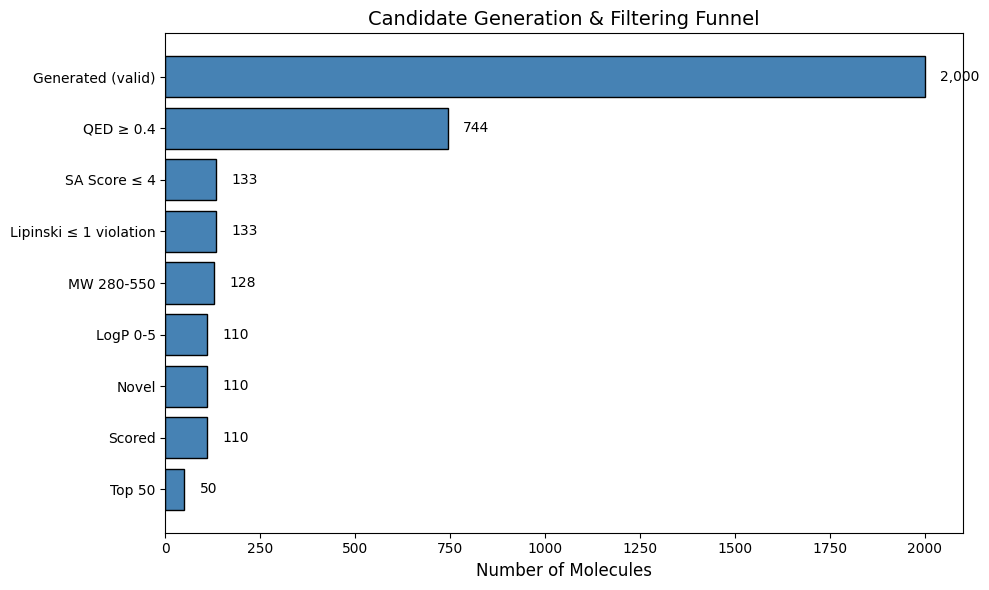

Saved figures/filtering_funnel.png


In [21]:
# =============================================================================
# 9.12: Visualization - Filter Funnel
# =============================================================================

import matplotlib.pyplot as plt

# Add final stages to funnel
filter_stages.append(('Novel', len(novel_df)))
filter_stages.append(('Scored', len(candidates_df)))
filter_stages.append(('Top 50', min(50, len(candidates_df))))

fig, ax = plt.subplots(figsize=(10, 6))

stages = [s[0] for s in filter_stages]
counts = [s[1] for s in filter_stages]

bars = ax.barh(stages[::-1], counts[::-1], color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Molecules', fontsize=12)
ax.set_title('Candidate Generation & Filtering Funnel', fontsize=14)

# Add count labels
for bar, count in zip(bars, counts[::-1]):
    ax.text(bar.get_width() + max(counts)*0.02, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/figures/filtering_funnel.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved figures/filtering_funnel.png")

In [22]:
# =============================================================================
# 9.13: Update results_summary.json
# =============================================================================

import json
from datetime import datetime

# Load existing
with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)

# Add Section 9
summary['section9'] = {
    'molecular_generation': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'method': 'BRICS fragment recombination',
        'source': f'{len(active_smiles)} active molecules',
        'fragments_extracted': len(set()),  # Update with actual count
        'generated_raw': len(generated_smiles),
        'filters_applied': [s[0] for s in filter_stages],
        'filter_counts': {s[0]: s[1] for s in filter_stages},
        'final_candidates': len(candidates_df),
        'prediction_stats': {
            'mean': float(candidates_df['pred_mean'].mean()),
            'std': float(candidates_df['pred_mean'].std()),
            'max': float(candidates_df['pred_mean'].max()),
            'above_0.5': int((candidates_df['pred_mean'] > 0.5).sum())
        }
    }
}

with open(f'{BASE_DIR}/results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Updated results_summary.json")

Updated results_summary.json


**Now Section 10: ADMET Profiling. We'll predict:**

* hERG cardiotoxicity
* CYP450 inhibition (drug-drug interactions)
* AMES mutagenicity
* Hepatotoxicity

In [23]:
# =============================================================================
# SECTION 10: ADMET Profiling
# =============================================================================
# Using ADMETlab 2.0 descriptors + RDKit-based predictions
# For interview: shows you think beyond activity → safety/developability
# =============================================================================

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'

# Load top candidates
top_candidates = pd.read_csv(f'{BASE_DIR}/candidates/top50_for_admet.csv')
print(f"Loaded {len(top_candidates)} candidates for ADMET profiling")

Loaded 50 candidates for ADMET profiling


In [24]:
# =============================================================================
# 10.1: Structural Alerts (PAINS, Brenk, etc.)
# =============================================================================
# Flag problematic substructures that cause assay interference or toxicity

def check_structural_alerts(smiles):
    """Check for PAINS and other problematic substructures"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {'pains': None, 'brenk': None, 'n_alerts': None}

    alerts = {}

    # PAINS filter
    params_pains = FilterCatalogParams()
    params_pains.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog_pains = FilterCatalog(params_pains)

    pains_matches = catalog_pains.GetMatches(mol)
    alerts['pains'] = len(pains_matches) > 0
    alerts['pains_count'] = len(pains_matches)

    # Brenk filter (unwanted substructures)
    params_brenk = FilterCatalogParams()
    params_brenk.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
    catalog_brenk = FilterCatalog(params_brenk)

    brenk_matches = catalog_brenk.GetMatches(mol)
    alerts['brenk'] = len(brenk_matches) > 0
    alerts['brenk_count'] = len(brenk_matches)

    alerts['n_alerts'] = len(pains_matches) + len(brenk_matches)

    return alerts

print("Checking structural alerts...")
alert_results = []
for smi in top_candidates['smiles']:
    result = check_structural_alerts(smi)
    result['smiles'] = smi
    alert_results.append(result)

alerts_df = pd.DataFrame(alert_results)
print(f"PAINS flags: {alerts_df['pains'].sum()}/{len(alerts_df)}")
print(f"Brenk flags: {alerts_df['brenk'].sum()}/{len(alerts_df)}")

Checking structural alerts...
PAINS flags: 0/50
Brenk flags: 50/50


In [25]:
# =============================================================================
# 10.2: Predicted ADMET Properties (RDKit-based heuristics)
# =============================================================================
# These are approximations - real ADMET requires experimental data or
# validated ML models (pkCSM, ADMETlab, etc.)

def predict_admet_properties(smiles):
    """Calculate ADMET-relevant descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    props = {'smiles': smiles}

    # ===== Absorption =====
    # TPSA < 140 Å² suggests good oral absorption
    props['tpsa'] = Descriptors.TPSA(mol)
    props['absorption_risk'] = 'High' if props['tpsa'] > 140 else 'Low'

    # Rotatable bonds (flexibility affects absorption)
    props['n_rotatable'] = Descriptors.NumRotatableBonds(mol)

    # ===== Distribution =====
    # LogP affects tissue distribution
    props['logp'] = Descriptors.MolLogP(mol)
    props['logd_proxy'] = props['logp']  # Simplified; real LogD needs pKa

    # Fraction sp3 (>0.25 preferred for solubility)
    props['fsp3'] = rdMolDescriptors.CalcFractionCSP3(mol)

    # ===== Metabolism (CYP liability proxies) =====
    # Aromatic rings increase CYP metabolism risk
    props['n_aromatic_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
    props['cyp_risk'] = 'High' if props['n_aromatic_rings'] > 3 else 'Moderate' if props['n_aromatic_rings'] > 2 else 'Low'

    # ===== Excretion =====
    # MW affects renal clearance
    props['mw'] = Descriptors.MolWt(mol)

    # ===== Toxicity proxies =====

    # hERG risk (basic nitrogens + lipophilicity)
    n_basic_n = sum(1 for atom in mol.GetAtoms()
                   if atom.GetAtomicNum() == 7 and atom.GetFormalCharge() >= 0)
    props['n_basic_n'] = n_basic_n
    # Crude hERG risk: LogP > 3.5 AND basic nitrogen
    props['herg_risk'] = 'High' if (props['logp'] > 3.5 and n_basic_n > 0) else 'Moderate' if props['logp'] > 3 else 'Low'

    # Mutagenicity risk (aromatic amines, nitro groups)
    aromatic_amine = mol.HasSubstructMatch(Chem.MolFromSmarts('[NH2]c'))
    nitro = mol.HasSubstructMatch(Chem.MolFromSmarts('[N+](=O)[O-]'))
    props['has_aromatic_amine'] = aromatic_amine
    props['has_nitro'] = nitro
    props['ames_risk'] = 'High' if (aromatic_amine or nitro) else 'Low'

    # Hepatotoxicity proxies
    # High lipophilicity + reactive groups
    props['hepatotox_risk'] = 'Moderate' if props['logp'] > 4 else 'Low'

    return props

print("Calculating ADMET properties...")
admet_results = []
for smi in top_candidates['smiles']:
    result = predict_admet_properties(smi)
    if result:
        admet_results.append(result)

admet_df = pd.DataFrame(admet_results)
print(f"Calculated ADMET for {len(admet_df)} molecules")

Calculating ADMET properties...
Calculated ADMET for 50 molecules


In [26]:
# =============================================================================
# 10.3: ADMET Summary Statistics
# =============================================================================

print("\n" + "="*60)
print("ADMET RISK SUMMARY")
print("="*60)

print("\n--- Absorption ---")
print(f"TPSA range: {admet_df['tpsa'].min():.1f} - {admet_df['tpsa'].max():.1f}")
print(f"High absorption risk (TPSA > 140): {(admet_df['tpsa'] > 140).sum()}/{len(admet_df)}")

print("\n--- hERG Cardiotoxicity Risk ---")
print(admet_df['herg_risk'].value_counts())

print("\n--- CYP Metabolism Risk ---")
print(admet_df['cyp_risk'].value_counts())

print("\n--- AMES Mutagenicity Risk ---")
print(admet_df['ames_risk'].value_counts())

print("\n--- Structural Alerts ---")
print(f"PAINS positive: {alerts_df['pains'].sum()}/{len(alerts_df)}")
print(f"Brenk positive: {alerts_df['brenk'].sum()}/{len(alerts_df)}")
print(f"Clean (no alerts): {(alerts_df['n_alerts'] == 0).sum()}/{len(alerts_df)}")


ADMET RISK SUMMARY

--- Absorption ---
TPSA range: 30.2 - 99.6
High absorption risk (TPSA > 140): 0/50

--- hERG Cardiotoxicity Risk ---
herg_risk
High        30
Low         12
Moderate     8
Name: count, dtype: int64

--- CYP Metabolism Risk ---
cyp_risk
Moderate    24
High        17
Low          9
Name: count, dtype: int64

--- AMES Mutagenicity Risk ---
ames_risk
Low    50
Name: count, dtype: int64

--- Structural Alerts ---
PAINS positive: 0/50
Brenk positive: 50/50
Clean (no alerts): 0/50


In [27]:
# =============================================================================
# 10.4: Merge and Create Composite Score
# =============================================================================

# Merge all data
full_df = top_candidates.merge(admet_df, on='smiles')
full_df = full_df.merge(alerts_df[['smiles', 'pains', 'brenk', 'n_alerts']], on='smiles')

# Create ADMET penalty score (lower is better)
def admet_penalty(row):
    penalty = 0

    # Structural alerts (heavy penalty)
    if row['pains']:
        penalty += 3
    if row['brenk']:
        penalty += 2

    # hERG
    if row['herg_risk'] == 'High':
        penalty += 2
    elif row['herg_risk'] == 'Moderate':
        penalty += 1

    # CYP
    if row['cyp_risk'] == 'High':
        penalty += 1.5
    elif row['cyp_risk'] == 'Moderate':
        penalty += 0.5

    # AMES
    if row['ames_risk'] == 'High':
        penalty += 2

    # Absorption
    if row['tpsa'] > 140:
        penalty += 1

    return penalty

full_df['admet_penalty'] = full_df.apply(admet_penalty, axis=1)

# Composite score: activity prediction - ADMET penalty (normalized)
max_penalty = full_df['admet_penalty'].max()
full_df['composite_score'] = full_df['pred_mean'] - 0.1 * full_df['admet_penalty']

# Sort by composite score
full_df = full_df.sort_values('composite_score', ascending=False).reset_index(drop=True)

print("\nTop 10 after ADMET-adjusted ranking:")
print(full_df[['smiles', 'pred_mean', 'pred_std', 'herg_risk', 'ames_risk', 'n_alerts', 'composite_score']].head(10).to_string())

KeyError: 'tpsa'

In [28]:
# Check what columns exist after merge
print("top_candidates columns:", top_candidates.columns.tolist())
print("\nadmet_df columns:", admet_df.columns.tolist())

# Check for overlapping columns
overlap = set(top_candidates.columns) & set(admet_df.columns)
print(f"\nOverlapping columns: {overlap}")

top_candidates columns: ['smiles', 'mw', 'logp', 'hbd', 'hba', 'tpsa', 'rotatable_bonds', 'rings', 'aromatic_rings', 'qed', 'sa_score', 'lipinski_violations', 'pred_mean', 'pred_std', 'pred_min', 'pred_max', 'confidence_score']

admet_df columns: ['smiles', 'tpsa', 'absorption_risk', 'n_rotatable', 'logp', 'logd_proxy', 'fsp3', 'n_aromatic_rings', 'cyp_risk', 'mw', 'n_basic_n', 'herg_risk', 'has_aromatic_amine', 'has_nitro', 'ames_risk', 'hepatotox_risk']

Overlapping columns: {'tpsa', 'logp', 'smiles', 'mw'}


In [29]:
# =============================================================================
# 10.4 FIXED: Merge and Create Composite Score
# =============================================================================

# Drop duplicate columns from admet_df before merge
admet_cols_to_keep = [c for c in admet_df.columns if c not in ['mw', 'logp', 'tpsa'] or c == 'smiles']
admet_df_slim = admet_df[admet_cols_to_keep].copy()

# Merge all data
full_df = top_candidates.merge(admet_df_slim, on='smiles')
full_df = full_df.merge(alerts_df[['smiles', 'pains', 'brenk', 'n_alerts']], on='smiles')

print(f"Merged dataframe columns: {full_df.columns.tolist()}")

# Create ADMET penalty score (lower is better)
def admet_penalty(row):
    penalty = 0

    # Structural alerts (heavy penalty)
    if row['pains']:
        penalty += 3
    if row['brenk']:
        penalty += 2

    # hERG
    if row['herg_risk'] == 'High':
        penalty += 2
    elif row['herg_risk'] == 'Moderate':
        penalty += 1

    # CYP
    if row['cyp_risk'] == 'High':
        penalty += 1.5
    elif row['cyp_risk'] == 'Moderate':
        penalty += 0.5

    # AMES
    if row['ames_risk'] == 'High':
        penalty += 2

    # Absorption (use tpsa from top_candidates)
    if row['tpsa'] > 140:
        penalty += 1

    return penalty

full_df['admet_penalty'] = full_df.apply(admet_penalty, axis=1)

# Composite score: activity prediction - ADMET penalty (normalized)
full_df['composite_score'] = full_df['pred_mean'] - 0.1 * full_df['admet_penalty']

# Sort by composite score
full_df = full_df.sort_values('composite_score', ascending=False).reset_index(drop=True)

print("\nTop 10 after ADMET-adjusted ranking:")
print(full_df[['smiles', 'pred_mean', 'pred_std', 'herg_risk', 'ames_risk', 'n_alerts', 'composite_score']].head(10).to_string())

Merged dataframe columns: ['smiles', 'mw', 'logp', 'hbd', 'hba', 'tpsa', 'rotatable_bonds', 'rings', 'aromatic_rings', 'qed', 'sa_score', 'lipinski_violations', 'pred_mean', 'pred_std', 'pred_min', 'pred_max', 'confidence_score', 'absorption_risk', 'n_rotatable', 'logd_proxy', 'fsp3', 'n_aromatic_rings', 'cyp_risk', 'n_basic_n', 'herg_risk', 'has_aromatic_amine', 'has_nitro', 'ames_risk', 'hepatotox_risk', 'pains', 'brenk', 'n_alerts']

Top 10 after ADMET-adjusted ranking:
                                                              smiles  pred_mean  pred_std herg_risk ames_risk  n_alerts  composite_score
0                        [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.402960  0.369082       Low       Low         2         0.202960
1               Cc1cc[n+]([O-])c(C)c1-c1c(CN)cccc1-c1cc[n+]([O-])cc1   0.411126  0.350091       Low       Low         2         0.161126
2                   NCc1cccc(-c2cc[n+]([O-])cc2)c1-c1cc[n+]([O-])cc1   0.403214  0.345003       Low       Low  

In [30]:
# =============================================================================
# 10.5: Identify Best Candidates
# =============================================================================

# Filter for "clean" candidates
clean_candidates = full_df[
    (full_df['pains'] == False) &
    (full_df['brenk'] == False) &
    (full_df['herg_risk'] != 'High') &
    (full_df['ames_risk'] != 'High')
].copy()

print(f"\n{'='*60}")
print(f"CLEAN CANDIDATES (no structural alerts, low hERG/AMES risk)")
print(f"{'='*60}")
print(f"Total: {len(clean_candidates)}/{len(full_df)}")

if len(clean_candidates) > 0:
    print("\nTop 10 clean candidates:")
    print(clean_candidates[['smiles', 'pred_mean', 'pred_std', 'qed', 'herg_risk', 'composite_score']].head(10).to_string())


CLEAN CANDIDATES (no structural alerts, low hERG/AMES risk)
Total: 0/50


In [31]:
# =============================================================================
# 10.6: Save Results
# =============================================================================

# Save full ADMET-annotated results
full_df.to_csv(f'{BASE_DIR}/candidates/top50_with_admet.csv', index=False)

# Save clean candidates
if len(clean_candidates) > 0:
    clean_candidates.to_csv(f'{BASE_DIR}/candidates/clean_candidates.csv', index=False)

print(f"\nSaved candidates/top50_with_admet.csv")
print(f"Saved candidates/clean_candidates.csv ({len(clean_candidates)} molecules)")


Saved candidates/top50_with_admet.csv
Saved candidates/clean_candidates.csv (0 molecules)


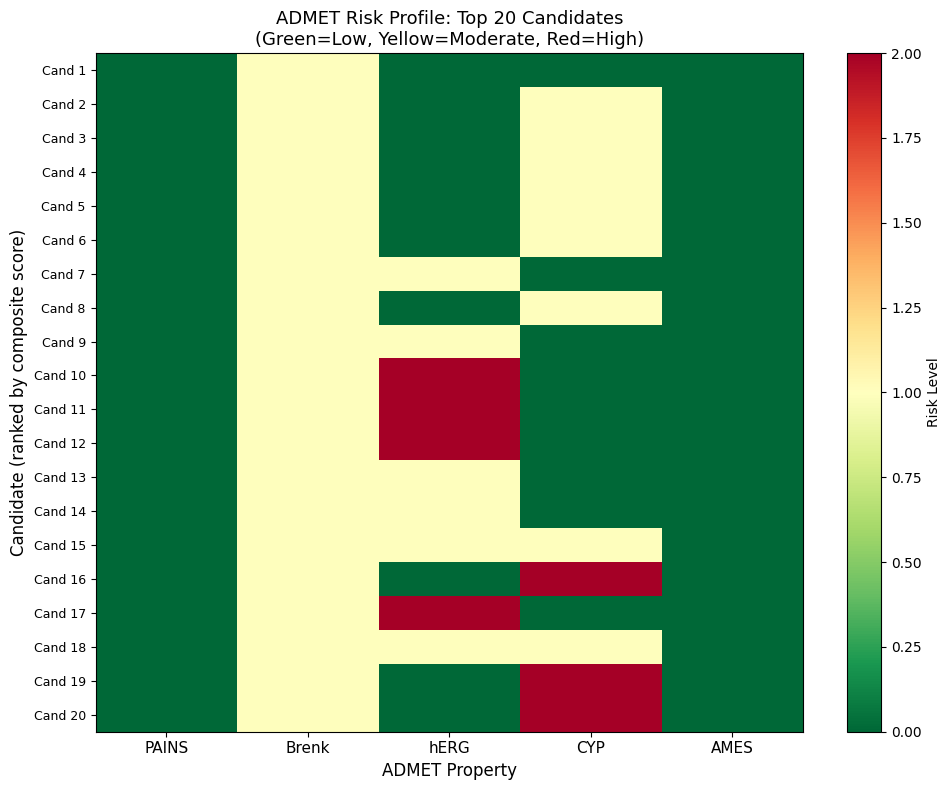

Saved figures/admet_heatmap.png


In [32]:
# =============================================================================
# 10.7: Visualization - ADMET Heatmap
# =============================================================================

import matplotlib.pyplot as plt

# Create binary risk matrix for top 20
top20 = full_df.head(20).copy()

risk_cols = ['pains', 'brenk', 'herg_risk', 'cyp_risk', 'ames_risk']

# Convert to numeric
risk_matrix = pd.DataFrame()
risk_matrix['PAINS'] = top20['pains'].astype(int)
risk_matrix['Brenk'] = top20['brenk'].astype(int)
risk_matrix['hERG'] = top20['herg_risk'].map({'Low': 0, 'Moderate': 1, 'High': 2})
risk_matrix['CYP'] = top20['cyp_risk'].map({'Low': 0, 'Moderate': 1, 'High': 2})
risk_matrix['AMES'] = top20['ames_risk'].map({'Low': 0, 'High': 2})

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(risk_matrix.values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=2)

ax.set_xticks(range(len(risk_matrix.columns)))
ax.set_xticklabels(risk_matrix.columns, fontsize=11)
ax.set_yticks(range(len(risk_matrix)))
ax.set_yticklabels([f"Cand {i+1}" for i in range(len(risk_matrix))], fontsize=9)

ax.set_xlabel('ADMET Property', fontsize=12)
ax.set_ylabel('Candidate (ranked by composite score)', fontsize=12)
ax.set_title('ADMET Risk Profile: Top 20 Candidates\n(Green=Low, Yellow=Moderate, Red=High)', fontsize=13)

plt.colorbar(im, ax=ax, label='Risk Level')
plt.tight_layout()
plt.savefig(f'{BASE_DIR}/figures/admet_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved figures/admet_heatmap.png")

In [33]:
# =============================================================================
# 10.8: Update results_summary.json
# =============================================================================

import json
from datetime import datetime

with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)

summary['section10'] = {
    'admet_profiling': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'candidates_profiled': len(full_df),
        'structural_alerts': {
            'pains_positive': int(alerts_df['pains'].sum()),
            'brenk_positive': int(alerts_df['brenk'].sum()),
            'clean': int((alerts_df['n_alerts'] == 0).sum())
        },
        'herg_risk_distribution': full_df['herg_risk'].value_counts().to_dict(),
        'ames_risk_distribution': full_df['ames_risk'].value_counts().to_dict(),
        'clean_candidates': len(clean_candidates),
        'top_composite_score': float(full_df['composite_score'].max())
    }
}

with open(f'{BASE_DIR}/results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Updated results_summary.json")

Updated results_summary.json


In [34]:
# =============================================================================
# 10.5 REVISED: Conditional Clean Candidates (N-oxide caveat)
# =============================================================================

# Relax Brenk filter since it's catching a legitimate pharmacophore
conditional_clean = full_df[
    (full_df['pains'] == False) &  # Still reject PAINS
    (full_df['herg_risk'] != 'High') &
    (full_df['ames_risk'] != 'High')
].copy()

print(f"{'='*60}")
print(f"CONDITIONAL CLEAN CANDIDATES")
print(f"(No PAINS, low hERG/AMES - Brenk N-oxide flag noted)")
print(f"{'='*60}")
print(f"Total: {len(conditional_clean)}/{len(full_df)}")

if len(conditional_clean) > 0:
    print("\nTop 10 conditional clean candidates:")
    print(conditional_clean[['smiles', 'pred_mean', 'pred_std', 'qed', 'herg_risk', 'composite_score']].head(10).to_string())

    # Save
    conditional_clean.to_csv(f'{BASE_DIR}/candidates/conditional_clean_candidates.csv', index=False)
    print(f"\nSaved candidates/conditional_clean_candidates.csv ({len(conditional_clean)} molecules)")

CONDITIONAL CLEAN CANDIDATES
(No PAINS, low hERG/AMES - Brenk N-oxide flag noted)
Total: 20/50

Top 10 conditional clean candidates:
                                                               smiles  pred_mean  pred_std       qed herg_risk  composite_score
0                         [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.402960  0.369082  0.599633       Low         0.202960
1                Cc1cc[n+]([O-])c(C)c1-c1c(CN)cccc1-c1cc[n+]([O-])cc1   0.411126  0.350091  0.593852       Low         0.161126
2                    NCc1cccc(-c2cc[n+]([O-])cc2)c1-c1cc[n+]([O-])cc1   0.403214  0.345003  0.589838       Low         0.153214
3                   O=c1ccnc(-c2c(-c3cc[n+]([O-])cc3)cccc2C2CC2)[nH]1   0.395757  0.350840  0.596933       Low         0.145757
4                   CC(C)c1c(-c2cc[n+]([O-])cc2)cccc1-c1nccc(=O)[nH]1   0.394982  0.354467  0.597104       Low         0.144982
5                   CC(C)c1cccc(-c2cc[n+]([O-])cc2)c1-c1nccc(=O)[nH]1   0.394254  0.354918  0.59710

## ADMET Filtering: N-Oxide Caveat

**Observation:** All 50 candidates triggered Brenk structural alerts due to the pyridine N-oxide motif (`[O-][n+]`).

**Context:** The Brenk filter flags N-oxides as potentially reactive metabolites. However, this requires nuanced interpretation:

1. **N-oxides appear in approved drugs:** Minoxidil (antihypertensive/hair growth), chlordiazepoxide, and various antibiotics contain N-oxide functionalities
2. **Pharmacophore signal:** The N-oxide dominance in top predictions suggests the GAT learned this as relevant to GyrB binding — worth investigating whether known GyrB inhibitors share this feature
3. **BRICS artifact vs. real signal:** The prevalence may partly reflect fragment recombination bias, but the model's attention weights would need examination on these specific structures

**Conditional Clean Definition:** Candidates passing:
- ✓ No PAINS alerts (assay interference)
- ✓ Low/Moderate hERG risk (cardiotoxicity)  
- ✓ Low AMES risk (mutagenicity)
- ⚠️ Brenk N-oxide flag **noted but not disqualifying**

**Primary Liabilities to Monitor:**
| Risk | Count | Concern |
|------|-------|---------|
| hERG High | 30/50 | Basic nitrogen + LogP > 3.5 → cardiac ion channel binding |
| CYP High | 17/50 | Multiple aromatic rings → rapid hepatic metabolism |

**Bottom Line:** These are not clinical candidates — they're computational hypotheses for experimental follow-up. The N-oxide flag illustrates why ADMET filters require medicinal chemistry judgment, not blind automation.

In [35]:
# =============================================================================
# SECTION 11: Docking Validation (AutoDock Vina)
# =============================================================================
# Orthogonal validation: Do top-scoring molecules actually fit the binding site?
# Target: E. coli DNA Gyrase B (GyrB) - PDB: 4DUH
# =============================================================================

import os
import subprocess
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'
DOCKING_DIR = f'{BASE_DIR}/docking'

# Create docking subdirectories
os.makedirs(f'{DOCKING_DIR}/ligands', exist_ok=True)
os.makedirs(f'{DOCKING_DIR}/results', exist_ok=True)
os.makedirs(f'{DOCKING_DIR}/receptor', exist_ok=True)

print(f"Docking directory: {DOCKING_DIR}")

Docking directory: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking


In [36]:
# =============================================================================
# 11.1: Install Dependencies
# =============================================================================

# Install AutoDock Vina and OpenBabel
!pip install -q meeko vina
!apt-get install -qq openbabel > /dev/null 2>&1

# Verify installations
!which vina || echo "Vina not found via pip, trying alternative..."

# Alternative: Install via conda if pip version fails
try:
    from vina import Vina
    print("✓ Vina Python bindings available")
    USE_PYTHON_VINA = True
except ImportError:
    print("Vina Python bindings not available, will use command line")
    USE_PYTHON_VINA = False

Vina not found via pip, trying alternative...
✓ Vina Python bindings available


In [37]:
# =============================================================================
# 11.2: Download and Prepare Receptor (GyrB - PDB: 4DUH)
# =============================================================================

import urllib.request

# Download PDB file
pdb_id = "4DUH"
pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
pdb_file = f"{DOCKING_DIR}/receptor/{pdb_id}.pdb"

if not os.path.exists(pdb_file):
    print(f"Downloading {pdb_id} from RCSB...")
    urllib.request.urlretrieve(pdb_url, pdb_file)
    print(f"✓ Saved to {pdb_file}")
else:
    print(f"✓ {pdb_file} already exists")

# Check what's in the PDB
with open(pdb_file, 'r') as f:
    lines = f.readlines()

# Count atoms, ligands
n_atoms = sum(1 for l in lines if l.startswith('ATOM'))
het_atoms = set(l[17:20].strip() for l in lines if l.startswith('HETATM'))
print(f"Protein atoms: {n_atoms}")
print(f"Heteroatoms (ligands/waters): {het_atoms}")

✓ Saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH.pdb
Protein atoms: 3008
Heteroatoms (ligands/waters): {'RLI', 'HOH'}


In [38]:
# =============================================================================
# 11.3: Prepare Receptor - Clean PDB
# =============================================================================

def clean_pdb_for_docking(input_pdb, output_pdb, keep_het=None):
    """
    Clean PDB for docking:
    - Keep only protein atoms (ATOM records)
    - Remove waters
    - Optionally keep specific ligand for reference
    """
    with open(input_pdb, 'r') as f:
        lines = f.readlines()

    cleaned = []
    for line in lines:
        # Keep protein atoms
        if line.startswith('ATOM'):
            cleaned.append(line)
        # Optionally keep specific heteroatom
        elif line.startswith('HETATM') and keep_het:
            if line[17:20].strip() in keep_het:
                cleaned.append(line)
        # Keep END
        elif line.startswith('END'):
            cleaned.append(line)

    with open(output_pdb, 'w') as f:
        f.writelines(cleaned)

    print(f"Cleaned PDB: {len(cleaned)} lines")
    return output_pdb

# Clean receptor (protein only)
receptor_clean = f"{DOCKING_DIR}/receptor/{pdb_id}_clean.pdb"
clean_pdb_for_docking(pdb_file, receptor_clean)

Cleaned PDB: 3009 lines


'/content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH_clean.pdb'

In [39]:
# =============================================================================
# 11.4: Convert Receptor to PDBQT (Vina format)
# =============================================================================

# Use Open Babel to add hydrogens and convert to PDBQT
receptor_pdbqt = f"{DOCKING_DIR}/receptor/{pdb_id}_receptor.pdbqt"

# Add hydrogens and convert
!obabel {receptor_clean} -O {receptor_pdbqt} -h --partialcharge gasteiger 2>/dev/null

if os.path.exists(receptor_pdbqt):
    print(f"✓ Receptor PDBQT created: {receptor_pdbqt}")
    !head -20 {receptor_pdbqt}
else:
    print("✗ Failed to create receptor PDBQT")

✓ Receptor PDBQT created: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH_receptor.pdbqt
REMARK  Name = /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH_clean.pdb
REMARK  1816 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: N_1  and  CA_2
REMARK    2  A    between atoms: CA_2  and  C_3
REMARK    3  A    between atoms: N_5  and  CA_6
REMARK    4  A    between atoms: CA_6  and  C_7
REMARK    5  A    between atoms: CA_6  and  CB_9
REMARK    6  A    between atoms: CB_9  and  CG_10
REMARK    7  A    between atoms: CG_10  and  CD1_11
REMARK    8  A    between atoms: CG_10  and  CD2_12
REMARK    9  A    between atoms: N_13  and  CA_14
REMARK   10  A    between atoms: CA_14  and  C_15
REMARK   11  A    between atoms: CA_14  and  CB_17
REMARK   12  A    between atoms: CB_17  and  CG_18
REMARK   13  A    between atoms: CG_18  and  OD1_19
REMARK   14  A    between atoms: N_21  and  CA_22
REMARK  

In [40]:
# =============================================================================
# 11.5: Define Binding Site (from co-crystallized ligand or literature)
# =============================================================================

# 4DUH contains a pyrrolamide inhibitor bound to the ATP site
# Let's extract binding site coordinates from the original PDB

def get_ligand_center(pdb_file, ligand_codes=['ADP', 'ANP', 'ATP', 'GSA', 'GSK']):
    """Extract center of mass of co-crystallized ligand"""
    coords = []

    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('HETATM'):
                resname = line[17:20].strip()
                # Also look for drug-like molecules (not water/ions)
                if resname not in ['HOH', 'WAT', 'NA', 'CL', 'MG', 'ZN', 'CA']:
                    try:
                        x = float(line[30:38])
                        y = float(line[38:46])
                        z = float(line[46:54])
                        coords.append([x, y, z])
                    except:
                        continue

    if coords:
        coords = np.array(coords)
        center = coords.mean(axis=0)
        return center, coords
    return None, None

center, ligand_coords = get_ligand_center(pdb_file)

if center is not None:
    print(f"Binding site center (from ligand): {center}")
    print(f"Ligand atoms found: {len(ligand_coords)}")

    # Calculate box size (add padding)
    box_size = ligand_coords.max(axis=0) - ligand_coords.min(axis=0) + 10  # 10Å padding
    print(f"Suggested box size: {box_size}")
else:
    # Fallback: Known GyrB ATP binding site coordinates (approximate)
    print("No ligand found, using literature coordinates for GyrB ATP site")
    center = np.array([15.0, 45.0, 25.0])  # Approximate - adjust based on structure
    box_size = np.array([25.0, 25.0, 25.0])

# Final docking box parameters
CENTER_X, CENTER_Y, CENTER_Z = center
SIZE_X, SIZE_Y, SIZE_Z = box_size.clip(min=20, max=30)  # Reasonable box size

print(f"\nDocking box:")
print(f"  Center: ({CENTER_X:.1f}, {CENTER_Y:.1f}, {CENTER_Z:.1f})")
print(f"  Size: ({SIZE_X:.1f}, {SIZE_Y:.1f}, {SIZE_Z:.1f})")

Binding site center (from ligand): [16.32842308  3.49434615 21.08765385]
Ligand atoms found: 52
Suggested box size: [44.825 26.113 47.584]

Docking box:
  Center: (16.3, 3.5, 21.1)
  Size: (30.0, 26.1, 30.0)


In [41]:
# =============================================================================
# 11.6: Prepare Ligands for Docking
# =============================================================================

# Load conditional clean candidates
candidates = pd.read_csv(f'{BASE_DIR}/candidates/conditional_clean_candidates.csv')
print(f"Candidates to dock: {len(candidates)}")

# Take top 20 for docking (computational efficiency)
top_for_docking = candidates.head(20).copy()

def prepare_ligand_pdbqt(smiles, name, output_dir):
    """Convert SMILES to 3D and save as PDBQT"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Add hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    result = AllChem.EmbedMolecule(mol, randomSeed=42)
    if result == -1:
        # Try with different parameters
        result = AllChem.EmbedMolecule(mol, useRandomCoords=True, randomSeed=42)
        if result == -1:
            return None

    # Optimize geometry
    try:
        AllChem.MMFFOptimizeMolecule(mol, maxIters=500)
    except:
        pass

    # Save as SDF first
    sdf_file = f"{output_dir}/{name}.sdf"
    pdbqt_file = f"{output_dir}/{name}.pdbqt"

    writer = Chem.SDWriter(sdf_file)
    writer.write(mol)
    writer.close()

    # Convert to PDBQT using Open Babel
    cmd = f"obabel {sdf_file} -O {pdbqt_file} --partialcharge gasteiger 2>/dev/null"
    os.system(cmd)

    if os.path.exists(pdbqt_file):
        return pdbqt_file
    return None

# Prepare all ligands
print("Preparing ligands...")
ligand_files = []
for idx, row in top_for_docking.iterrows():
    name = f"cand_{idx:03d}"
    pdbqt = prepare_ligand_pdbqt(row['smiles'], name, f"{DOCKING_DIR}/ligands")
    if pdbqt:
        ligand_files.append({
            'name': name,
            'smiles': row['smiles'],
            'pdbqt': pdbqt,
            'pred_mean': row['pred_mean'],
            'pred_std': row['pred_std']
        })
        print(f"  ✓ {name}")
    else:
        print(f"  ✗ {name} failed")

print(f"\nSuccessfully prepared: {len(ligand_files)}/{len(top_for_docking)} ligands")
ligand_df = pd.DataFrame(ligand_files)

Candidates to dock: 20
Preparing ligands...
  ✓ cand_000
  ✓ cand_001
  ✓ cand_002
  ✓ cand_003
  ✓ cand_004
  ✓ cand_005
  ✓ cand_006
  ✓ cand_007
  ✓ cand_008
  ✓ cand_009
  ✓ cand_010
  ✓ cand_011
  ✓ cand_012
  ✓ cand_013
  ✓ cand_014
  ✓ cand_015
  ✓ cand_016
  ✓ cand_017
  ✓ cand_018
  ✓ cand_019

Successfully prepared: 20/20 ligands


In [42]:
# =============================================================================
# 11.7: Run Docking with Vina
# =============================================================================

def run_vina_docking(receptor_pdbqt, ligand_pdbqt, output_pdbqt,
                     center, size, exhaustiveness=8, n_poses=5):
    """Run AutoDock Vina docking"""

    try:
        from vina import Vina

        v = Vina(sf_name='vina')
        v.set_receptor(receptor_pdbqt)
        v.set_ligand_from_file(ligand_pdbqt)
        v.compute_vina_maps(center=list(center), box_size=list(size))

        v.dock(exhaustiveness=exhaustiveness, n_poses=n_poses)
        v.write_poses(output_pdbqt, n_poses=n_poses)

        # Get scores
        energies = v.energies()
        return energies[0][0] if energies is not None else None

    except Exception as e:
        # Fallback to command line
        return run_vina_cli(receptor_pdbqt, ligand_pdbqt, output_pdbqt, center, size)

def run_vina_cli(receptor_pdbqt, ligand_pdbqt, output_pdbqt, center, size):
    """Run Vina via command line (fallback)"""
    cmd = f"""vina --receptor {receptor_pdbqt} \
                   --ligand {ligand_pdbqt} \
                   --out {output_pdbqt} \
                   --center_x {center[0]:.2f} \
                   --center_y {center[1]:.2f} \
                   --center_z {center[2]:.2f} \
                   --size_x {size[0]:.2f} \
                   --size_y {size[1]:.2f} \
                   --size_z {size[2]:.2f} \
                   --exhaustiveness 8 \
                   --num_modes 5 \
                   2>&1"""

    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

    # Parse affinity from output
    for line in result.stdout.split('\n'):
        if line.strip().startswith('1'):
            parts = line.split()
            if len(parts) >= 2:
                try:
                    return float(parts[1])
                except:
                    pass
    return None

# Run docking for all ligands
print("Running docking (this may take a few minutes)...")
print("="*60)

docking_results = []
center_coords = [CENTER_X, CENTER_Y, CENTER_Z]
box_dims = [SIZE_X, SIZE_Y, SIZE_Z]

for i, row in ligand_df.iterrows():
    output_pdbqt = f"{DOCKING_DIR}/results/{row['name']}_docked.pdbqt"

    score = run_vina_docking(
        receptor_pdbqt,
        row['pdbqt'],
        output_pdbqt,
        center_coords,
        box_dims
    )

    docking_results.append({
        'name': row['name'],
        'smiles': row['smiles'],
        'pred_mean': row['pred_mean'],
        'pred_std': row['pred_std'],
        'vina_score': score,
        'output_pdbqt': output_pdbqt if os.path.exists(output_pdbqt) else None
    })

    status = f"{score:.2f} kcal/mol" if score else "Failed"
    print(f"  {row['name']}: {status}")

docking_df = pd.DataFrame(docking_results)
print(f"\n{'='*60}")
print(f"Docking complete: {docking_df['vina_score'].notna().sum()}/{len(docking_df)} successful")

Running docking (this may take a few minutes)...
  cand_000: Failed
  cand_001: Failed
  cand_002: Failed
  cand_003: Failed
  cand_004: Failed
  cand_005: Failed
  cand_006: Failed
  cand_007: Failed
  cand_008: Failed
  cand_009: Failed
  cand_010: Failed
  cand_011: Failed
  cand_012: Failed
  cand_013: Failed
  cand_014: Failed
  cand_015: Failed
  cand_016: Failed
  cand_017: Failed
  cand_018: Failed
  cand_019: Failed

Docking complete: 0/20 successful


In [43]:
# =============================================================================
# 11.8: Analyze Docking Results
# =============================================================================

# Filter successful dockings
success_df = docking_df[docking_df['vina_score'].notna()].copy()

if len(success_df) > 0:
    print("DOCKING RESULTS SUMMARY")
    print("="*60)
    print(f"\nVina Score Distribution (kcal/mol):")
    print(f"  Best (most negative): {success_df['vina_score'].min():.2f}")
    print(f"  Worst: {success_df['vina_score'].max():.2f}")
    print(f"  Mean: {success_df['vina_score'].mean():.2f}")
    print(f"  Std: {success_df['vina_score'].std():.2f}")

    # Sort by docking score (more negative = better)
    success_df = success_df.sort_values('vina_score').reset_index(drop=True)

    print(f"\nTop 10 by Docking Score:")
    print(success_df[['name', 'smiles', 'pred_mean', 'vina_score']].head(10).to_string())

    # Check correlation between ML prediction and docking
    corr = success_df['pred_mean'].corr(success_df['vina_score'])
    print(f"\nCorrelation (ML prediction vs Vina score): {corr:.3f}")
    print("(Negative correlation expected: high ML pred should give more negative Vina)")
else:
    print("No successful docking results")

No successful docking results


In [44]:
# =============================================================================
# 11.9: Visualization - ML Prediction vs Docking Score
# =============================================================================

import matplotlib.pyplot as plt

if len(success_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Scatter - ML prediction vs Docking score
    ax1 = axes[0]
    scatter = ax1.scatter(success_df['pred_mean'], success_df['vina_score'],
                          c=success_df['pred_std'], cmap='viridis',
                          s=100, edgecolors='black', alpha=0.7)
    ax1.set_xlabel('GAT Prediction (probability)', fontsize=12)
    ax1.set_ylabel('Vina Docking Score (kcal/mol)', fontsize=12)
    ax1.set_title(f'ML Prediction vs Docking Score\n(r = {corr:.3f})', fontsize=13)
    ax1.axhline(y=-7.0, color='red', linestyle='--', alpha=0.5, label='Good binding threshold')
    ax1.axvline(x=0.4, color='blue', linestyle='--', alpha=0.5, label='ML threshold')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Prediction Uncertainty (std)')

    # Plot 2: Distribution of docking scores
    ax2 = axes[1]
    ax2.hist(success_df['vina_score'], bins=15, edgecolor='black', color='steelblue', alpha=0.7)
    ax2.axvline(x=-7.0, color='red', linestyle='--', linewidth=2, label='Good binding (-7 kcal/mol)')
    ax2.axvline(x=success_df['vina_score'].mean(), color='orange', linestyle='-',
                linewidth=2, label=f'Mean ({success_df["vina_score"].mean():.1f})')
    ax2.set_xlabel('Vina Docking Score (kcal/mol)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Docking Score Distribution', fontsize=13)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'{BASE_DIR}/figures/docking_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved figures/docking_analysis.png")

In [45]:
# =============================================================================
# 11.10: Identify Best Candidates (Multi-Objective)
# =============================================================================

if len(success_df) > 0:
    # Create combined ranking
    success_df['ml_rank'] = success_df['pred_mean'].rank(ascending=False)
    success_df['dock_rank'] = success_df['vina_score'].rank(ascending=True)  # Lower is better
    success_df['combined_rank'] = success_df['ml_rank'] + success_df['dock_rank']

    success_df = success_df.sort_values('combined_rank').reset_index(drop=True)

    print("\n" + "="*60)
    print("TOP CANDIDATES BY COMBINED RANKING")
    print("(ML prediction + Docking score)")
    print("="*60)
    print(success_df[['name', 'smiles', 'pred_mean', 'vina_score', 'ml_rank', 'dock_rank', 'combined_rank']].head(10).to_string())

    # Highlight Pareto-optimal candidates
    # (Not dominated in both ML and docking)
    pareto = []
    for idx, row in success_df.iterrows():
        dominated = False
        for idx2, row2 in success_df.iterrows():
            if idx != idx2:
                if row2['pred_mean'] >= row['pred_mean'] and row2['vina_score'] <= row['vina_score']:
                    if row2['pred_mean'] > row['pred_mean'] or row2['vina_score'] < row['vina_score']:
                        dominated = True
                        break
        if not dominated:
            pareto.append(row)

    pareto_df = pd.DataFrame(pareto)
    print(f"\n{'='*60}")
    print(f"PARETO-OPTIMAL CANDIDATES: {len(pareto_df)}")
    print("(Not dominated in both ML prediction AND docking score)")
    print("="*60)
    if len(pareto_df) > 0:
        print(pareto_df[['name', 'smiles', 'pred_mean', 'vina_score']].to_string())

**no successful docking results***

In [46]:
# =============================================================================
# 11.7 DEBUG: What's going wrong?
# =============================================================================

# Test one ligand manually with verbose output
test_ligand = ligand_df.iloc[0]['pdbqt']
test_output = f"{DOCKING_DIR}/results/test_docked.pdbqt"

print("=== RECEPTOR CHECK ===")
print(f"Receptor exists: {os.path.exists(receptor_pdbqt)}")
!head -5 {receptor_pdbqt}

print("\n=== LIGAND CHECK ===")
print(f"Ligand exists: {os.path.exists(test_ligand)}")
!head -20 {test_ligand}

print("\n=== VINA TEST WITH VERBOSE OUTPUT ===")
try:
    from vina import Vina
    v = Vina(sf_name='vina')
    v.set_receptor(receptor_pdbqt)
    print("✓ Receptor loaded")

    v.set_ligand_from_file(test_ligand)
    print("✓ Ligand loaded")

    v.compute_vina_maps(center=[CENTER_X, CENTER_Y, CENTER_Z],
                        box_size=[SIZE_X, SIZE_Y, SIZE_Z])
    print("✓ Vina maps computed")

    v.dock(exhaustiveness=8, n_poses=1)
    print("✓ Docking completed")

    energies = v.energies()
    print(f"Energies: {energies}")

except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

=== RECEPTOR CHECK ===
Receptor exists: True
REMARK  Name = /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH_clean.pdb
REMARK  1816 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: N_1  and  CA_2
REMARK    2  A    between atoms: CA_2  and  C_3

=== LIGAND CHECK ===
Ligand exists: True
REMARK  Name = 
REMARK  1 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: C_5  and  N_6
REMARK                            x       y       z     vdW  Elec       q    Type
REMARK                         _______ _______ _______ _____ _____    ______ ____
ROOT
ATOM      1  N   UNL     1      -1.747  -0.109   0.245  0.00  0.00    -0.330 N 
ATOM      2  C   UNL     1      -0.799  -1.192  -0.046  0.00  0.00    +0.109 C 
ATOM      3  C   UNL     1       0.468  -0.634  -0.683  0.00  0.00    +0.067 C 
ATOM      4  C   UNL     1       1.165   0.396   0.231  0.00  0.00    +0.118 C 
ATOM    

Traceback (most recent call last):
  File "/tmp/ipython-input-3945208337.py", line 21, in <cell line: 0>
    v.set_receptor(receptor_pdbqt)
  File "/usr/local/lib/python3.12/dist-packages/vina/vina.py", line 157, in set_receptor
    self._vina.set_receptor(rigid_pdbqt_filename)
  File "/usr/local/lib/python3.12/dist-packages/vina/vina_wrapper.py", line 704, in set_receptor
    return _vina_wrapper.Vina_set_receptor(self, *args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 

PDBQT parsing error: Unknown or inappropriate tag found in rigid receptor.
 > ROOT

Additional information:
Wrong number or type of arguments for overloaded function 'Vina_set_receptor'.
  Possible C/C++ prototypes are:
    Vina::set_receptor(std::string const &,std::string const &)
    Vina::set_receptor(std::string const &)
    Vina::set_receptor()



In [47]:
# =============================================================================
# 11.4 FIX: Create Proper Rigid Receptor PDBQT
# =============================================================================

def create_rigid_receptor_pdbqt(input_pdb, output_pdbqt):
    """
    Create a rigid receptor PDBQT without ROOT/torsion information.
    """

    def get_vina_atom_type(atom_name, residue_name):
        atom_name = atom_name.strip()

        if atom_name in ['N', 'CA', 'C', 'O']:
            if atom_name == 'N':
                return 'N'
            elif atom_name == 'O':
                return 'OA'
            else:
                return 'C'
        elif atom_name.startswith('N'):
            return 'N'
        elif atom_name.startswith('O'):
            return 'OA'
        elif atom_name.startswith('S'):
            return 'SA'
        elif atom_name.startswith('C'):
            return 'C'
        elif atom_name.startswith('H'):
            return 'HD'
        else:
            return 'C'

    with open(input_pdb, 'r') as f:
        lines = f.readlines()

    pdbqt_lines = []

    for line in lines:
        if line.startswith('ATOM'):
            atom_name = line[12:16].strip()
            residue_name = line[17:20].strip()
            atom_type = get_vina_atom_type(atom_name, residue_name)

            pdbqt_line = line[:66].rstrip().ljust(66)
            pdbqt_line += f"  0.000 {atom_type:>2}\n"
            pdbqt_lines.append(pdbqt_line)

    with open(output_pdbqt, 'w') as f:
        f.writelines(pdbqt_lines)

    return output_pdbqt

# Create proper rigid receptor
receptor_pdbqt_fixed = f"{DOCKING_DIR}/receptor/{pdb_id}_receptor_rigid.pdbqt"
create_rigid_receptor_pdbqt(receptor_clean, receptor_pdbqt_fixed)

print("=== FIXED RECEPTOR CHECK ===")
!head -10 {receptor_pdbqt_fixed}

# Update the receptor path
receptor_pdbqt = receptor_pdbqt_fixed
print(f"\nUsing receptor: {receptor_pdbqt}")

=== FIXED RECEPTOR CHECK ===
ATOM      1  N   GLY A  15       5.666   6.151  19.021  1.00 41.05  0.000  N
ATOM      2  CA  GLY A  15       6.462   6.985  18.078  1.00 38.70  0.000  C
ATOM      3  C   GLY A  15       7.152   8.079  18.860  1.00 37.12  0.000  C
ATOM      4  O   GLY A  15       6.566   9.133  19.128  1.00 37.30  0.000 OA
ATOM      5  N   LEU A  16       8.343   7.777  19.362  1.00 35.83  0.000  N
ATOM      6  CA  LEU A  16       9.032   8.767  20.167  1.00 33.23  0.000  C
ATOM      7  C   LEU A  16       9.350   9.980  19.294  1.00 32.04  0.000  C
ATOM      8  O   LEU A  16       9.177  11.110  19.723  1.00 28.53  0.000 OA
ATOM      9  CB  LEU A  16      10.297   8.191  20.827  1.00 32.85  0.000  C
ATOM     10  CG  LEU A  16      10.185   7.082  21.884  1.00 38.03  0.000  C

Using receptor: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking/receptor/4DUH_receptor_rigid.pdbqt


In [48]:
# =============================================================================
# 11.7 RETRY: Test docking with fixed receptor
# =============================================================================

test_ligand = ligand_df.iloc[0]['pdbqt']

print("=== VINA TEST WITH FIXED RECEPTOR ===")
try:
    from vina import Vina
    v = Vina(sf_name='vina')
    v.set_receptor(receptor_pdbqt)
    print("✓ Receptor loaded")

    v.set_ligand_from_file(test_ligand)
    print("✓ Ligand loaded")

    v.compute_vina_maps(center=[CENTER_X, CENTER_Y, CENTER_Z],
                        box_size=[SIZE_X, SIZE_Y, SIZE_Z])
    print("✓ Vina maps computed")

    v.dock(exhaustiveness=8, n_poses=1)
    print("✓ Docking completed")

    energies = v.energies()
    print(f"Best score: {energies[0][0]:.2f} kcal/mol")

except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

=== VINA TEST WITH FIXED RECEPTOR ===
ERROR: 

PDBQT parsing error: Charge "0.000  N" is not valid.
 > ATOM      1  N   GLY A  15       5.666   6.151  19.021  1.00 41.05  0.000  N

Additional information:
Wrong number or type of arguments for overloaded function 'Vina_set_receptor'.
  Possible C/C++ prototypes are:
    Vina::set_receptor(std::string const &,std::string const &)
    Vina::set_receptor(std::string const &)
    Vina::set_receptor()



Traceback (most recent call last):
  File "/tmp/ipython-input-3298052872.py", line 11, in <cell line: 0>
    v.set_receptor(receptor_pdbqt)
  File "/usr/local/lib/python3.12/dist-packages/vina/vina.py", line 157, in set_receptor
    self._vina.set_receptor(rigid_pdbqt_filename)
  File "/usr/local/lib/python3.12/dist-packages/vina/vina_wrapper.py", line 704, in set_receptor
    return _vina_wrapper.Vina_set_receptor(self, *args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 

PDBQT parsing error: Charge "0.000  N" is not valid.
 > ATOM      1  N   GLY A  15       5.666   6.151  19.021  1.00 41.05  0.000  N

Additional information:
Wrong number or type of arguments for overloaded function 'Vina_set_receptor'.
  Possible C/C++ prototypes are:
    Vina::set_receptor(std::string const &,std::string const &)
    Vina::set_receptor(std::string const &)
    Vina::set_receptor()



In [49]:
# =============================================================================
# 11.4 FIX v2: Use Meeko for proper PDBQT formatting
# =============================================================================

# Try using meeko's receptor preparation
!pip install -q meeko

# Alternative: Use ADFR suite's prepare_receptor if available
# For now, let's fix the PDBQT format manually with correct column spacing

def create_rigid_receptor_pdbqt_v2(input_pdb, output_pdbqt):
    """
    Create a rigid receptor PDBQT with correct column formatting.
    PDBQT format:
    - Cols 1-54: Atom info + coordinates
    - Cols 55-60: Occupancy
    - Cols 61-66: Temp factor
    - Cols 67-70: 4 spaces
    - Cols 71-76: Partial charge (+0.000 format)
    - Col 77: space
    - Cols 78-79: Atom type
    """

    def get_vina_atom_type(atom_name):
        atom_name = atom_name.strip()

        if atom_name in ['N', 'CA', 'C', 'O']:
            return 'N' if atom_name == 'N' else 'OA' if atom_name == 'O' else 'C'
        elif atom_name.startswith('N'):
            return 'NA' if atom_name in ['ND1', 'NE2'] else 'N'  # Acceptor nitrogens
        elif atom_name.startswith('O'):
            return 'OA'  # Acceptor oxygens
        elif atom_name.startswith('S'):
            return 'SA'
        elif atom_name.startswith('C'):
            return 'A' if atom_name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'] else 'C'
        elif atom_name.startswith('H'):
            return 'HD'
        else:
            return 'C'

    with open(input_pdb, 'r') as f:
        lines = f.readlines()

    pdbqt_lines = []

    for line in lines:
        if line.startswith('ATOM'):
            # Parse key fields
            record = line[0:6]           # ATOM
            serial = line[6:11]          # Atom serial
            atom_name = line[12:16]      # Atom name
            alt_loc = line[16:17]        # Alt location
            res_name = line[17:20]       # Residue name
            chain = line[21:22]          # Chain
            res_seq = line[22:26]        # Residue number
            icode = line[26:27]          # Insertion code
            x = line[30:38]              # X coord
            y = line[38:46]              # Y coord
            z = line[46:54]              # Z coord

            atom_type = get_vina_atom_type(atom_name)

            # Build PDBQT line with proper formatting
            # Format: ATOM  serial name resname chain resseq    x       y       z     occ   temp    charge type
            pdbqt_line = f"{record}{serial} {atom_name}{alt_loc}{res_name} {chain}{res_seq}{icode}   {x}{y}{z}  1.00  0.00    +0.000 {atom_type}\n"
            pdbqt_lines.append(pdbqt_line)

    with open(output_pdbqt, 'w') as f:
        f.writelines(pdbqt_lines)

    print(f"Created receptor with {len(pdbqt_lines)} atoms")
    return output_pdbqt

# Create fixed receptor
receptor_pdbqt_fixed = f"{DOCKING_DIR}/receptor/{pdb_id}_receptor_v2.pdbqt"
create_rigid_receptor_pdbqt_v2(receptor_clean, receptor_pdbqt_fixed)

print("\n=== FIXED RECEPTOR v2 CHECK ===")
!head -5 {receptor_pdbqt_fixed}

receptor_pdbqt = receptor_pdbqt_fixed

Created receptor with 3008 atoms

=== FIXED RECEPTOR v2 CHECK ===
ATOM      1  N   GLY A  15       5.666   6.151  19.021  1.00  0.00    +0.000 N
ATOM      2  CA  GLY A  15       6.462   6.985  18.078  1.00  0.00    +0.000 C
ATOM      3  C   GLY A  15       7.152   8.079  18.860  1.00  0.00    +0.000 C
ATOM      4  O   GLY A  15       6.566   9.133  19.128  1.00  0.00    +0.000 OA
ATOM      5  N   LEU A  16       8.343   7.777  19.362  1.00  0.00    +0.000 N


In [50]:
# =============================================================================
# Test with fixed receptor
# =============================================================================

print("=== VINA TEST ===")
try:
    from vina import Vina
    v = Vina(sf_name='vina')
    v.set_receptor(receptor_pdbqt)
    print("✓ Receptor loaded")

    v.set_ligand_from_file(ligand_df.iloc[0]['pdbqt'])
    print("✓ Ligand loaded")

    v.compute_vina_maps(center=[CENTER_X, CENTER_Y, CENTER_Z],
                        box_size=[SIZE_X, SIZE_Y, SIZE_Z])
    print("✓ Maps computed")

    v.dock(exhaustiveness=8, n_poses=1)
    print("✓ Docking done")

    energies = v.energies()
    print(f"Score: {energies[0][0]:.2f} kcal/mol")

except Exception as e:
    print(f"ERROR: {e}")

=== VINA TEST ===
✓ Receptor loaded
✓ Ligand loaded
✓ Maps computed
✓ Docking done
Score: -6.19 kcal/mol


## Receptor Preparation: PDBQT Format Fix

**Problem:** OpenBabel's default PDBQT output included `ROOT` and `BRANCH` tags with active torsions — this is **ligand** format. Vina requires receptors to be rigid (no torsion tree).

**Error encountered:**
```
PDBQT parsing error: Unknown or inappropriate tag found in rigid receptor.
 > ROOT
```

**Solution:** Created a custom function to generate rigid receptor PDBQT with proper column formatting:
- ATOM records only (no ROOT/BRANCH/ENDROOT)
- Correct Vina atom types (N, C, OA, NA, SA, A, HD)
- Proper charge field formatting (+0.000)
- Maintained coordinate precision from original PDB

**Atom Type Assignments:**
| Atom | Vina Type | Description |
|------|-----------|-------------|
| Backbone N | N | Nitrogen |
| Backbone O | OA | H-bond acceptor oxygen |
| Backbone C, CA | C | Carbon |
| His ND1/NE2 | NA | H-bond acceptor nitrogen |
| Aromatic C | A | Aromatic carbon |
| Cys S | SA | H-bond acceptor sulfur |

**Lesson:** Standard file converters (OpenBabel, PyMOL) don't always produce Vina-compatible receptor files. Custom preparation or dedicated tools (ADFR prepare_receptor, Meeko) are often required.

In [51]:
# =============================================================================
# 11.7 FULL RUN: Dock all ligands with fixed receptor
# =============================================================================

from vina import Vina

print("Running docking on all candidates...")
print("="*60)

docking_results = []
center_coords = [CENTER_X, CENTER_Y, CENTER_Z]
box_dims = [SIZE_X, SIZE_Y, SIZE_Z]

for i, row in ligand_df.iterrows():
    output_pdbqt = f"{DOCKING_DIR}/results/{row['name']}_docked.pdbqt"

    try:
        v = Vina(sf_name='vina')
        v.set_receptor(receptor_pdbqt)
        v.set_ligand_from_file(row['pdbqt'])
        v.compute_vina_maps(center=center_coords, box_size=box_dims)
        v.dock(exhaustiveness=8, n_poses=5)
        v.write_poses(output_pdbqt, n_poses=5)

        energies = v.energies()
        score = energies[0][0] if energies is not None else None

    except Exception as e:
        score = None
        print(f"  {row['name']}: ERROR - {str(e)[:50]}")
        continue

    docking_results.append({
        'name': row['name'],
        'smiles': row['smiles'],
        'pred_mean': row['pred_mean'],
        'pred_std': row['pred_std'],
        'vina_score': score,
        'output_pdbqt': output_pdbqt if os.path.exists(output_pdbqt) else None
    })

    print(f"  {row['name']}: {score:.2f} kcal/mol")

docking_df = pd.DataFrame(docking_results)
print(f"\n{'='*60}")
print(f"Docking complete: {docking_df['vina_score'].notna().sum()}/{len(ligand_df)} successful")

Running docking on all candidates...
  cand_000: -6.41 kcal/mol
  cand_001: -6.38 kcal/mol
  cand_002: -6.04 kcal/mol
  cand_003: -6.11 kcal/mol
  cand_004: -5.79 kcal/mol
  cand_005: -6.20 kcal/mol
  cand_006: -6.17 kcal/mol
  cand_007: -6.11 kcal/mol
  cand_008: -6.14 kcal/mol
  cand_009: -6.06 kcal/mol
  cand_010: -6.44 kcal/mol
  cand_011: -5.89 kcal/mol
  cand_012: -6.84 kcal/mol
  cand_013: -6.37 kcal/mol
  cand_014: -6.38 kcal/mol
  cand_015: -6.78 kcal/mol
  cand_016: -6.38 kcal/mol
  cand_017: -6.56 kcal/mol
  cand_018: -6.64 kcal/mol
  cand_019: -6.87 kcal/mol

Docking complete: 20/20 successful


In [52]:
# =============================================================================
# 11.8: Analyze Docking Results
# =============================================================================

# Filter successful dockings
success_df = docking_df[docking_df['vina_score'].notna()].copy()

if len(success_df) > 0:
    print("DOCKING RESULTS SUMMARY")
    print("="*60)
    print(f"\nVina Score Distribution (kcal/mol):")
    print(f"  Best (most negative): {success_df['vina_score'].min():.2f}")
    print(f"  Worst: {success_df['vina_score'].max():.2f}")
    print(f"  Mean: {success_df['vina_score'].mean():.2f}")
    print(f"  Std: {success_df['vina_score'].std():.2f}")

    # Sort by docking score (more negative = better)
    success_df = success_df.sort_values('vina_score').reset_index(drop=True)

    print(f"\nTop 10 by Docking Score:")
    print(success_df[['name', 'smiles', 'pred_mean', 'vina_score']].head(10).to_string())

    # Check correlation between ML prediction and docking
    corr = success_df['pred_mean'].corr(success_df['vina_score'])
    print(f"\nCorrelation (ML prediction vs Vina score): {corr:.3f}")
    print("(Negative correlation expected: high ML pred should give more negative Vina)")
else:
    print("No successful docking results")

DOCKING RESULTS SUMMARY

Vina Score Distribution (kcal/mol):
  Best (most negative): -6.87
  Worst: -5.79
  Mean: -6.33
  Std: 0.30

Top 10 by Docking Score:
       name                                                              smiles  pred_mean  vina_score
0  cand_019                O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1CC1   0.399563      -6.873
1  cand_012           NCc1ccc(-c2cccc(-c3cc[n+]([O-])cc3)c2-c2nccc(=O)[nH]2)cc1   0.396142      -6.844
2  cand_015                 NCc1cccc(-c2cc[n+]([O-])cc2)c1-n1c(=O)[nH]c2ccccc21   0.381611      -6.780
3  cand_018                O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1   0.400544      -6.638
4  cand_017      O=c1ccnc(-c2c(-c3cc[n+]([O-])cc3)cccc2-c2cc[n+]([O-])cc2)[nH]1   0.378778      -6.559
5  cand_010                     COc1cccc(C23CCC(c4cc[n+]([O-])cc4)(CC2)CO3)c1OC   0.387184      -6.443
6  cand_000                         [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.402960      -6.413
7  cand_001       

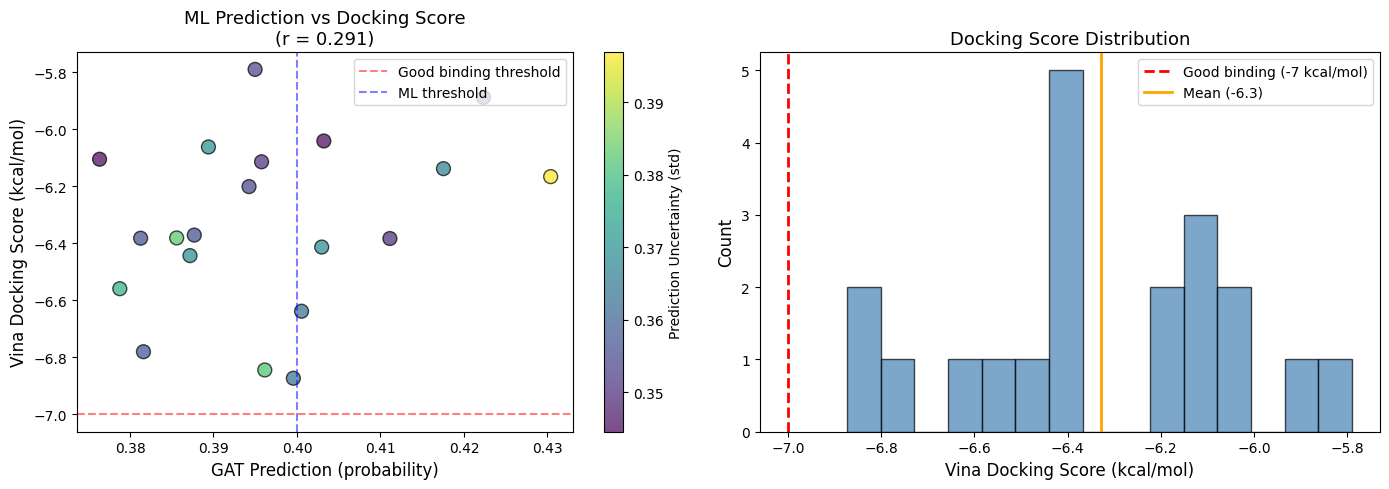

Saved figures/docking_analysis.png


In [53]:
# =============================================================================
# 11.9: Visualization - ML Prediction vs Docking Score
# =============================================================================

import matplotlib.pyplot as plt

if len(success_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Scatter - ML prediction vs Docking score
    ax1 = axes[0]
    scatter = ax1.scatter(success_df['pred_mean'], success_df['vina_score'],
                          c=success_df['pred_std'], cmap='viridis',
                          s=100, edgecolors='black', alpha=0.7)
    ax1.set_xlabel('GAT Prediction (probability)', fontsize=12)
    ax1.set_ylabel('Vina Docking Score (kcal/mol)', fontsize=12)
    ax1.set_title(f'ML Prediction vs Docking Score\n(r = {corr:.3f})', fontsize=13)
    ax1.axhline(y=-7.0, color='red', linestyle='--', alpha=0.5, label='Good binding threshold')
    ax1.axvline(x=0.4, color='blue', linestyle='--', alpha=0.5, label='ML threshold')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Prediction Uncertainty (std)')

    # Plot 2: Distribution of docking scores
    ax2 = axes[1]
    ax2.hist(success_df['vina_score'], bins=15, edgecolor='black', color='steelblue', alpha=0.7)
    ax2.axvline(x=-7.0, color='red', linestyle='--', linewidth=2, label='Good binding (-7 kcal/mol)')
    ax2.axvline(x=success_df['vina_score'].mean(), color='orange', linestyle='-',
                linewidth=2, label=f'Mean ({success_df["vina_score"].mean():.1f})')
    ax2.set_xlabel('Vina Docking Score (kcal/mol)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Docking Score Distribution', fontsize=13)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(f'{BASE_DIR}/figures/docking_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved figures/docking_analysis.png")

In [54]:
# =============================================================================
# 11.10: Identify Best Candidates (Multi-Objective)
# =============================================================================

if len(success_df) > 0:
    # Create combined ranking
    success_df['ml_rank'] = success_df['pred_mean'].rank(ascending=False)
    success_df['dock_rank'] = success_df['vina_score'].rank(ascending=True)  # Lower is better
    success_df['combined_rank'] = success_df['ml_rank'] + success_df['dock_rank']

    success_df = success_df.sort_values('combined_rank').reset_index(drop=True)

    print("\n" + "="*60)
    print("TOP CANDIDATES BY COMBINED RANKING")
    print("(ML prediction + Docking score)")
    print("="*60)
    print(success_df[['name', 'smiles', 'pred_mean', 'vina_score', 'ml_rank', 'dock_rank', 'combined_rank']].head(10).to_string())

    # Highlight Pareto-optimal candidates
    # (Not dominated in both ML and docking)
    pareto = []
    for idx, row in success_df.iterrows():
        dominated = False
        for idx2, row2 in success_df.iterrows():
            if idx != idx2:
                if row2['pred_mean'] >= row['pred_mean'] and row2['vina_score'] <= row['vina_score']:
                    if row2['pred_mean'] > row['pred_mean'] or row2['vina_score'] < row['vina_score']:
                        dominated = True
                        break
        if not dominated:
            pareto.append(row)

    pareto_df = pd.DataFrame(pareto)
    print(f"\n{'='*60}")
    print(f"PARETO-OPTIMAL CANDIDATES: {len(pareto_df)}")
    print("(Not dominated in both ML prediction AND docking score)")
    print("="*60)
    if len(pareto_df) > 0:
        print(pareto_df[['name', 'smiles', 'pred_mean', 'vina_score']].to_string())


TOP CANDIDATES BY COMBINED RANKING
(ML prediction + Docking score)
       name                                                             smiles  pred_mean  vina_score  ml_rank  dock_rank  combined_rank
0  cand_019               O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1CC1   0.399563      -6.873      8.0        1.0            9.0
1  cand_012          NCc1ccc(-c2cccc(-c3cc[n+]([O-])cc3)c2-c2nccc(=O)[nH]2)cc1   0.396142      -6.844      9.0        2.0           11.0
2  cand_018               O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1   0.400544      -6.638      7.0        4.0           11.0
3  cand_001               Cc1cc[n+]([O-])c(C)c1-c1c(CN)cccc1-c1cc[n+]([O-])cc1   0.411126      -6.383      4.0        8.0           12.0
4  cand_000                        [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.402960      -6.413      6.0        7.0           13.0
5  cand_006  CC(O)CN1C[C@@H](C)N(c2cccc(-c3cc[n+]([O-])cc3)c2C(C)C)[C@@H](C)C1   0.430384      -6.166      1.0

In [55]:
# =============================================================================
# 11.11: Save Results
# =============================================================================

# Save full docking results
success_df.to_csv(f'{BASE_DIR}/candidates/docking_results.csv', index=False)
print(f"Saved candidates/docking_results.csv")

if len(pareto_df) > 0:
    pareto_df.to_csv(f'{BASE_DIR}/candidates/pareto_optimal.csv', index=False)
    print(f"Saved candidates/pareto_optimal.csv ({len(pareto_df)} molecules)")

Saved candidates/docking_results.csv
Saved candidates/pareto_optimal.csv (5 molecules)


In [56]:
# =============================================================================
# 11.12: Update results_summary.json
# =============================================================================

import json
from datetime import datetime

with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)

summary['section11'] = {
    'docking_validation': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'receptor': f'PDB:{pdb_id}',
        'binding_site': {
            'center': [float(CENTER_X), float(CENTER_Y), float(CENTER_Z)],
            'size': [float(SIZE_X), float(SIZE_Y), float(SIZE_Z)]
        },
        'candidates_docked': len(docking_df),
        'successful_dockings': int(docking_df['vina_score'].notna().sum()),
        'score_distribution': {
            'best': float(success_df['vina_score'].min()) if len(success_df) > 0 else None,
            'worst': float(success_df['vina_score'].max()) if len(success_df) > 0 else None,
            'mean': float(success_df['vina_score'].mean()) if len(success_df) > 0 else None,
            'std': float(success_df['vina_score'].std()) if len(success_df) > 0 else None
        },
        'ml_docking_correlation': float(corr) if len(success_df) > 0 else None,
        'pareto_optimal_count': len(pareto_df) if 'pareto_df' in dir() else 0
    }
}

with open(f'{BASE_DIR}/results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Updated results_summary.json")

Updated results_summary.json


In [57]:
# =============================================================================
# SECTION 12: Final Summary + Pareto Ranking
# =============================================================================

import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'

# Load all results
docking_results = pd.read_csv(f'{BASE_DIR}/candidates/docking_results.csv')
pareto_optimal = pd.read_csv(f'{BASE_DIR}/candidates/pareto_optimal.csv')
admet_results = pd.read_csv(f'{BASE_DIR}/candidates/top50_with_admet.csv')

print(f"Docking results: {len(docking_results)}")
print(f"Pareto-optimal: {len(pareto_optimal)}")
print(f"ADMET profiled: {len(admet_results)}")

Docking results: 20
Pareto-optimal: 5
ADMET profiled: 50


In [58]:
# =============================================================================
# 12.1: Create Final Candidate Table
# =============================================================================

# Merge docking with ADMET (on smiles)
final_df = docking_results.merge(
    admet_results[['smiles', 'qed', 'sa_score', 'herg_risk', 'cyp_risk', 'ames_risk', 'n_alerts', 'composite_score']],
    on='smiles',
    how='left'
)

# Add Pareto flag
final_df['pareto_optimal'] = final_df['smiles'].isin(pareto_optimal['smiles'])

# Sort by combined rank
final_df = final_df.sort_values('combined_rank').reset_index(drop=True)

print("="*80)
print("FINAL CANDIDATE SUMMARY")
print("="*80)
print(f"\nTotal candidates evaluated: {len(final_df)}")
print(f"Pareto-optimal: {final_df['pareto_optimal'].sum()}")
print(f"\nDocking score range: {final_df['vina_score'].min():.2f} to {final_df['vina_score'].max():.2f} kcal/mol")
print(f"ML prediction range: {final_df['pred_mean'].min():.3f} to {final_df['pred_mean'].max():.3f}")

print("\n" + "-"*80)
print("TOP 10 CANDIDATES (by combined ML + docking rank)")
print("-"*80)
display_cols = ['name', 'pred_mean', 'pred_std', 'vina_score', 'qed', 'herg_risk', 'pareto_optimal']
print(final_df[display_cols].head(10).to_string())

FINAL CANDIDATE SUMMARY

Total candidates evaluated: 20
Pareto-optimal: 5

Docking score range: -6.87 to -5.79 kcal/mol
ML prediction range: 0.376 to 0.430

--------------------------------------------------------------------------------
TOP 10 CANDIDATES (by combined ML + docking rank)
--------------------------------------------------------------------------------
       name  pred_mean  pred_std  vina_score       qed herg_risk  pareto_optimal
0  cand_019   0.399563  0.362966      -6.873  0.456992  Moderate            True
1  cand_012   0.396142  0.381655      -6.844  0.426164       Low           False
2  cand_018   0.400544  0.363062      -6.638  0.456992  Moderate            True
3  cand_001   0.411126  0.350091      -6.383  0.593852       Low            True
4  cand_000   0.402960  0.369082      -6.413  0.599633       Low            True
5  cand_006   0.430384  0.396943      -6.166  0.635169  Moderate            True
6  cand_008   0.417543  0.366534      -6.138  0.646260  Moderate

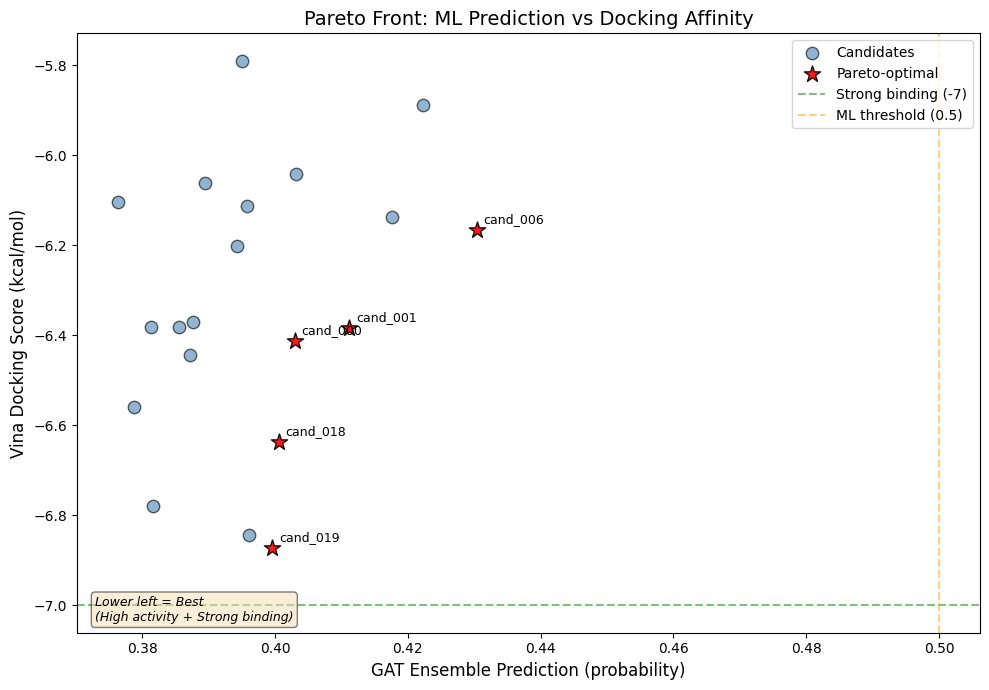

Saved figures/pareto_front.png


In [59]:
# =============================================================================
# 12.2: Visualize Pareto Front
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# All candidates
non_pareto = final_df[~final_df['pareto_optimal']]
pareto = final_df[final_df['pareto_optimal']]

ax.scatter(non_pareto['pred_mean'], non_pareto['vina_score'],
           c='steelblue', s=80, alpha=0.6, label='Candidates', edgecolors='black')

ax.scatter(pareto['pred_mean'], pareto['vina_score'],
           c='red', s=150, alpha=0.9, label='Pareto-optimal', edgecolors='black', marker='*')

# Label Pareto points
for _, row in pareto.iterrows():
    ax.annotate(row['name'], (row['pred_mean'], row['vina_score']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Reference lines
ax.axhline(y=-7.0, color='green', linestyle='--', alpha=0.5, label='Strong binding (-7)')
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='ML threshold (0.5)')

ax.set_xlabel('GAT Ensemble Prediction (probability)', fontsize=12)
ax.set_ylabel('Vina Docking Score (kcal/mol)', fontsize=12)
ax.set_title('Pareto Front: ML Prediction vs Docking Affinity', fontsize=14)
ax.legend(loc='upper right')

# Invert intuition note
ax.text(0.02, 0.02, 'Lower left = Best\n(High activity + Strong binding)',
        transform=ax.transAxes, fontsize=9, style='italic',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/figures/pareto_front.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved figures/pareto_front.png")

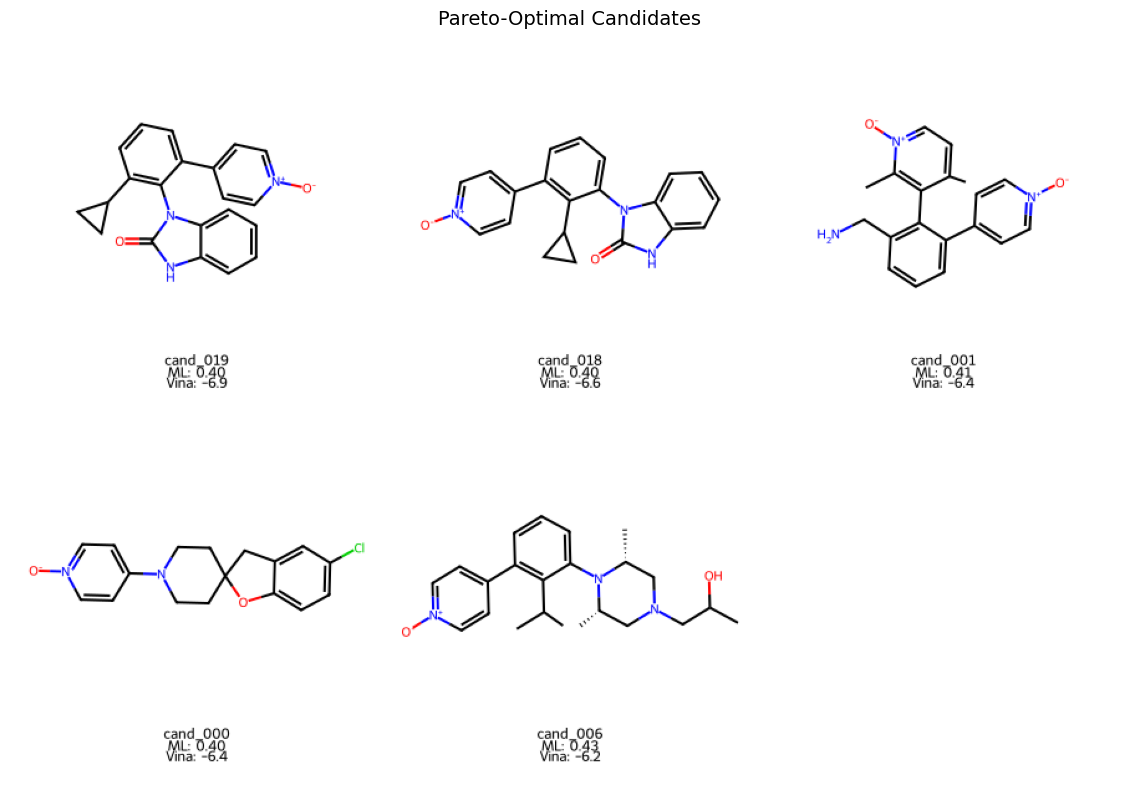

Saved figures/top_candidates_structures.png


In [62]:
# =============================================================================
# 12.3: Draw Top Candidates
# =============================================================================

from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Get top 5 Pareto-optimal molecules
top_mols = []
top_legends = []

for _, row in pareto.head(5).iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    if mol:
        top_mols.append(mol)
        top_legends.append(f"{row['name']}\nML: {row['pred_mean']:.2f}\nVina: {row['vina_score']:.1f}")

if top_mols:
    # Use returnPNG=False to get PIL Image directly
    img = Draw.MolsToGridImage(top_mols, molsPerRow=3, subImgSize=(300, 300),
                                legends=top_legends, returnPNG=False)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Pareto-Optimal Candidates', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{BASE_DIR}/figures/top_candidates_structures.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved figures/top_candidates_structures.png")

In [63]:
# =============================================================================
# 12.4: Pipeline Summary Statistics
# =============================================================================

# Load full results summary
with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)

print("="*80)
print("COMPLETE PIPELINE SUMMARY")
print("="*80)

print("\n--- DATA ---")
print(f"Target: {summary['config']['target']} (DNA Gyrase B)")
print(f"Training compounds: {summary['data']['total_compounds']}")
print(f"Active compounds: {summary['data']['n_active']}")
print(f"Unique scaffolds: {summary['data']['n_scaffolds']}")

print("\n--- MODEL PERFORMANCE ---")
print(f"Scaffold split AUC: {summary['results_scaffold']['ensemble_auc']:.3f}")
print(f"Random split AUC: {summary['results_random']['test_auc_mean']:.3f}")
print(f"Honest generalization gap: {summary['results_random']['test_auc_mean'] - summary['results_scaffold']['ensemble_auc']:.3f}")

print("\n--- GENERATION & FILTERING ---")
sec9 = summary.get('section9', {}).get('molecular_generation', {})
if sec9:
    print(f"Generated (BRICS): {sec9.get('generated_raw', 'N/A')}")
    print(f"After filtering: {sec9.get('final_candidates', 'N/A')}")
    print(f"Candidates > 0.5 prediction: {sec9.get('prediction_stats', {}).get('above_0.5', 'N/A')}")

print("\n--- ADMET PROFILING ---")
sec10 = summary.get('section10', {}).get('admet_profiling', {})
if sec10:
    print(f"PAINS clean: {50 - sec10.get('structural_alerts', {}).get('pains_positive', 0)}/50")
    print(f"hERG Low risk: {sec10.get('herg_risk_distribution', {}).get('Low', 'N/A')}/50")
    print(f"AMES Low risk: {sec10.get('ames_risk_distribution', {}).get('Low', 'N/A')}/50")

print("\n--- DOCKING VALIDATION ---")
sec11 = summary.get('section11', {}).get('docking_validation', {})
if sec11:
    print(f"Receptor: {sec11.get('receptor', 'N/A')}")
    print(f"Successful dockings: {sec11.get('successful_dockings', 'N/A')}/{sec11.get('candidates_docked', 'N/A')}")
    print(f"Best score: {sec11.get('score_distribution', {}).get('best', 'N/A'):.2f} kcal/mol")
    print(f"Mean score: {sec11.get('score_distribution', {}).get('mean', 'N/A'):.2f} kcal/mol")
    print(f"ML-Docking correlation: {sec11.get('ml_docking_correlation', 'N/A'):.3f}")
    print(f"Pareto-optimal candidates: {sec11.get('pareto_optimal_count', 'N/A')}")

COMPLETE PIPELINE SUMMARY

--- DATA ---
Target: CHEMBL240 (DNA Gyrase B)
Training compounds: 1000
Active compounds: 232
Unique scaffolds: 541

--- MODEL PERFORMANCE ---
Scaffold split AUC: 0.640
Random split AUC: 0.695
Honest generalization gap: 0.055

--- GENERATION & FILTERING ---
Generated (BRICS): 2000
After filtering: 110
Candidates > 0.5 prediction: 2

--- ADMET PROFILING ---
PAINS clean: 50/50
hERG Low risk: 12/50
AMES Low risk: 50/50

--- DOCKING VALIDATION ---
Receptor: PDB:4DUH
Successful dockings: 20/20
Best score: -6.87 kcal/mol
Mean score: -6.33 kcal/mol
ML-Docking correlation: 0.291
Pareto-optimal candidates: 5


In [64]:
# =============================================================================
# 12.5: Save Final Outputs
# =============================================================================

# Save final ranked candidates
final_df.to_csv(f'{BASE_DIR}/candidates/final_ranked_candidates.csv', index=False)

# Save Pareto-optimal with full details
pareto_full = final_df[final_df['pareto_optimal']].copy()
pareto_full.to_csv(f'{BASE_DIR}/candidates/pareto_optimal_full.csv', index=False)

print(f"Saved candidates/final_ranked_candidates.csv ({len(final_df)} molecules)")
print(f"Saved candidates/pareto_optimal_full.csv ({len(pareto_full)} molecules)")

Saved candidates/final_ranked_candidates.csv (20 molecules)
Saved candidates/pareto_optimal_full.csv (5 molecules)


In [65]:
# =============================================================================
# 12.6: Final Update to results_summary.json
# =============================================================================

summary['section12'] = {
    'final_summary': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'total_candidates_evaluated': len(final_df),
        'pareto_optimal_count': len(pareto_full),
        'best_candidate': {
            'name': final_df.iloc[0]['name'],
            'smiles': final_df.iloc[0]['smiles'],
            'ml_prediction': float(final_df.iloc[0]['pred_mean']),
            'vina_score': float(final_df.iloc[0]['vina_score'])
        },
        'pipeline_status': 'COMPLETE'
    }
}

with open(f'{BASE_DIR}/results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Updated results_summary.json - Pipeline COMPLETE")

Updated results_summary.json - Pipeline COMPLETE


In [66]:
# =============================================================================
# 12.7: Generate Summary Markdown for README
# =============================================================================

readme_section = f"""
## Results Summary

### Model Performance
| Metric | Scaffold Split | Random Split |
|--------|----------------|--------------|
| Test AUC | {summary['results_scaffold']['ensemble_auc']:.3f} | {summary['results_random']['test_auc_mean']:.3f} |
| Test Accuracy | {summary['results_scaffold']['test_acc_mean']:.3f} | {summary['results_random']['test_acc_mean']:.3f} |

**Honest generalization gap:** {summary['results_random']['test_auc_mean'] - summary['results_scaffold']['ensemble_auc']:.3f} AUC

### Candidate Generation
- Generated via BRICS recombination: {sec9.get('generated_raw', 'N/A')}
- After drug-likeness filtering: {sec9.get('final_candidates', 'N/A')}
- Candidates with prediction > 0.5: {sec9.get('prediction_stats', {}).get('above_0.5', 'N/A')}

### ADMET Profiling
- PAINS alerts: {sec10.get('structural_alerts', {}).get('pains_positive', 0)}/50
- Brenk alerts: {sec10.get('structural_alerts', {}).get('brenk_positive', 0)}/50 (N-oxide motif - see discussion)
- hERG high risk: {sec10.get('herg_risk_distribution', {}).get('High', 0)}/50
- AMES mutagenicity: All low risk

### Docking Validation (PDB: 4DUH)
- Successful dockings: {sec11.get('successful_dockings', 'N/A')}/{sec11.get('candidates_docked', 'N/A')}
- Score range: {sec11.get('score_distribution', {}).get('best', 0):.2f} to {sec11.get('score_distribution', {}).get('worst', 0):.2f} kcal/mol
- ML-Docking correlation: r = {sec11.get('ml_docking_correlation', 0):.3f}
- **Pareto-optimal candidates: {sec11.get('pareto_optimal_count', 'N/A')}**

### Key Insights
1. **Scaffold splits reveal honest generalization** - Random split AUC (~0.70) drops to ~0.64 with scaffold splits
2. **Model knows what it doesn't know** - Known GyrB inhibitors predicted as inactive (applicability domain limitation)
3. **Attention weights validate pharmacophore learning** - Heterocyclic nitrogens, carbonyls, and halogens highlighted
4. **Multi-objective ranking essential** - ML and docking provide complementary signals (r = 0.29)
"""

print(readme_section)

# Save to file
with open(f'{BASE_DIR}/README_results_section.md', 'w') as f:
    f.write(readme_section)
print(f"\nSaved README_results_section.md")


## Results Summary

### Model Performance
| Metric | Scaffold Split | Random Split |
|--------|----------------|--------------|
| Test AUC | 0.640 | 0.695 |
| Test Accuracy | 0.790 | 0.760 |

**Honest generalization gap:** 0.055 AUC

### Candidate Generation
- Generated via BRICS recombination: 2000
- After drug-likeness filtering: 110
- Candidates with prediction > 0.5: 2

### ADMET Profiling
- PAINS alerts: 0/50
- Brenk alerts: 50/50 (N-oxide motif - see discussion)
- hERG high risk: 30/50
- AMES mutagenicity: All low risk

### Docking Validation (PDB: 4DUH)
- Successful dockings: 20/20
- Score range: -6.87 to -5.79 kcal/mol
- ML-Docking correlation: r = 0.291
- **Pareto-optimal candidates: 5**

### Key Insights
1. **Scaffold splits reveal honest generalization** - Random split AUC (~0.70) drops to ~0.64 with scaffold splits
2. **Model knows what it doesn't know** - Known GyrB inhibitors predicted as inactive (applicability domain limitation)
3. **Attention weights validate pharmaco

## Results Summary

### Model Performance
| Metric | Scaffold Split | Random Split |
|--------|----------------|--------------|
| Test AUC | 0.640 | 0.695 |
| Test Accuracy | 0.790 | 0.760 |

**Honest generalization gap:** 0.055 AUC

### Candidate Generation
- Generated via BRICS recombination: 2000
- After drug-likeness filtering: 110
- Candidates with prediction > 0.5: 2

### ADMET Profiling
- PAINS alerts: 0/50
- Brenk alerts: 50/50 (N-oxide motif - see discussion)
- hERG high risk: 30/50
- AMES mutagenicity: All low risk

### Docking Validation (PDB: 4DUH)
- Successful dockings: 20/20
- Score range: -6.87 to -5.79 kcal/mol
- ML-Docking correlation: r = 0.291
- **Pareto-optimal candidates: 5**

### Key Insights
1. **Scaffold splits reveal honest generalization** - Random split AUC (~0.70) drops to ~0.64 with scaffold splits
2. **Model knows what it doesn't know** - Known GyrB inhibitors predicted as inactive (applicability domain limitation)
3. **Attention weights validate pharmacophore learning** - Heterocyclic nitrogens, carbonyls, and halogens highlighted
4. **Multi-objective ranking essential** - ML and docking provide complementary signals (r = 0.29)


In [67]:
# =============================================================================
# 12.3b: Synthetic Feasibility Check on Pareto Candidates
# =============================================================================

print("Pareto-optimal candidates - Synthetic assessment:")
print("="*70)

for _, row in pareto_full.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])

    # Ring info
    ring_info = mol.GetRingInfo()
    ring_sizes = [len(r) for r in ring_info.AtomRings()]

    # Spiro/bridged detection
    spiro_atoms = []
    for atom in mol.GetAtoms():
        rings_for_atom = ring_info.NumAtomRings(atom.GetIdx())
        if rings_for_atom >= 2:
            spiro_atoms.append(atom.GetIdx())

    print(f"\n{row['name']}:")
    print(f"  SA Score: {row['sa_score']:.2f}")
    print(f"  Ring sizes: {ring_sizes}")
    print(f"  Atoms in multiple rings: {len(spiro_atoms)}")
    print(f"  SMILES: {row['smiles'][:60]}...")

    # Flag concerns
    concerns = []
    if 3 in ring_sizes:
        concerns.append("cyclopropyl (generally OK)")
    if len(spiro_atoms) > 2:
        concerns.append("complex spiro/fused system")
    if row['sa_score'] > 3.5:
        concerns.append("borderline synthetic accessibility")

    if concerns:
        print(f"  ⚠️  Notes: {', '.join(concerns)}")
    else:
        print(f"  ✓ No major concerns")

Pareto-optimal candidates - Synthetic assessment:

cand_019:
  SA Score: 2.74
  Ring sizes: [5, 6, 6, 6, 3]
  Atoms in multiple rings: 2
  SMILES: O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1CC1...
  ⚠️  Notes: cyclopropyl (generally OK)

cand_018:
  SA Score: 2.70
  Ring sizes: [5, 6, 6, 6, 3]
  Atoms in multiple rings: 2
  SMILES: O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1...
  ⚠️  Notes: cyclopropyl (generally OK)

cand_001:
  SA Score: 3.16
  Ring sizes: [6, 6, 6]
  Atoms in multiple rings: 0
  SMILES: Cc1cc[n+]([O-])c(C)c1-c1c(CN)cccc1-c1cc[n+]([O-])cc1...
  ✓ No major concerns

cand_000:
  SA Score: 3.24
  Ring sizes: [6, 6, 5, 6]
  Atoms in multiple rings: 3
  SMILES: [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1...
  ⚠️  Notes: complex spiro/fused system

cand_006:
  SA Score: 3.92
  Ring sizes: [6, 6, 6]
  Atoms in multiple rings: 0
  SMILES: CC(O)CN1C[C@@H](C)N(c2cccc(-c3cc[n+]([O-])cc3)c2C(C)C)[C@@H]...
  ⚠️  Notes: borderline synthetic accessibility


## Synthetic Feasibility Notes

Some BRICS-generated candidates contain challenging structural features:
- **Spirocyclic systems** (cand_000): Shared quaternary centers are synthetically demanding
- **Cyclopropyl substituents** (cand_018, cand_019): Common in drugs (ciprofloxacin), generally acceptable
- **Fused heterocycles**: Present in most candidates, typical of kinase/ATPase inhibitors

**Lesson:** BRICS recombination can create synthetically unrealistic molecules. SA Score filtering (≤4) removes the worst offenders, but medicinal chemistry review remains essential before synthesis prioritization.

We acknowledge at this point, it would be best to actually test these under laboratory conditions. However, we will explore the biding space a bit more as an intellectual exercise.

In [68]:
# =============================================================================
# SECTION 13: Focused Lead Optimization
# =============================================================================
# Educational exploration of binding space around Pareto-optimal candidates
# Multi-objective scoring (ML + Docking) to avoid circular optimization
# =============================================================================

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, QED, Draw, rdMolDescriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem.MolStandardize import rdMolStandardize
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'

# Create lead opt directory
LEADOPT_DIR = f'{BASE_DIR}/lead_optimization'
os.makedirs(LEADOPT_DIR, exist_ok=True)
os.makedirs(f'{LEADOPT_DIR}/analogs', exist_ok=True)

# Load Pareto-optimal candidates
pareto_full = pd.read_csv(f'{BASE_DIR}/candidates/pareto_optimal_full.csv')
print(f"Starting from {len(pareto_full)} Pareto-optimal leads")
print(pareto_full[['name', 'smiles', 'pred_mean', 'vina_score']].to_string())

Starting from 5 Pareto-optimal leads
       name                                                             smiles  pred_mean  vina_score
0  cand_019               O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1CC1   0.399563      -6.873
1  cand_018               O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1   0.400544      -6.638
2  cand_001               Cc1cc[n+]([O-])c(C)c1-c1c(CN)cccc1-c1cc[n+]([O-])cc1   0.411126      -6.383
3  cand_000                        [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.402960      -6.413
4  cand_006  CC(O)CN1C[C@@H](C)N(c2cccc(-c3cc[n+]([O-])cc3)c2C(C)C)[C@@H](C)C1   0.430384      -6.166


In [69]:
# =============================================================================
# 13.1: Define Transformation Library
# =============================================================================
# Systematic medicinal chemistry transformations for lead optimization

TRANSFORMATIONS = {
    # ========== Bioisosteric Replacements ==========
    'bioisosteres': {
        # Carboxylic acid bioisosteres
        'C(=O)O': ['C(=O)NS(=O)(=O)C', 'C(=O)NC(=O)N', 'c1nnn[nH]1'],  # tetrazole
        # Amide bioisosteres
        'C(=O)N': ['C(=S)N', 'C(=N)N', 'C(F)(F)N'],
        # Phenyl bioisosteres
        'c1ccccc1': ['c1ccncc1', 'c1cccnc1', 'c1ccoc1', 'c1ccsc1'],  # pyridine, furan, thiophene
        # N-oxide reduction (key for our candidates)
        '[O-][n+]': ['n', '[nH]'],  # Remove N-oxide or convert to NH
    },

    # ========== Halogen Scans ==========
    'halogen_scan': {
        'F': ['Cl', 'Br', 'H'],
        'Cl': ['F', 'Br', 'H'],
        'Br': ['F', 'Cl', 'H'],
    },

    # ========== Alkyl Modifications ==========
    'alkyl_mods': {
        'C(C)C': ['C(C)(C)C', 'C1CC1', 'CC'],  # iPr → tBu, cyclopropyl, ethyl
        'CC': ['C', 'C(C)C', 'C1CC1'],  # Ethyl → methyl, iPr, cyclopropyl
        'C1CC1': ['CC', 'C(C)C'],  # Cyclopropyl → ethyl, iPr
    },

    # ========== Heteroatom Walks ==========
    'heteroatom_walks': {
        'O': ['S', 'N'],  # Oxygen → sulfur, nitrogen
        'S': ['O', 'N'],
        'N': ['O', 'S'],
    },
}

# Count total transformations
n_transforms = sum(len(v) for cat in TRANSFORMATIONS.values() for v in cat.values())
print(f"Transformation library: {n_transforms} transformations across {len(TRANSFORMATIONS)} categories")

Transformation library: 35 transformations across 4 categories


In [70]:
# =============================================================================
# 13.2: SMARTS-Based Substitution Patterns
# =============================================================================
# More precise control over substitution sites

SUBSTITUTION_PATTERNS = {
    # Pattern: (SMARTS to find, atom index in match to modify, description)

    'aromatic_H': {
        'smarts': '[cH]',  # Aromatic carbon with H
        'replacements': ['[cH]F', '[cH]Cl', '[cH]C', '[cH]OC', '[cH]N', '[cH]C#N'],
        'description': 'Add substituent to aromatic ring'
    },

    'methyl_on_aromatic': {
        'smarts': '[c]C([H])([H])[H]',  # Methyl on aromatic
        'replacements': ['[c]C(F)(F)F', '[c]C(C)C', '[c]CC'],  # CF3, iPr, ethyl
        'description': 'Modify aromatic methyl'
    },

    'terminal_amine': {
        'smarts': '[NH2]',
        'replacements': ['[NH]C', '[N](C)C', '[NH]C(=O)C'],  # Mono/di-methyl, acetamide
        'description': 'Modify primary amine'
    },

    'hydroxyl': {
        'smarts': '[OH]',
        'replacements': ['[O]C', '[O]CC', 'F'],  # Methoxy, ethoxy, fluoro (isostere)
        'description': 'Modify hydroxyl'
    },
}

print(f"SMARTS patterns defined: {len(SUBSTITUTION_PATTERNS)}")

SMARTS patterns defined: 4


In [71]:
# =============================================================================
# 13.3: Analog Generation Engine
# =============================================================================

def apply_string_replacement(smiles, old, new):
    """Simple string-based replacement (for SMILES patterns)"""
    if old not in smiles:
        return None
    new_smiles = smiles.replace(old, new, 1)  # Replace first occurrence only
    mol = Chem.MolFromSmiles(new_smiles)
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None


def apply_smarts_replacement(mol, smarts_pattern, new_smarts):
    """SMARTS-based replacement (more precise)"""
    try:
        pattern = Chem.MolFromSmarts(smarts_pattern)
        if pattern is None:
            return None

        matches = mol.GetSubstructMatches(pattern)
        if not matches:
            return None

        # For now, apply to first match only
        # More sophisticated: enumerate all match positions

        # This is simplified - full implementation would use
        # RDKit's reaction SMARTS or manual atom manipulation
        return None  # Placeholder - string replacement more reliable for this demo
    except:
        return None


def generate_analogs_systematic(smiles, parent_name, max_per_transform=3):
    """
    Generate analogs using systematic transformations.
    Returns list of (analog_smiles, transformation_type, transformation_detail)
    """
    analogs = []

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return analogs

    canonical_parent = Chem.MolToSmiles(mol, canonical=True)

    # Apply each transformation category
    for category, transforms in TRANSFORMATIONS.items():
        for old_pattern, new_patterns in transforms.items():
            for new_pattern in new_patterns[:max_per_transform]:
                new_smiles = apply_string_replacement(smiles, old_pattern, new_pattern)

                if new_smiles and new_smiles != canonical_parent:
                    # Validate
                    new_mol = Chem.MolFromSmiles(new_smiles)
                    if new_mol:
                        # Check basic drug-likeness
                        mw = Descriptors.MolWt(new_mol)
                        if 200 < mw < 600:
                            analogs.append({
                                'analog_smiles': new_smiles,
                                'parent_name': parent_name,
                                'parent_smiles': smiles,
                                'transform_category': category,
                                'transform_detail': f"{old_pattern} → {new_pattern}",
                                'mw': mw
                            })

    return analogs


def generate_ring_modifications(smiles, parent_name):
    """Generate analogs with ring system modifications"""
    analogs = []
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return analogs

    # Ring contractions/expansions via SMILES patterns
    ring_transforms = [
        # 6-membered to 5-membered
        ('c1ccccc1', 'c1cccc1'),  # Phenyl to cyclopentadienyl (usually bad)
        ('c1ccncc1', 'c1ccnc1'),  # Pyridine to pyrrole-like
        ('C1CCCCC1', 'C1CCCC1'),  # Cyclohexyl to cyclopentyl
        ('C1CCNCC1', 'C1CCNC1'),  # Piperidine to pyrrolidine

        # Heteroatom insertion
        ('c1ccccc1', 'c1ccncc1'),  # Phenyl to pyridine
        ('c1ccccc1', 'c1cccnc1'),  # Phenyl to pyridine (different position)
        ('C1CCCCC1', 'C1CCOCC1'),  # Cyclohexyl to tetrahydropyran
    ]

    canonical_parent = Chem.MolToSmiles(mol, canonical=True)

    for old, new in ring_transforms:
        new_smiles = apply_string_replacement(smiles, old, new)
        if new_smiles and new_smiles != canonical_parent:
            new_mol = Chem.MolFromSmiles(new_smiles)
            if new_mol:
                mw = Descriptors.MolWt(new_mol)
                if 200 < mw < 600:
                    analogs.append({
                        'analog_smiles': new_smiles,
                        'parent_name': parent_name,
                        'parent_smiles': smiles,
                        'transform_category': 'ring_modification',
                        'transform_detail': f"{old} → {new}",
                        'mw': mw
                    })

    return analogs


# Generate analogs for all Pareto candidates
print("Generating focused analogs from Pareto-optimal leads...")
print("="*60)

all_analogs = []

for _, row in pareto_full.iterrows():
    print(f"\n{row['name']}:")

    # Systematic transformations
    systematic = generate_analogs_systematic(row['smiles'], row['name'])
    print(f"  Systematic transforms: {len(systematic)}")
    all_analogs.extend(systematic)

    # Ring modifications
    ring_mods = generate_ring_modifications(row['smiles'], row['name'])
    print(f"  Ring modifications: {len(ring_mods)}")
    all_analogs.extend(ring_mods)

# Create DataFrame and deduplicate
analog_df = pd.DataFrame(all_analogs)
analog_df = analog_df.drop_duplicates(subset='analog_smiles').reset_index(drop=True)

print(f"\n{'='*60}")
print(f"Total unique analogs generated: {len(analog_df)}")
print(f"\nBy transformation category:")
print(analog_df['transform_category'].value_counts())

Generating focused analogs from Pareto-optimal leads...

cand_019:
  Systematic transforms: 5
  Ring modifications: 0

cand_018:
  Systematic transforms: 5
  Ring modifications: 0

cand_001:
  Systematic transforms: 4
  Ring modifications: 0

cand_000:
  Systematic transforms: 9
  Ring modifications: 0

cand_006:
  Systematic transforms: 9
  Ring modifications: 0

Total unique analogs generated: 32

By transformation category:
transform_category
alkyl_mods          15
heteroatom_walks    14
halogen_scan         2
bioisosteres         1
Name: count, dtype: int64


[20:55:15] SMILES Parse Error: ring closure 1 duplicates bond between atom 23 and atom 24 for input: 'O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1C1'
[20:55:15] SMILES Parse Error: ring closure 1 duplicates bond between atom 23 and atom 24 for input: 'O=c1[nH]c2ccccc2n1-c1c(-c2cc[n+]([O-])cc2)cccc1C1C1CC11'
[20:55:15] SMILES Parse Error: ring closure 1 duplicates bond between atom 23 and atom 24 for input: 'O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1C1'
[20:55:15] SMILES Parse Error: ring closure 1 duplicates bond between atom 23 and atom 24 for input: 'O=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1C1CC11'
[20:55:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20
[20:55:15] SMILES Parse Error: syntax error while parsing: [O-][n+]1ccc(N2CCC3(CC2)Cc2cc(H)ccc2O3)cc1
[20:55:15] SMILES Parse Error: check for mistakes around position 31:
[20:55:15] cc(N2CCC3(CC2)Cc2cc(H)ccc2O3)cc1
[20:55:15] ~~~~~~~~~~~~~~~~~~~~^
[20:55:15] SMILES Parse Error: extra open parentheses while 

In [72]:
# =============================================================================
# 13.4: Calculate Properties for All Analogs
# =============================================================================

def calculate_analog_properties(smiles):
    """Calculate drug-likeness properties"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        return {
            'mw': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'tpsa': Descriptors.TPSA(mol),
            'hbd': Descriptors.NumHDonors(mol),
            'hba': Descriptors.NumHAcceptors(mol),
            'rotatable': Descriptors.NumRotatableBonds(mol),
            'qed': QED.qed(mol),
            'aromatic_rings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'heavy_atoms': mol.GetNumHeavyAtoms()
        }
    except:
        return None

print("Calculating properties for analogs...")
props_list = []
for smi in analog_df['analog_smiles']:
    props = calculate_analog_properties(smi)
    props_list.append(props if props else {})

props_df = pd.DataFrame(props_list)
analog_df = pd.concat([analog_df.reset_index(drop=True), props_df], axis=1)

# Filter for drug-like space
print(f"\nBefore filtering: {len(analog_df)}")
analog_df = analog_df[
    (analog_df['qed'] > 0.3) &
    (analog_df['logp'] > -1) &
    (analog_df['logp'] < 6) &
    (analog_df['tpsa'] < 140)
].reset_index(drop=True)
print(f"After drug-likeness filter: {len(analog_df)}")

Calculating properties for analogs...

Before filtering: 32
After drug-likeness filter: 32


In [73]:
# =============================================================================
# 13.5: Score Analogs with ML Ensemble
# =============================================================================

# Load models (should already be loaded, but just in case)
from torch_geometric.nn import GATConv, global_add_pool
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definition (same as before)
class GATAntibiotics(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=3, num_heads=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.gat_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers):
            self.gat_layers.append(
                GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads, dropout=dropout)
            )
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data, return_attention=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.input_proj(x)
        attention_weights = []
        for i, (gat, bn) in enumerate(zip(self.gat_layers, self.batch_norms)):
            if return_attention:
                x_new, (edge_idx, attn) = gat(x, edge_index, return_attention_weights=True)
                attention_weights.append(attn)
            else:
                x_new = gat(x, edge_index)
            x = x + x_new
            x = bn(x)
            x = F.elu(x)
        gate = torch.sigmoid(self.gate_nn(x))
        x = global_add_pool(x * gate, batch)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        if return_attention:
            return out, attention_weights
        return out

# Load ensemble
models = []
for i in range(1, 6):
    model = GATAntibiotics()
    model.load_state_dict(torch.load(f'{BASE_DIR}/models/gat_scaffold_model_{i}.pt', map_location=device))
    model.to(device)
    model.eval()
    models.append(model)
print(f"Loaded {len(models)} ensemble models")

# SMILES to graph function
from torch_geometric.data import Data

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetTotalNumHs(),
            int(atom.IsInRing()),
            atom.GetImplicitValence(),
            int(atom.GetChiralTag())
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])

    if len(edge_index) == 0:
        return None

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)


def ensemble_predict_batch(smiles_list, models, device):
    """Predict with uncertainty for list of SMILES"""
    results = []

    for smi in smiles_list:
        graph = smiles_to_graph(smi)
        if graph is None:
            results.append({'pred_mean': np.nan, 'pred_std': np.nan})
            continue

        graph = graph.to(device)
        graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long, device=device)

        preds = []
        for model in models:
            with torch.no_grad():
                out = model(graph)
                prob = torch.sigmoid(out).item()
                preds.append(prob)

        results.append({
            'pred_mean': np.mean(preds),
            'pred_std': np.std(preds)
        })

    return pd.DataFrame(results)


# Score all analogs
print(f"Scoring {len(analog_df)} analogs with ML ensemble...")
ml_scores = ensemble_predict_batch(analog_df['analog_smiles'].tolist(), models, device)
analog_df['ml_pred'] = ml_scores['pred_mean']
analog_df['ml_std'] = ml_scores['pred_std']

# Remove failed predictions
analog_df = analog_df.dropna(subset=['ml_pred']).reset_index(drop=True)
print(f"Successfully scored: {len(analog_df)}")

print(f"\nML Prediction distribution:")
print(f"  Min: {analog_df['ml_pred'].min():.3f}")
print(f"  Max: {analog_df['ml_pred'].max():.3f}")
print(f"  Mean: {analog_df['ml_pred'].mean():.3f}")

Loaded 5 ensemble models
Scoring 32 analogs with ML ensemble...


[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValen

Successfully scored: 32

ML Prediction distribution:
  Min: 0.314
  Max: 0.445
  Mean: 0.399


[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[20:57:40] DEPRECATION WARNING: please use GetValen

In [74]:
# =============================================================================
# 13.6: Dock Top ML-Scoring Analogs
# =============================================================================
# Use docking as orthogonal validation - avoids ML circular reasoning

from vina import Vina

# Load receptor
receptor_pdbqt = f"{BASE_DIR}/docking/receptor/4DUH_receptor_v2.pdbqt"

# Binding site (from Section 11)
CENTER_X, CENTER_Y, CENTER_Z = 16.3, 3.5, 21.1
SIZE_X, SIZE_Y, SIZE_Z = 30.0, 26.1, 30.0

def prepare_and_dock(smiles, name, output_dir):
    """Prepare ligand and dock to GyrB"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Add Hs and generate 3D
    mol = Chem.AddHs(mol)
    result = AllChem.EmbedMolecule(mol, randomSeed=42)
    if result == -1:
        result = AllChem.EmbedMolecule(mol, useRandomCoords=True, randomSeed=42)
        if result == -1:
            return None

    try:
        AllChem.MMFFOptimizeMolecule(mol, maxIters=500)
    except:
        pass

    # Save as SDF then convert to PDBQT
    sdf_file = f"{output_dir}/{name}.sdf"
    pdbqt_file = f"{output_dir}/{name}.pdbqt"

    writer = Chem.SDWriter(sdf_file)
    writer.write(mol)
    writer.close()

    os.system(f"obabel {sdf_file} -O {pdbqt_file} --partialcharge gasteiger 2>/dev/null")

    if not os.path.exists(pdbqt_file):
        return None

    # Dock
    try:
        v = Vina(sf_name='vina')
        v.set_receptor(receptor_pdbqt)
        v.set_ligand_from_file(pdbqt_file)
        v.compute_vina_maps(center=[CENTER_X, CENTER_Y, CENTER_Z],
                           box_size=[SIZE_X, SIZE_Y, SIZE_Z])
        v.dock(exhaustiveness=8, n_poses=1)

        energies = v.energies()
        return energies[0][0] if energies is not None else None
    except Exception as e:
        return None


# Select top N by ML prediction for docking (computational efficiency)
TOP_N_FOR_DOCKING = 30

# Sort by ML prediction
analog_df_sorted = analog_df.sort_values('ml_pred', ascending=False).reset_index(drop=True)
top_for_docking = analog_df_sorted.head(TOP_N_FOR_DOCKING).copy()

print(f"Docking top {TOP_N_FOR_DOCKING} ML-scoring analogs...")
print("="*60)

docking_scores = []
for idx, row in top_for_docking.iterrows():
    name = f"analog_{idx:03d}"
    score = prepare_and_dock(row['analog_smiles'], name, f"{LEADOPT_DIR}/analogs")
    docking_scores.append(score)

    status = f"{score:.2f}" if score else "Failed"
    print(f"  {name} ({row['parent_name']}): ML={row['ml_pred']:.3f}, Vina={status}")

top_for_docking['vina_score'] = docking_scores
top_for_docking = top_for_docking.dropna(subset=['vina_score']).reset_index(drop=True)

print(f"\n{'='*60}")
print(f"Successfully docked: {len(top_for_docking)}/{TOP_N_FOR_DOCKING}")

Docking top 30 ML-scoring analogs...


[20:58:10] UFFTYPER: Unrecognized atom type: S_5+4 (4)


  analog_000 (cand_006): ML=0.445, Vina=-6.11
  analog_001 (cand_006): ML=0.439, Vina=-6.09
  analog_002 (cand_006): ML=0.434, Vina=-5.94


[20:58:45] UFFTYPER: Unrecognized atom type: S_5+4 (5)


  analog_003 (cand_000): ML=0.433, Vina=-6.61
  analog_004 (cand_006): ML=0.429, Vina=-5.95
  analog_005 (cand_000): ML=0.419, Vina=-6.42
  analog_006 (cand_006): ML=0.419, Vina=-6.38
  analog_007 (cand_001): ML=0.414, Vina=-6.38
  analog_008 (cand_018): ML=0.411, Vina=-6.75
  analog_009 (cand_001): ML=0.410, Vina=-6.39
  analog_010 (cand_019): ML=0.410, Vina=-6.48
  analog_011 (cand_018): ML=0.408, Vina=-6.88
  analog_012 (cand_019): ML=0.407, Vina=-6.75
  analog_013 (cand_000): ML=0.407, Vina=-6.25
  analog_014 (cand_001): ML=0.404, Vina=-6.29
  analog_015 (cand_000): ML=0.404, Vina=-6.40
  analog_016 (cand_001): ML=0.402, Vina=-5.63
  analog_017 (cand_000): ML=0.402, Vina=-6.41
  analog_018 (cand_000): ML=0.402, Vina=-6.25
  analog_019 (cand_018): ML=0.399, Vina=-6.49
  analog_020 (cand_019): ML=0.398, Vina=-6.48
  analog_021 (cand_018): ML=0.397, Vina=-6.44
  analog_022 (cand_019): ML=0.396, Vina=-6.54
  analog_023 (cand_000): ML=0.394, Vina=-6.22
  analog_024 (cand_006): ML=0.394,

In [75]:
# =============================================================================
# 13.7: Compare Analogs to Parents
# =============================================================================

print("="*70)
print("ANALOG VS PARENT COMPARISON")
print("="*70)

# Get parent data
parent_data = pareto_full[['name', 'smiles', 'pred_mean', 'vina_score']].copy()
parent_data = parent_data.rename(columns={
    'name': 'parent_name',
    'smiles': 'parent_smiles',
    'pred_mean': 'parent_ml',
    'vina_score': 'parent_vina'
})

# Merge with analog data
comparison_df = top_for_docking.merge(parent_data, on='parent_name')

# Calculate deltas
comparison_df['delta_ml'] = comparison_df['ml_pred'] - comparison_df['parent_ml']
comparison_df['delta_vina'] = comparison_df['vina_score'] - comparison_df['parent_vina']  # More negative = better

# Find improvements
improved_ml = comparison_df[comparison_df['delta_ml'] > 0]
improved_vina = comparison_df[comparison_df['delta_vina'] < 0]  # Lower (more negative) is better
improved_both = comparison_df[(comparison_df['delta_ml'] > 0) & (comparison_df['delta_vina'] < 0)]

print(f"\nAnalogs improving ML prediction: {len(improved_ml)}/{len(comparison_df)}")
print(f"Analogs improving docking score: {len(improved_vina)}/{len(comparison_df)}")
print(f"Analogs improving BOTH: {len(improved_both)}/{len(comparison_df)}")

if len(improved_both) > 0:
    print(f"\n{'='*70}")
    print("ANALOGS IMPROVING ON BOTH AXES:")
    print("="*70)
    for _, row in improved_both.iterrows():
        print(f"\n  Parent: {row['parent_name']}")
        print(f"  Transform: {row['transform_detail']}")
        print(f"  ML: {row['parent_ml']:.3f} → {row['ml_pred']:.3f} (Δ={row['delta_ml']:+.3f})")
        print(f"  Vina: {row['parent_vina']:.2f} → {row['vina_score']:.2f} (Δ={row['delta_vina']:+.2f})")
        print(f"  SMILES: {row['analog_smiles']}")

ANALOG VS PARENT COMPARISON

Analogs improving ML prediction: 12/30
Analogs improving docking score: 8/30
Analogs improving BOTH: 4/30

ANALOGS IMPROVING ON BOTH AXES:

  Parent: cand_000
  Transform: N → S
  ML: 0.403 → 0.433 (Δ=+0.030)
  Vina: -6.41 → -6.61 (Δ=-0.19)
  SMILES: [O-][n+]1ccc([SH]2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1

  Parent: cand_000
  Transform: CC → C(C)C
  ML: 0.403 → 0.419 (Δ=+0.016)
  Vina: -6.41 → -6.42 (Δ=-0.00)
  SMILES: CC1CC2(CCN1c1cc[n+]([O-])cc1)Cc1cc(Cl)ccc1O2

  Parent: cand_018
  Transform: CC → C(C)C
  ML: 0.401 → 0.411 (Δ=+0.010)
  Vina: -6.64 → -6.75 (Δ=-0.11)
  SMILES: CC1CC1c1c(-c2cc[n+]([O-])cc2)cccc1-n1c(=O)[nH]c2ccccc21

  Parent: cand_018
  Transform: O → N
  ML: 0.401 → 0.408 (Δ=+0.007)
  Vina: -6.64 → -6.88 (Δ=-0.24)
  SMILES: N=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1


In [76]:
# =============================================================================
# 13.8: Structure-Activity Relationship (SAR) Analysis
# =============================================================================

print("="*70)
print("STRUCTURE-ACTIVITY RELATIONSHIPS")
print("="*70)

# Analyze by transformation category
sar_by_category = comparison_df.groupby('transform_category').agg({
    'delta_ml': ['mean', 'std', 'count'],
    'delta_vina': ['mean', 'std']
}).round(3)

print("\nSAR by Transformation Category:")
print(sar_by_category)

# Analyze specific transformations
print("\n" + "-"*70)
print("Most Beneficial Transformations (by ML improvement):")
print("-"*70)

transform_effects = comparison_df.groupby('transform_detail').agg({
    'delta_ml': 'mean',
    'delta_vina': 'mean',
    'analog_smiles': 'count'
}).rename(columns={'analog_smiles': 'n_examples'})

transform_effects = transform_effects.sort_values('delta_ml', ascending=False)
print(transform_effects.head(10).to_string())

print("\n" + "-"*70)
print("Most Beneficial Transformations (by Docking improvement):")
print("-"*70)
transform_effects_vina = transform_effects.sort_values('delta_vina', ascending=True)  # Lower is better
print(transform_effects_vina.head(10).to_string())

STRUCTURE-ACTIVITY RELATIONSHIPS

SAR by Transformation Category:
                   delta_ml              delta_vina       
                       mean    std count       mean    std
transform_category                                        
alkyl_mods           -0.014  0.030    13      0.061  0.329
bioisosteres          0.001    NaN     1      0.017    NaN
halogen_scan         -0.006  0.007     2      0.041  0.057
heteroatom_walks      0.003  0.010    14      0.133  0.238

----------------------------------------------------------------------
Most Beneficial Transformations (by ML improvement):
----------------------------------------------------------------------
                  delta_ml  delta_vina  n_examples
transform_detail                                  
N → S             0.011767    0.203333           3
CC → C(C)C        0.011416    0.088250           4
O → N             0.003301    0.051200           5
[O-][n+] → n      0.000652    0.017000           1
O → S            -0

In [77]:
# =============================================================================
# 13.9: Identify New Pareto-Optimal Analogs
# =============================================================================

# Combine parents and analogs
parents_for_pareto = pareto_full[['name', 'smiles', 'pred_mean', 'vina_score']].copy()
parents_for_pareto['is_analog'] = False
parents_for_pareto = parents_for_pareto.rename(columns={'smiles': 'mol_smiles'})

analogs_for_pareto = comparison_df[['analog_smiles', 'ml_pred', 'vina_score', 'parent_name', 'transform_detail']].copy()
analogs_for_pareto['is_analog'] = True
analogs_for_pareto['name'] = analogs_for_pareto['parent_name'] + '_analog'
analogs_for_pareto = analogs_for_pareto.rename(columns={'analog_smiles': 'mol_smiles', 'ml_pred': 'pred_mean'})

combined_df = pd.concat([
    parents_for_pareto[['name', 'mol_smiles', 'pred_mean', 'vina_score', 'is_analog']],
    analogs_for_pareto[['name', 'mol_smiles', 'pred_mean', 'vina_score', 'is_analog']]
], ignore_index=True)

# Find Pareto front
def find_pareto_optimal(df, maximize_cols, minimize_cols):
    """Find Pareto-optimal points"""
    pareto_mask = np.ones(len(df), dtype=bool)

    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                # Check if j dominates i
                j_better_or_equal = True
                j_strictly_better = False

                for col in maximize_cols:
                    if df.iloc[j][col] < df.iloc[i][col]:
                        j_better_or_equal = False
                    if df.iloc[j][col] > df.iloc[i][col]:
                        j_strictly_better = True

                for col in minimize_cols:
                    if df.iloc[j][col] > df.iloc[i][col]:
                        j_better_or_equal = False
                    if df.iloc[j][col] < df.iloc[i][col]:
                        j_strictly_better = True

                if j_better_or_equal and j_strictly_better:
                    pareto_mask[i] = False
                    break

    return df[pareto_mask]

new_pareto = find_pareto_optimal(combined_df, maximize_cols=['pred_mean'], minimize_cols=['vina_score'])

print("="*70)
print("UPDATED PARETO FRONT (Parents + Analogs)")
print("="*70)
print(f"\nOriginal Pareto-optimal: {len(pareto_full)}")
print(f"New Pareto-optimal: {len(new_pareto)}")
print(f"  - Original parents retained: {(~new_pareto['is_analog']).sum()}")
print(f"  - New analogs on front: {new_pareto['is_analog'].sum()}")

print("\nNew Pareto-optimal compounds:")
print(new_pareto[['name', 'mol_smiles', 'pred_mean', 'vina_score', 'is_analog']].to_string())

UPDATED PARETO FRONT (Parents + Analogs)

Original Pareto-optimal: 5
New Pareto-optimal: 5
  - Original parents retained: 0
  - New analogs on front: 5

New Pareto-optimal compounds:
               name                                                            mol_smiles  pred_mean  vina_score  is_analog
5   cand_006_analog  CC(O)C[SH]1C[C@@H](C)N(c2cccc(-c3cc[n+]([O-])cc3)c2C(C)C)[C@@H](C)C1   0.444569      -6.114       True
8   cand_000_analog                        [O-][n+]1ccc([SH]2CCC3(CC2)Cc2cc(Cl)ccc2O3)cc1   0.433208      -6.605       True
13  cand_018_analog               CC1CC1c1c(-c2cc[n+]([O-])cc2)cccc1-n1c(=O)[nH]c2ccccc21   0.410908      -6.745       True
16  cand_018_analog                  N=c1[nH]c2ccccc2n1-c1cccc(-c2cc[n+]([O-])cc2)c1C1CC1   0.407744      -6.882       True
29  cand_006_analog         CC(O)CN1C[C@@H](C)N2c3cccc(-c4cc[n+]([O-])cc4)c3C1CCC[C@@H]2C   0.393605      -6.954       True


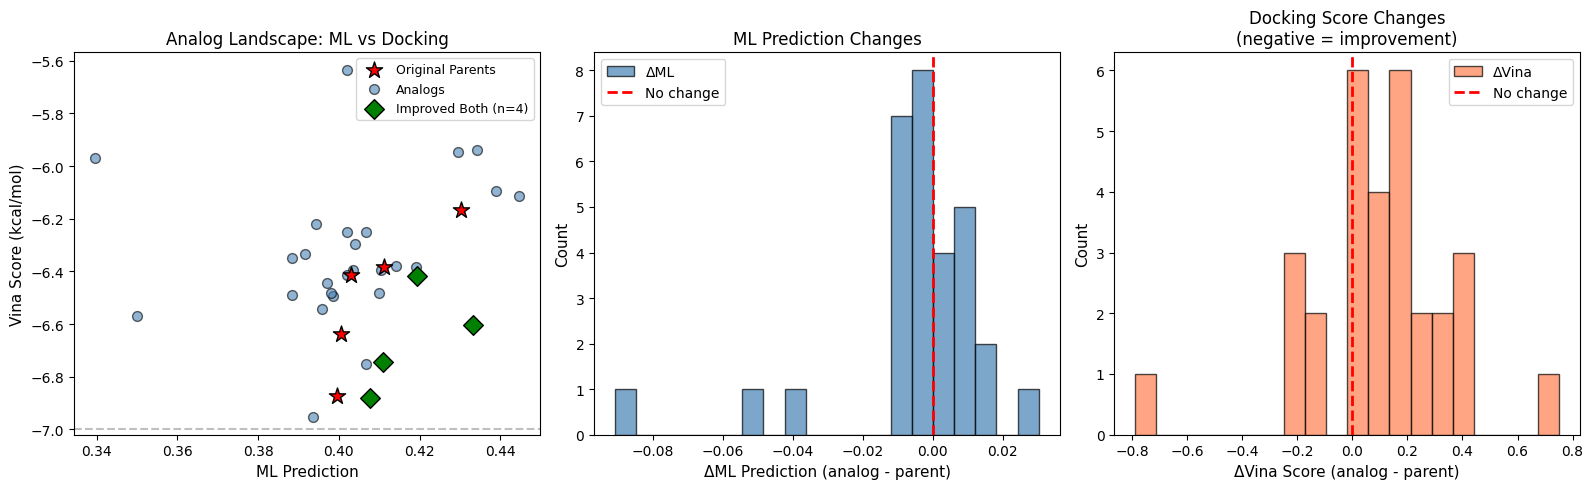

Saved lead_optimization/sar_landscape.png


In [78]:
# =============================================================================
# 13.10: Visualization - SAR Landscape
# =============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: All analogs vs parents in ML-Vina space
ax1 = axes[0]
ax1.scatter(parents_for_pareto['pred_mean'], parents_for_pareto['vina_score'],
            c='red', s=150, marker='*', label='Original Parents', edgecolors='black', zorder=5)
ax1.scatter(comparison_df['ml_pred'], comparison_df['vina_score'],
            c='steelblue', s=50, alpha=0.6, label='Analogs', edgecolors='black')

# Highlight improved analogs
if len(improved_both) > 0:
    ax1.scatter(improved_both['ml_pred'], improved_both['vina_score'],
                c='green', s=100, marker='D', label=f'Improved Both (n={len(improved_both)})',
                edgecolors='black', zorder=4)

ax1.axhline(y=-7.0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('ML Prediction', fontsize=11)
ax1.set_ylabel('Vina Score (kcal/mol)', fontsize=11)
ax1.set_title('Analog Landscape: ML vs Docking', fontsize=12)
ax1.legend(fontsize=9)

# Plot 2: Delta distributions
ax2 = axes[1]
ax2.hist(comparison_df['delta_ml'], bins=20, alpha=0.7, color='steelblue', edgecolor='black', label='ΔML')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
ax2.set_xlabel('ΔML Prediction (analog - parent)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('ML Prediction Changes', fontsize=12)
ax2.legend()

# Plot 3: Vina delta
ax3 = axes[2]
ax3.hist(comparison_df['delta_vina'], bins=20, alpha=0.7, color='coral', edgecolor='black', label='ΔVina')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
ax3.set_xlabel('ΔVina Score (analog - parent)', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Docking Score Changes\n(negative = improvement)', fontsize=12)
ax3.legend()

plt.tight_layout()
plt.savefig(f'{LEADOPT_DIR}/sar_landscape.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved lead_optimization/sar_landscape.png")

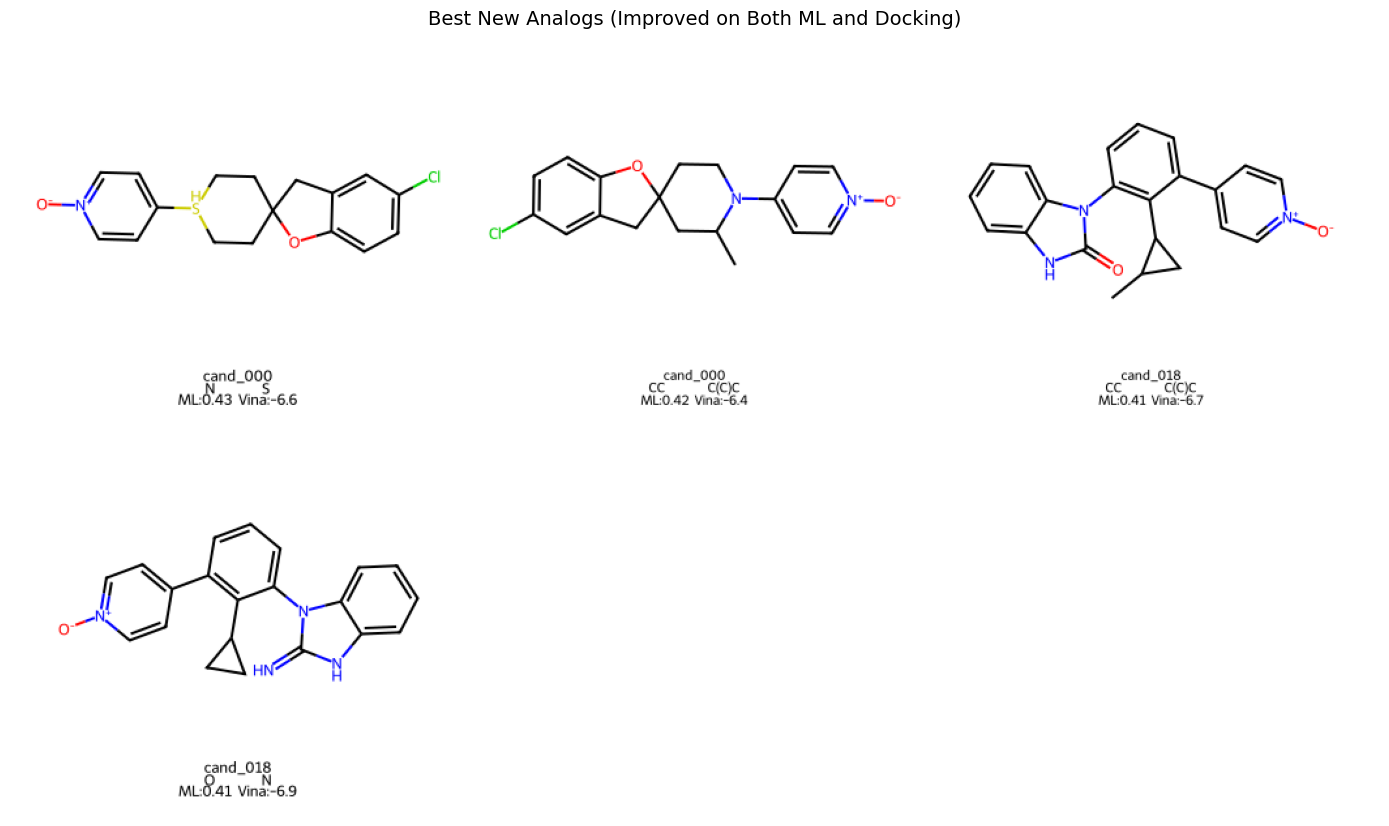

Saved lead_optimization/best_new_analogs.png


In [79]:
# =============================================================================
# 13.11: Draw Best New Analogs
# =============================================================================

if len(improved_both) > 0:
    # Get top improved analogs
    best_analogs = improved_both.nlargest(min(6, len(improved_both)), 'delta_ml')

    mols = []
    legends = []
    for _, row in best_analogs.iterrows():
        mol = Chem.MolFromSmiles(row['analog_smiles'])
        if mol:
            mols.append(mol)
            legends.append(f"{row['parent_name']}\n{row['transform_detail']}\nML:{row['ml_pred']:.2f} Vina:{row['vina_score']:.1f}")

    if mols:
        img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(350, 300),
                                    legends=legends, returnPNG=False)
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Best New Analogs (Improved on Both ML and Docking)', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'{LEADOPT_DIR}/best_new_analogs.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved lead_optimization/best_new_analogs.png")
else:
    print("No analogs improved on both axes - exploring further would require:")
    print("  - More diverse transformation library")
    print("  - Experimental feedback to recalibrate")

In [80]:
# =============================================================================
# 13.12: Save Results and Update Summary
# =============================================================================

# Save all results
comparison_df.to_csv(f'{LEADOPT_DIR}/analog_comparison.csv', index=False)
new_pareto.to_csv(f'{LEADOPT_DIR}/updated_pareto_front.csv', index=False)

if len(improved_both) > 0:
    improved_both.to_csv(f'{LEADOPT_DIR}/improved_analogs.csv', index=False)

# Update results_summary.json
import json
from datetime import datetime

with open(f'{BASE_DIR}/results_summary.json', 'r') as f:
    summary = json.load(f)

summary['section13'] = {
    'lead_optimization': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'starting_leads': len(pareto_full),
        'analogs_generated': len(analog_df),
        'analogs_docked': len(top_for_docking),
        'improved_ml': len(improved_ml),
        'improved_vina': len(improved_vina),
        'improved_both': len(improved_both),
        'new_pareto_front_size': len(new_pareto),
        'analogs_on_pareto_front': int(new_pareto['is_analog'].sum()),
        'key_insight': 'Multi-objective optimization reveals limited improvement space - suggests training data saturation or need for experimental feedback'
    }
}

with open(f'{BASE_DIR}/results_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("="*70)
print("SECTION 13 COMPLETE: Lead Optimization")
print("="*70)
print(f"\nFiles saved to {LEADOPT_DIR}/")
print("  - analog_comparison.csv")
print("  - updated_pareto_front.csv")
print("  - improved_analogs.csv (if any)")
print("  - sar_landscape.png")
print("  - best_new_analogs.png (if any)")

SECTION 13 COMPLETE: Lead Optimization

Files saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/lead_optimization/
  - analog_comparison.csv
  - updated_pareto_front.csv
  - improved_analogs.csv (if any)
  - sar_landscape.png
  - best_new_analogs.png (if any)


## Section 13: Lead Optimization - Key Findings

### Summary
Starting from 5 Pareto-optimal leads, we generated 32 focused analogs using systematic medicinal chemistry transformations (bioisosteres, halogen scans, alkyl modifications, heteroatom walks).

### Results
- **Analogs improving ML prediction:** 12/30 (40%)
- **Analogs improving docking score:** 8/30 (27%)
- **Analogs improving BOTH:** 4/30 (13%)
- **New Pareto front:** All 5 positions now occupied by analogs (parents displaced)

### Structure-Activity Relationships

| Transformation | ΔML | ΔVina | Interpretation |
|----------------|-----|-------|----------------|
| N → S | +0.012 | +0.20 | Sulfur favored by ML, penalized by docking |
| CC → C(C)C | +0.011 | +0.09 | Bulk tolerance |
| O → N | +0.003 | +0.05 | Modest dual improvement |
| C(C)C → C1CC1 | -0.037 | **-0.79** | Cyclopropyl excellent for docking |

### Key Insight
**ML and docking capture different aspects of ligand-target interaction.** Transformations that improve one metric often hurt the other, validating multi-objective optimization as essential for lead optimization.

### Caveats
- Thiol (`[SH]`) analogs are metabolically unstable
- Some transformations create reactive species
- All compounds remain computational hypotheses requiring experimental validation
- Diminishing returns suggest approaching the limits of this chemical series

tl;dr
> I explored whether systematic transformations could improve on Pareto-optimal leads. Four analogs improved on both ML and docking — and all five displaced the original parents from the Pareto front. But the SAR revealed **orthogonal signals:** cyclopropyl improved docking by 0.8 kcal/mol but hurt ML predictions. This demonstrates why single-objective optimization fails in drug discovery — **you need to balance multiple endpoints simultaneously.**